# Frequency Analysis Documentation

## Overview
This script is designed for frequency analysis of DIEM (Data In Emergencies) monitoring data, aggregated at the ADM0 level, typically corresponding to the country level. The data, derived from household surveys, provides insights into various indicators reflecting conditions in each country.

## Goal
The primary objective of the script is to analyze the frequency at which specific countries' data fall into extreme ranges for each indicator. This analysis is crucial for identifying not just the extremities but also the regularity of these occurrences, which offers insights into persistent patterns or anomalies in the data. It's important to note that for some indicators, low values might be indicative of positive outcomes, while for others, high values might be favorable. Therefore, the script generates histograms for both high and low extremes to provide a comprehensive view of each country's performance across different indicators.

Following the individual analysis of each indicator, the script compiles a cumulative chart that aggregates occurrences of extreme values across all indicators, providing a holistic view of each country's frequency of encountering extreme conditions. Furthermore, by identifying indicators where high values are beneficial, the script also produces a 'Negative extremes' chart. This chart focuses on the count and frequency of countries experiencing undesirable extremes, either too high or too low, based on the nature of the indicator. This nuanced approach is essential for understanding which countries consistently encounter specific challenges or successes, and it helps to highlight areas requiring attention or intervention.

## Methodology

This script employs a multi-step methodology to provide a comprehensive analysis of the DIEM monitoring data:

1. **Threshold Calculation**:
   - **Method**: Applies percentile, standard deviation, or equal interval methods to determine high and low thresholds for each indicator. This method is crucial for identifying extreme values that deviate significantly from the norm.
   - **Interpretation**: Thresholds help to pinpoint extreme data points, essential for understanding outlier behavior in the dataset.
2. **Individual Variable-Country Charting**:
   - **Method**: Generates line plots for each country displaying the progression of an indicator over time. High and low thresholds are marked on these charts.
   - **Interpretation**: These charts visualize the temporal dynamics of each indicator, helping identify trends, patterns, and anomalies in country-specific data.
3. **Histograms for High and Low Extremes**:
   - **Method**: For each variable, the script creates two histograms – one showing the count and frequency of countries’ values exceeding the high threshold, and another for values below the low threshold.
   - **Interpretation**: These histograms quantify how often countries experience extreme values, either high or low, providing insights into the frequency of such occurrences.
4. **Cumulative Extremes Chart**:
   - **Method**: Aggregates the occurrences of extreme values across all indicators for each country, displaying both the total count and frequency.
   - **Interpretation**: This chart offers a holistic view of a country's propensity towards extremes, highlighting those consistently encountering extreme conditions across various indicators.
5. **Negative Extremes Chart**:
   - **Method**: After specifying which indicators are positively associated with high values, this chart counts and quantifies the frequency of countries with negative (undesirable) extreme values.
   - **Interpretation**: It helps to identify countries frequently facing adverse conditions, emphasizing the indicators where high values are typically seen as positive.

## Overall Approach

The script's approach is to dissect the data layer by layer, starting from individual indicators and building up to an aggregate analysis. By doing so, it provides a nuanced understanding of the data, from specific indicator trends to overarching patterns. This method allows for both micro-level (individual indicator and country analysis) and macro-level (cumulative trends and general patterns) insights, crucial for informed decision-making and policy development in emergency response contexts.

The script applies various methods to define thresholds for the extremes:
- **Percentiles**: Data is classified based on specified high and low percentiles (e.g., 90th and 10th percentiles), highlighting countries in the top or bottom percentages for each indicator.
- **Standard Deviation (std_dev)**: Thresholds are set at specified multiples of standard deviation from the mean, pinpointing outliers.
- **Equal Interval**: Data range is divided into equal intervals, with thresholds at interval boundaries.


## User Options

- `percentile`: The percentile for the 'percentiles' method.
- `num_std_dev`: The number of standard deviations from the mean for the 'std_dev' method.
- `num_classes`: The number of classes for the 'equal_interval' method.
- `method`: The classification method - 'percentiles', 'std_dev', or 'equal_interval'.
- `positive_high_value_vars`: List of variables where high values are positive'.

## Output Explanation and Interpretation
- **Charts**: Line plots for each country display the values of an indicator over time, with color differentiation for clarity.
- **Thresholds**: Horizontal lines on the charts represent thresholds.
- **Histograms**: Two histograms follow each chart:
  - One shows the frequency of a country’s values above the high threshold.
  - The other indicates the frequency below the low threshold.
- **Interpretation**: These histograms are key in understanding the frequency of extreme values for each country. They reveal patterns and outliers, highlighting countries that consistently face challenges or excel in specific areas.
- **Cumulative Chart**: Aggregates occurrences in high and low ranges across all indicators, displaying both count and frequency.
- **Negative Extremes Chart**: After specifying variables where high values are positive, this chart shows counts and percentages of countries with particularly Negative values.

## Data Source
Aggregated DIEM data can be accessed at [https://data-in-emergencies.fao.org/](https://data-in-emergencies.fao.org/). Users must create an account and navigate to Data Access to find the relevant datasets.

## Usage
To use the script, ensure `df` contains the DIEM monitoring data and `fields_descr_df` has the field descriptions. Adjust user options according to analysis requirements. The script outputs plots, histograms, and a final chart detailing the frequency and nature of extreme values across different countries, highlighting those consistently facing challenges or excelling in specific areas.

In [1]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.tseries.offsets import QuarterEnd
import matplotlib.cm as cm
import numpy as np
import matplotlib.patheffects as path_effects

In [2]:
# Function to calculate thresholds
def calculate_thresholds(data, percentile=None, num_std_dev=None, method='percentiles'):
    if method == 'percentiles':
        low_percentile = 100 - percentile
        return [np.nanpercentile(data, low_percentile), np.nanpercentile(data, percentile)]
    elif method == 'std_dev':
        mean = data.mean()
        std = data.std()
        return [mean - num_std_dev * std, mean + num_std_dev * std]
    elif method == 'equal_interval':
        min_val, max_val = data.min(), data.max()
        interval = (max_val - min_val) / num_classes
        return [min_val + interval * i for i in range(1, num_classes)]
    else:
        raise ValueError("Invalid method")

In [3]:
# Load the data from the CSV file
file_path = r'C:\temp\diem_monitoring_adm0.csv'
df = pd.read_csv(file_path)

# List of countries
countries = df['adm0_iso3'].unique()

# List of variables to plot (excluding the country and date columns)
variables = df.columns.drop(['adm0_iso3', 'adm0_name', 'coll_mid_date', 'round'])

##load fields descriptions

# Excel file path
file_path = r'C:\temp\DIEM_2023_-_Fields_descriptions.xlsx'
# Load the Excel file
xlsx = pd.ExcelFile(file_path)
# Get all sheet names except the first one
sheet_names = xlsx.sheet_names[1:]  # Skip the first sheet
# Initialize an empty DataFrame to hold merged data
merged_df = pd.DataFrame()
# Loop through each sheet and extract the table
for sheet in sheet_names:
    desc_df = pd.read_excel(xlsx, sheet_name=sheet, header=2)  # Header is at the third row (index 2)
    merged_df = pd.concat([merged_df, desc_df], ignore_index=True)
fields_descr_df = merged_df


In [4]:
print('List of variables analysed:')

# Create a dictionary mapping field names to descriptions for faster lookup
field_description_dict = pd.Series(fields_descr_df['Field description'].values, index=fields_descr_df['Field name']).to_dict()
counter = 0
# Loop through each variable and print the description if available, otherwise print the variable name
for variable in variables:
    counter +=1

    # Check if the variable is in the field descriptions
    if variable in field_description_dict:
        # Print the field description
        print('\n%s)' % counter, variable, ': ',field_description_dict[variable])
    elif variable + "_1" in field_description_dict:
        # Print the field description
        print('\n%s)' % counter, variable, ': ', field_description_dict[variable + "_1"])
    else:
        # If the variable is not found, print the variable name
        print('\n%s)' % counter, variable)


List of variables analysed:

1) income_main_anydecrease

2) crp_harv_anydecrease

3) crp_area_anydecrease

4) crp_proddif_seed_quantity :  Percentage of households that, for question asked: 'Which difficulty has your household faced with crop production in #season#?', have answered: 'Access to enough seeds (not available on markets or prices too high)'. #season# will be replaced with the country specific information (e.g. wet season, monsoon season, harvest season, etc...).

5) crp_proddif_seed_quality :  Percentage of households that, for question asked: 'Which difficulty has your household faced with crop production in #season#?', have answered: 'Access to quality seeds'. #season# will be replaced with the country specific information (e.g. wet season, monsoon season, harvest season, etc...).

6) crp_proddif_plant_disease :  Percentage of households that, for question asked: 'Which difficulty has your household faced with crop production in #season#?', have answered: 'Plant disease'.

## Section Methodology

The next section begins by setting user options, such as the method of classification (percentiles, standard deviation, or equal intervals), along with specific parameters for these methods like the percentile value or the number of standard deviations.

The data for analysis is loaded from a specified CSV file. The script then initializes dictionaries to store cumulative counts and total data points for high and low extremes for each country.

In the main loop, for each variable of interest (excluding country and date columns), the script:

1. **Retrieves a Description**: For the variable from a pre-loaded field description DataFrame. If no direct match is found, it tries appending "_1" to the variable name to find a match.
   
2. **Calculates Thresholds**: Based on the chosen method (percentiles, std_dev, or equal_interval). These thresholds are used to define what constitutes an 'extreme' value.

3. **Country-Level Analysis**: For each country, calculates the count of data points that fall above the high threshold and below the low threshold. These counts are accumulated in the respective cumulative count dictionaries.

4. **Generates Line Plot**: For each country, showing the variable values over time. Horizontal lines are drawn at the calculated thresholds to visually identify extremes.

5. **Generates Histograms**: After processing all countries for a variable, histograms are generated showing the frequency of each country's data points above the high threshold and below the low threshold.

This process is repeated for each variable, providing a comprehensive analysis of how frequently each country's data falls into extreme ranges across various indicators.


income_main_anydecrease


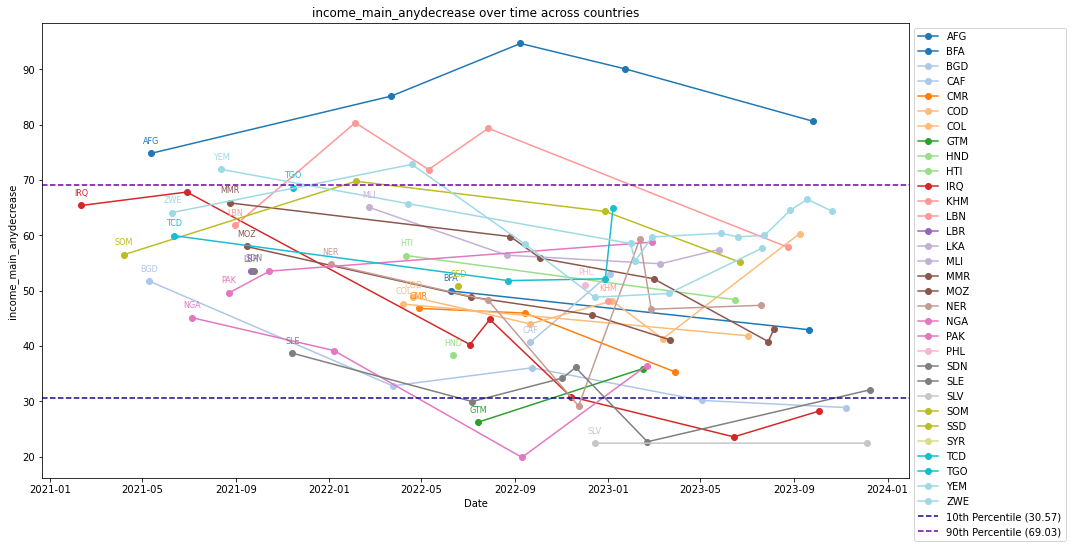

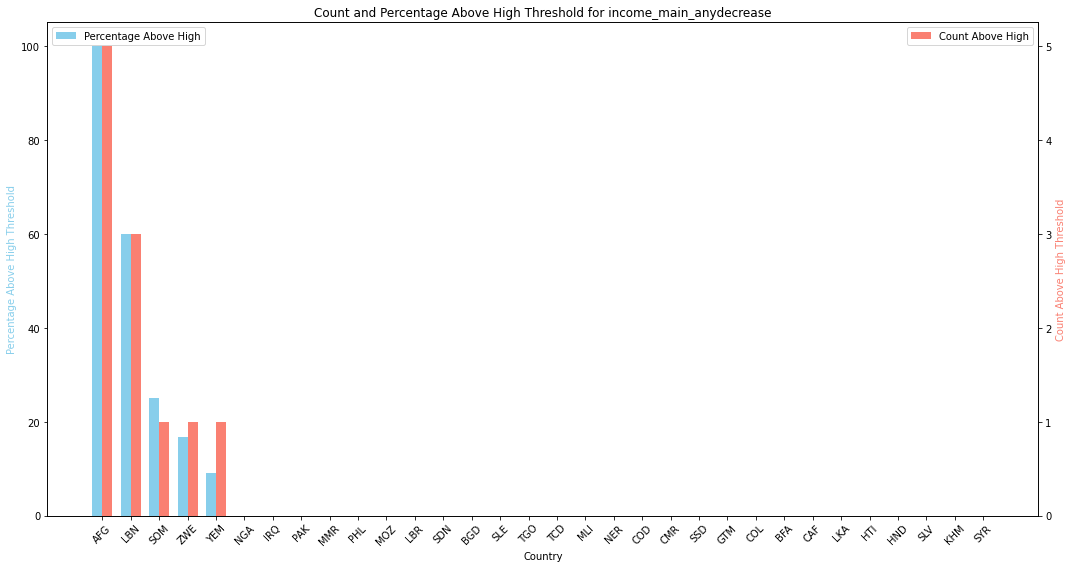

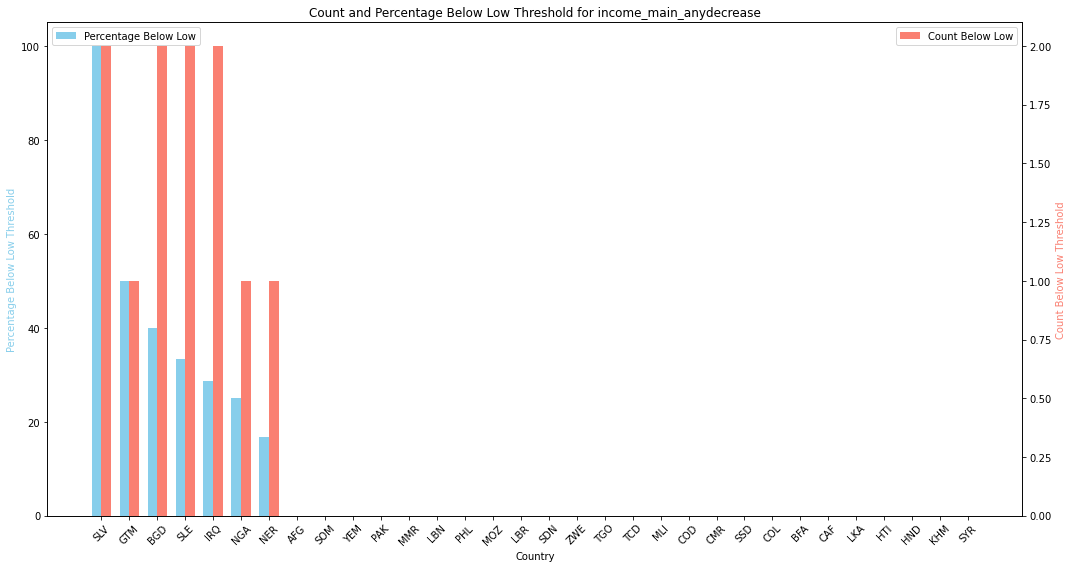

crp_harv_anydecrease


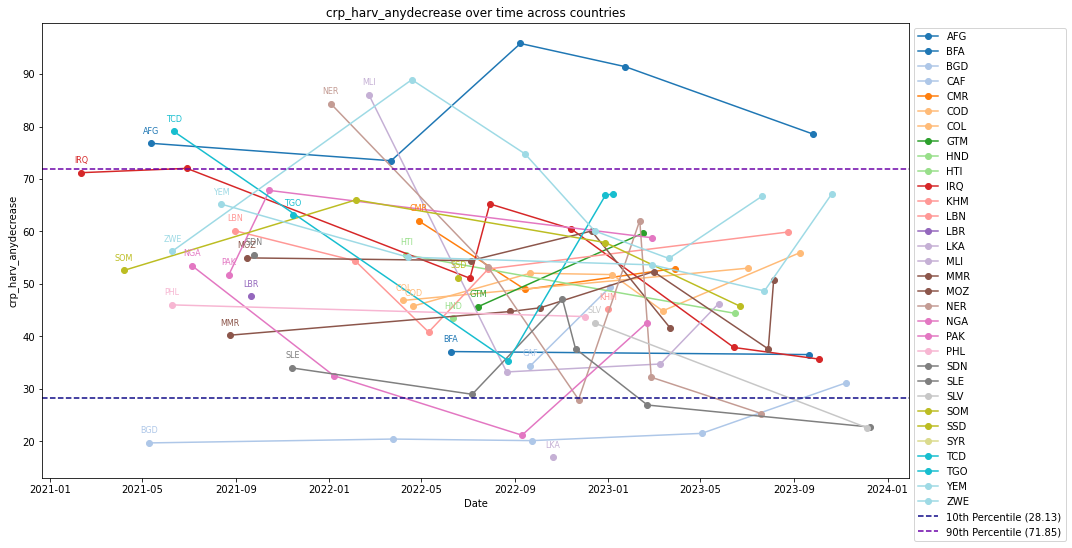

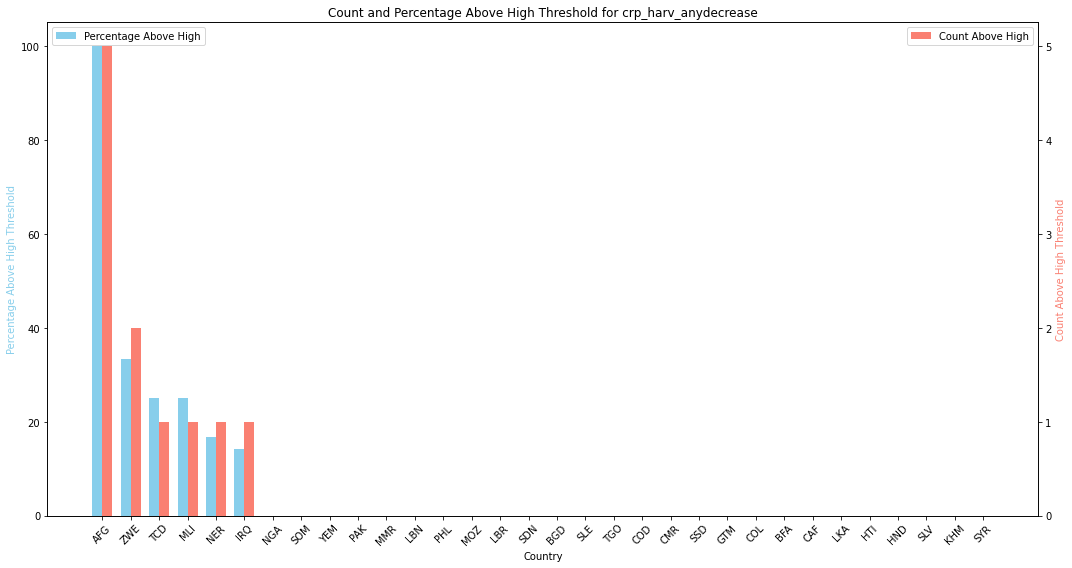

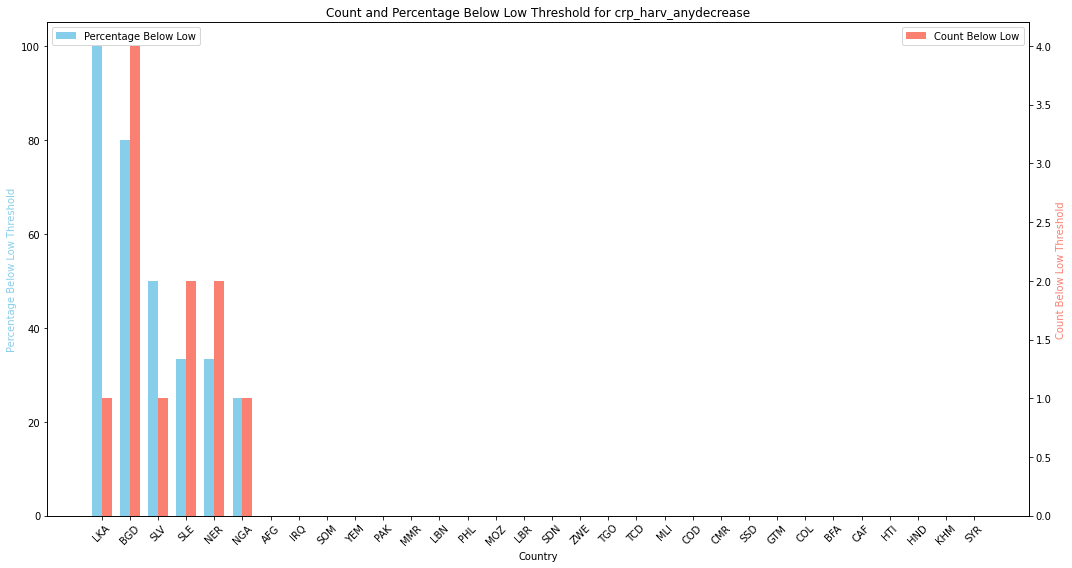

crp_area_anydecrease


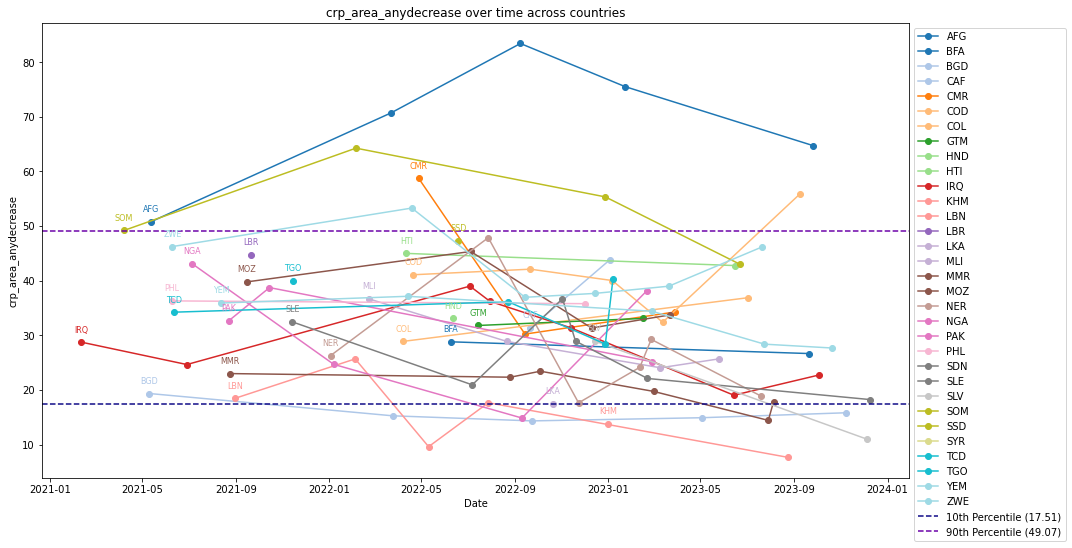

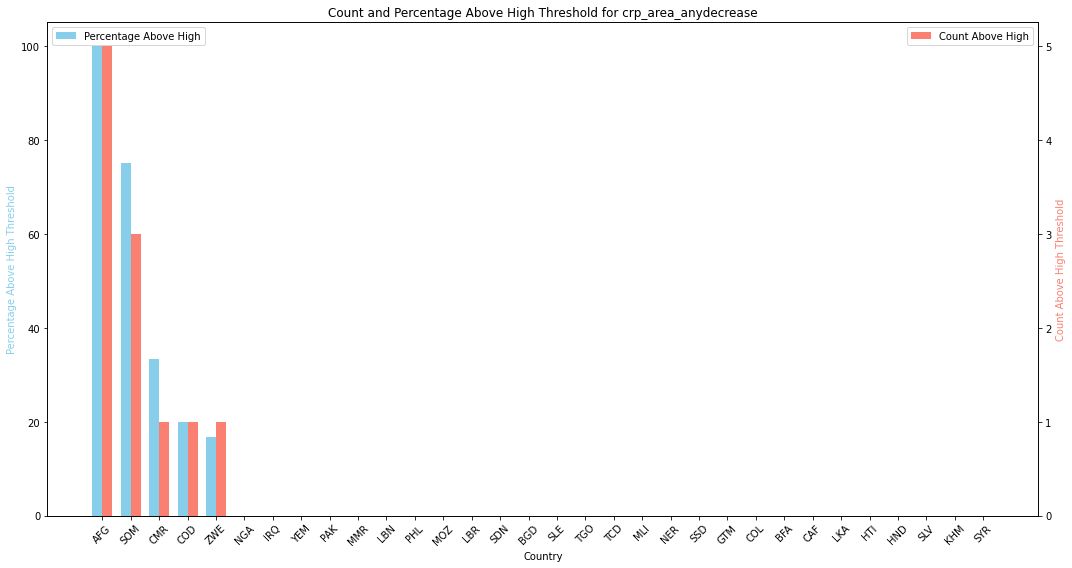

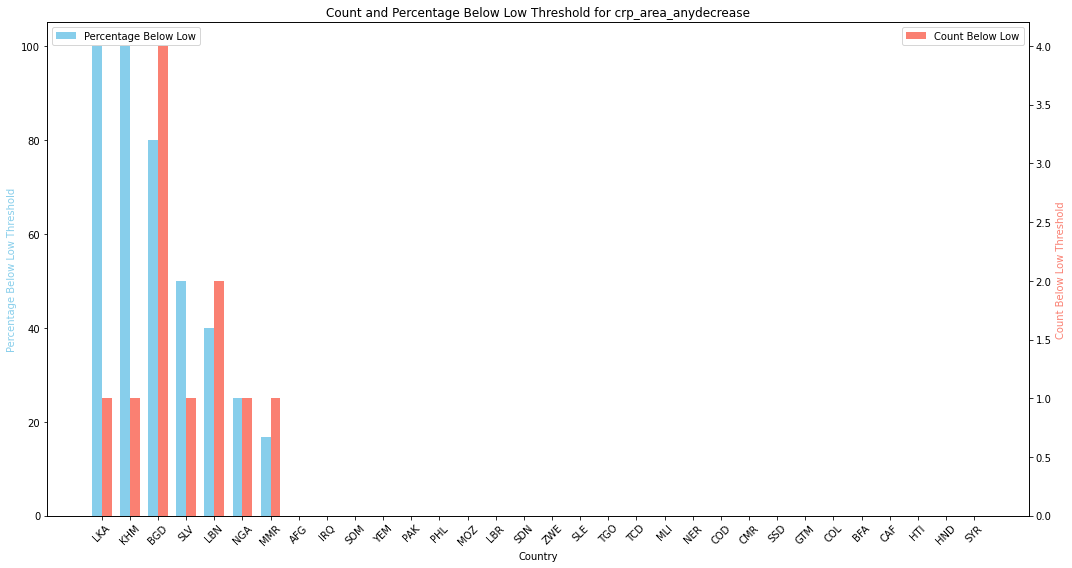

crp_proddif_seed_quantity
Percentage of households that, for question asked: 'Which difficulty has your household faced with crop production in #season#?', have answered: 'Access to enough seeds (not available on markets or prices too high)'. #season# will be replaced with the country specific information (e.g. wet season, monsoon season, harvest season, etc...).


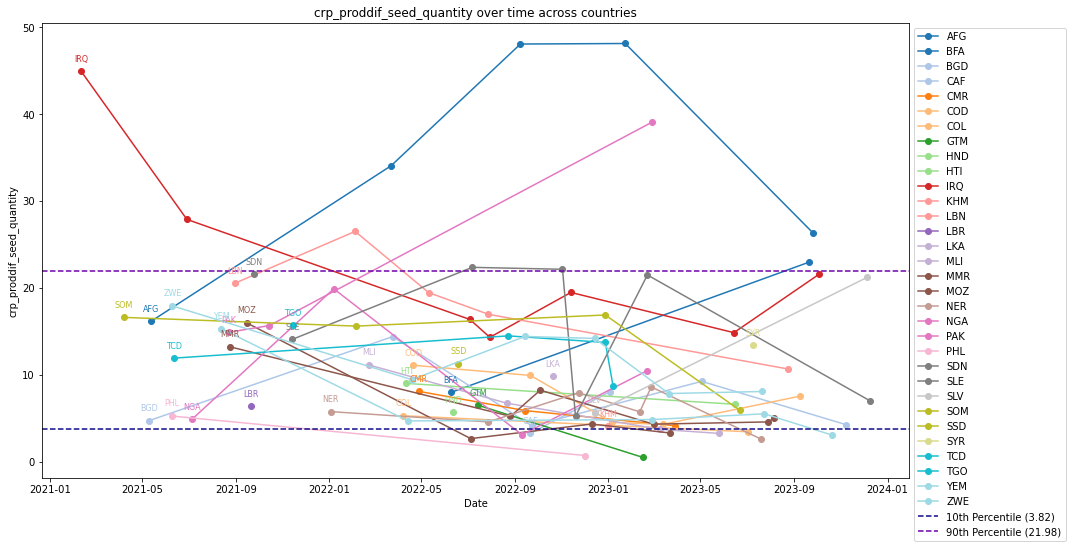

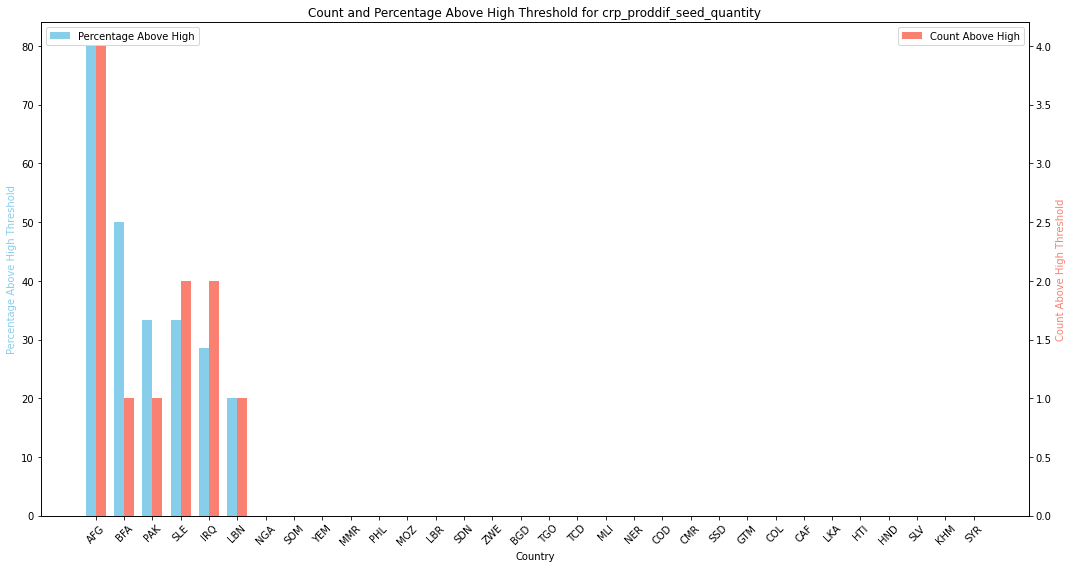

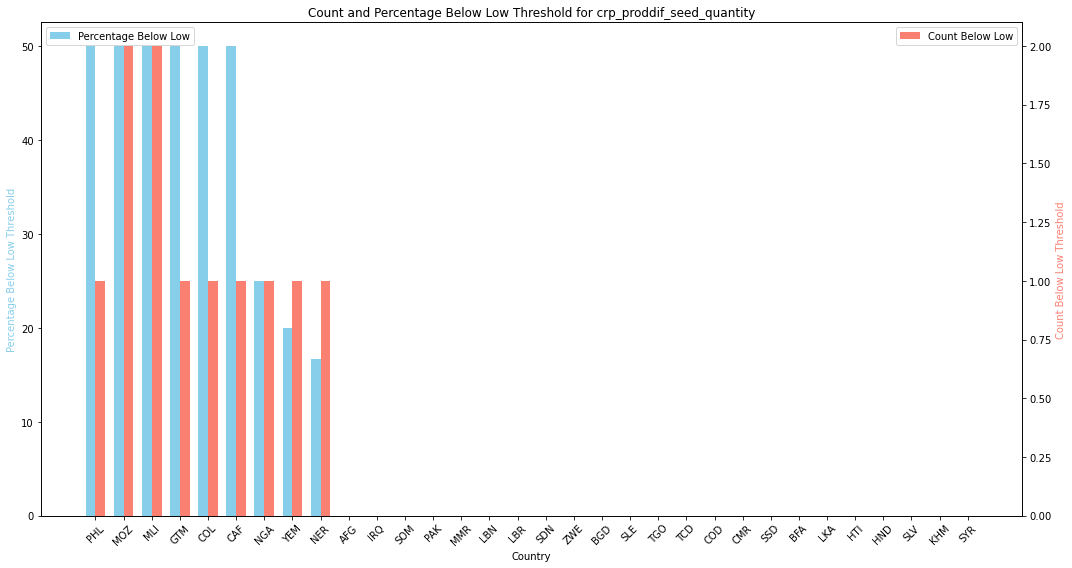

crp_proddif_seed_quality
Percentage of households that, for question asked: 'Which difficulty has your household faced with crop production in #season#?', have answered: 'Access to quality seeds'. #season# will be replaced with the country specific information (e.g. wet season, monsoon season, harvest season, etc...).


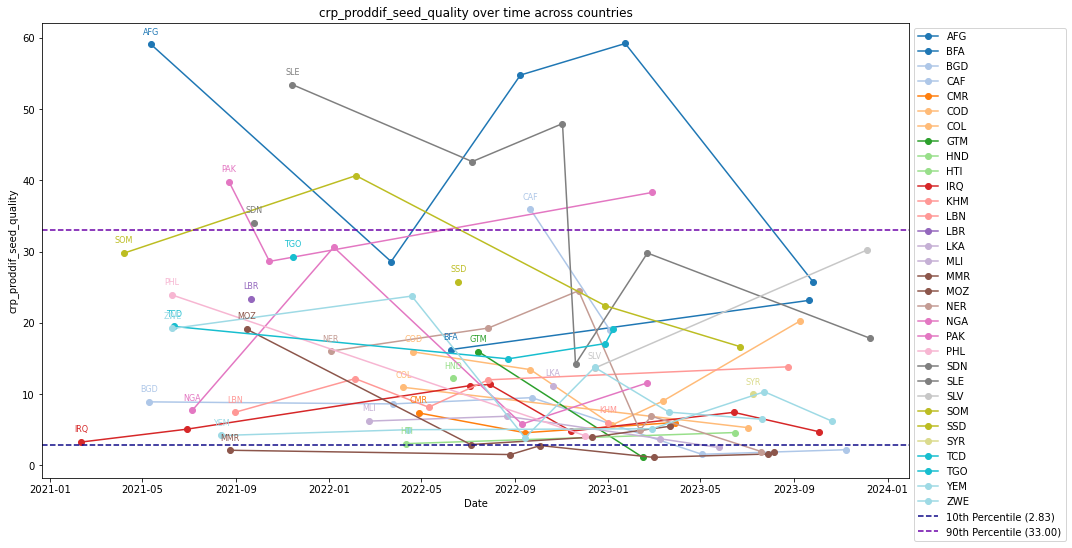

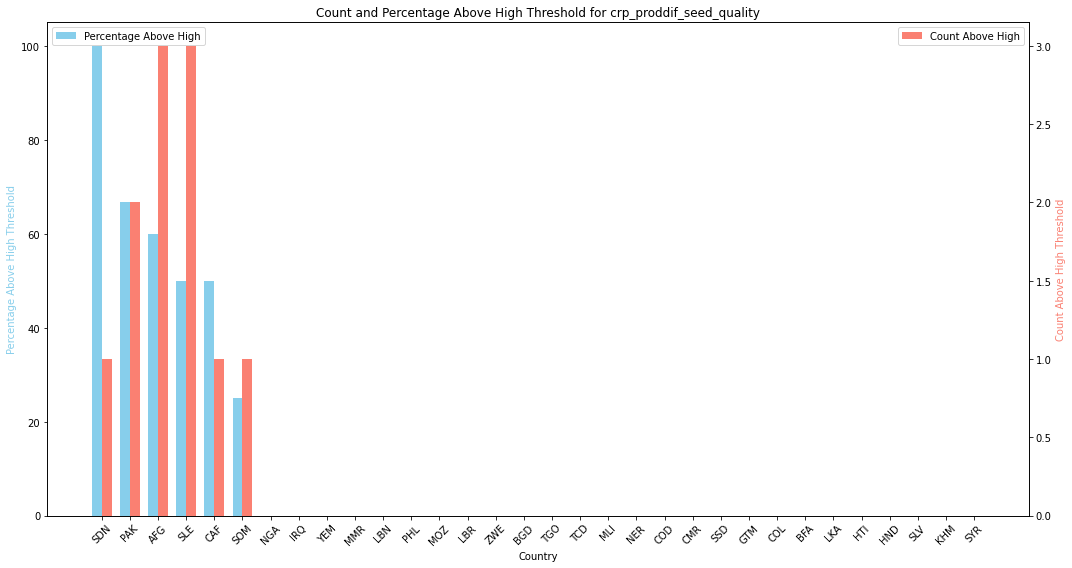

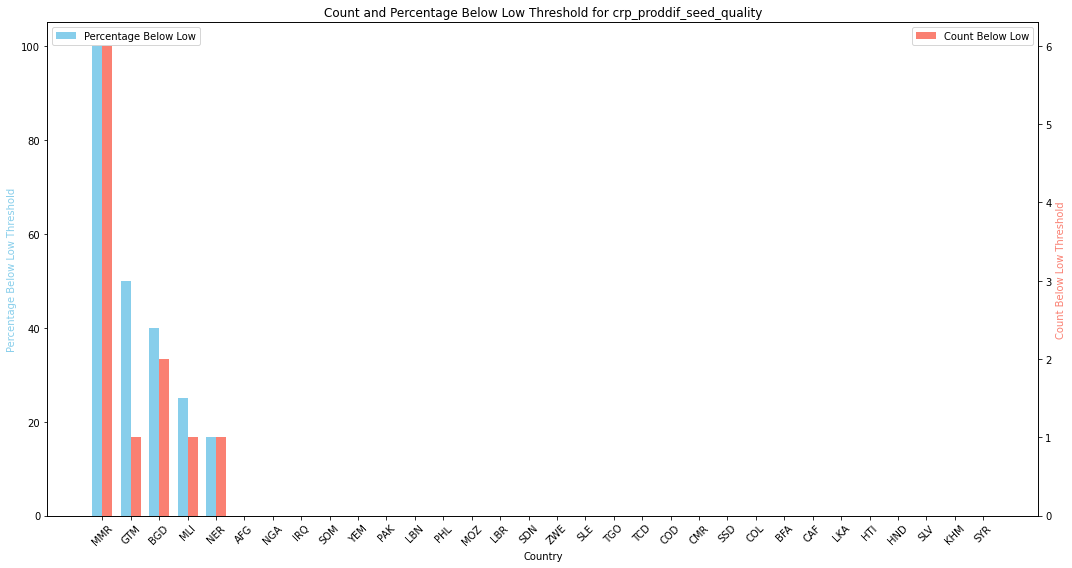

crp_proddif_plant_disease
Percentage of households that, for question asked: 'Which difficulty has your household faced with crop production in #season#?', have answered: 'Plant disease'. #season# will be replaced with the country specific information (e.g. wet season, monsoon season, harvest season, etc...).


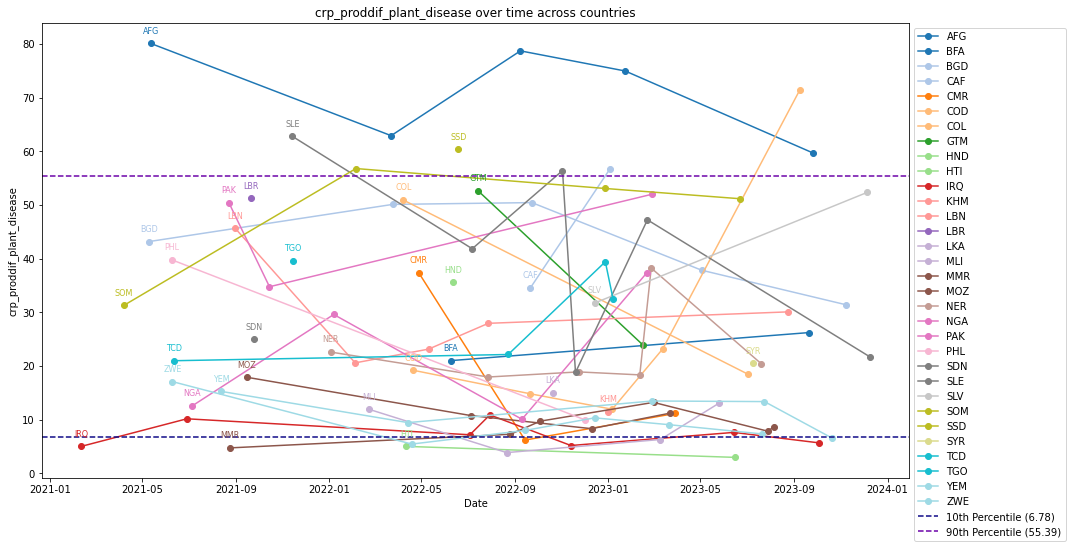

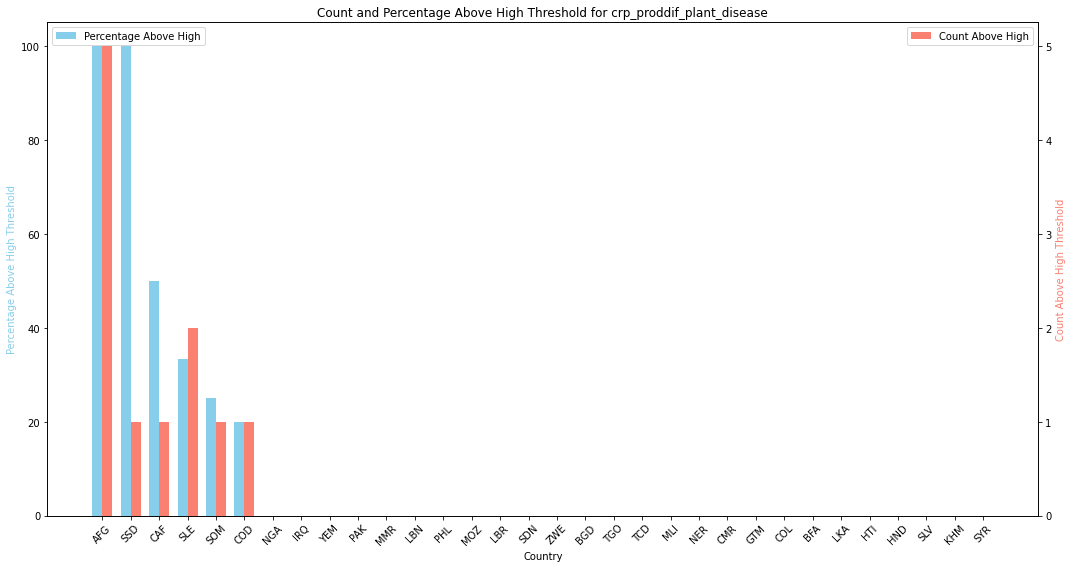

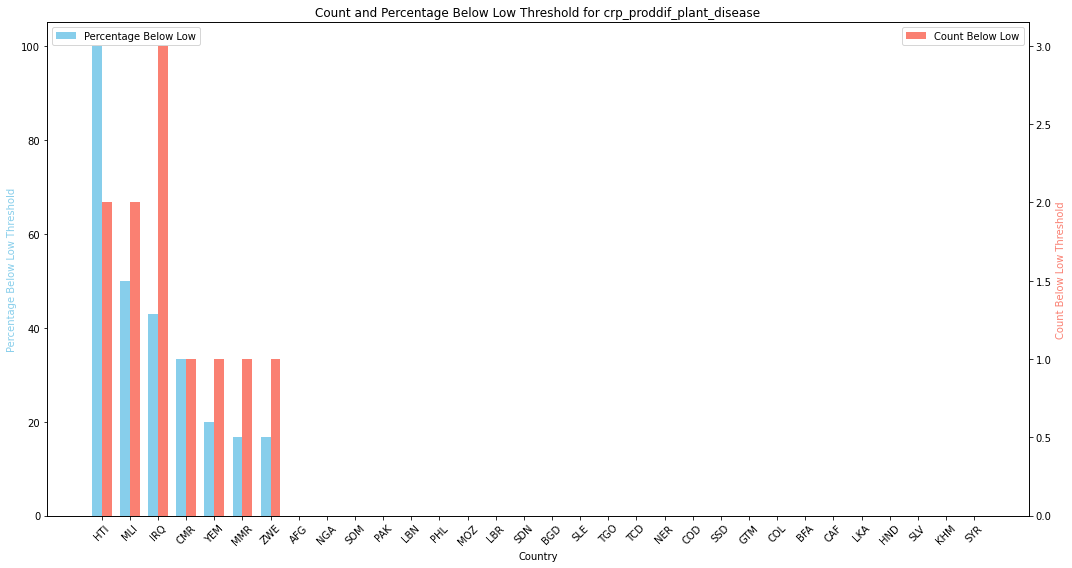

crp_proddif_lack_irrigation
Percentage of households that, for question asked: 'Which difficulty has your household faced with crop production in #season#?', have answered: 'Not enough irrigation / rainfall water'. #season# will be replaced with the country specific information (e.g. wet season, monsoon season, harvest season, etc...).


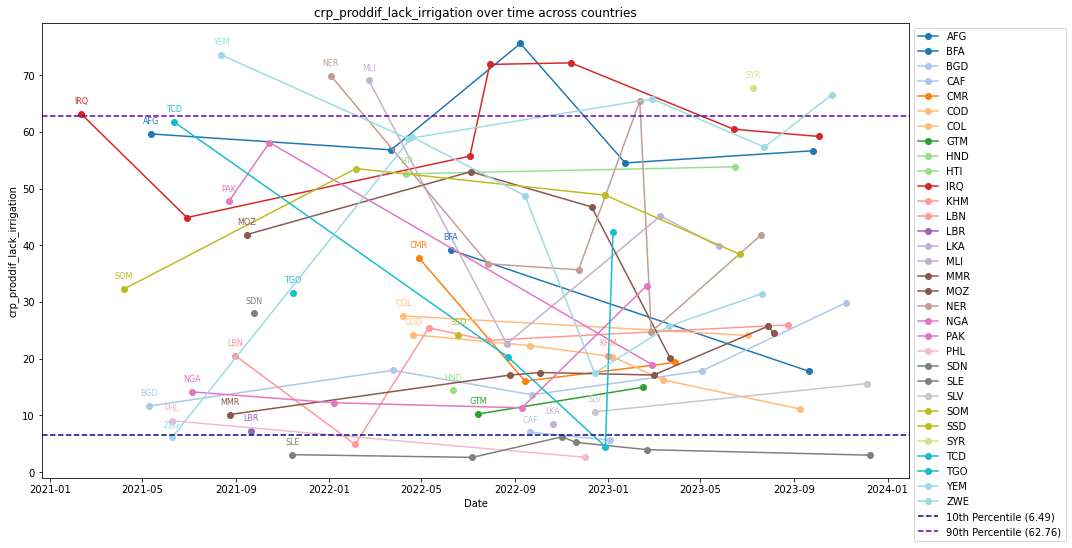

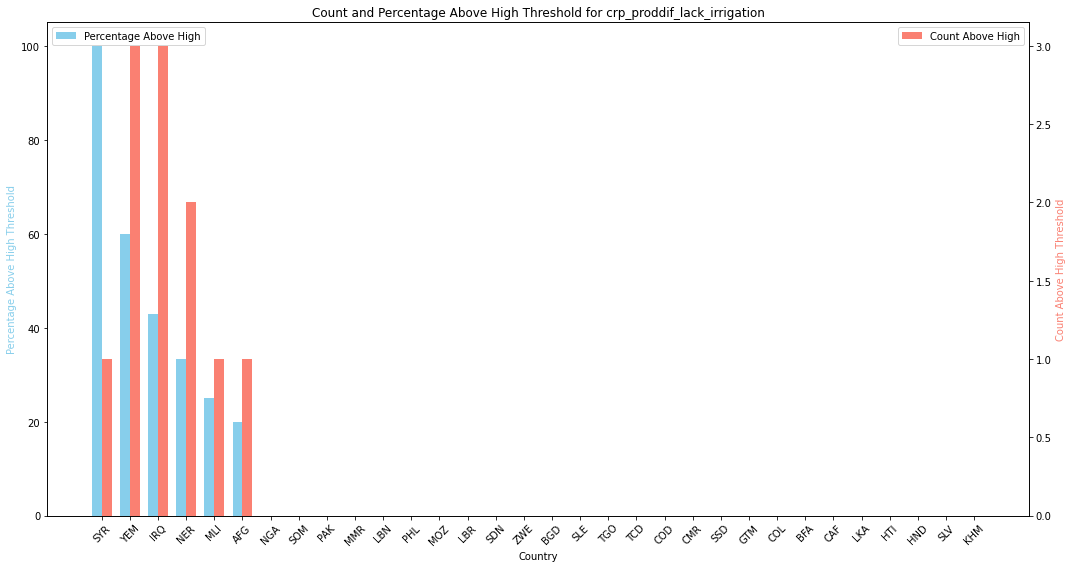

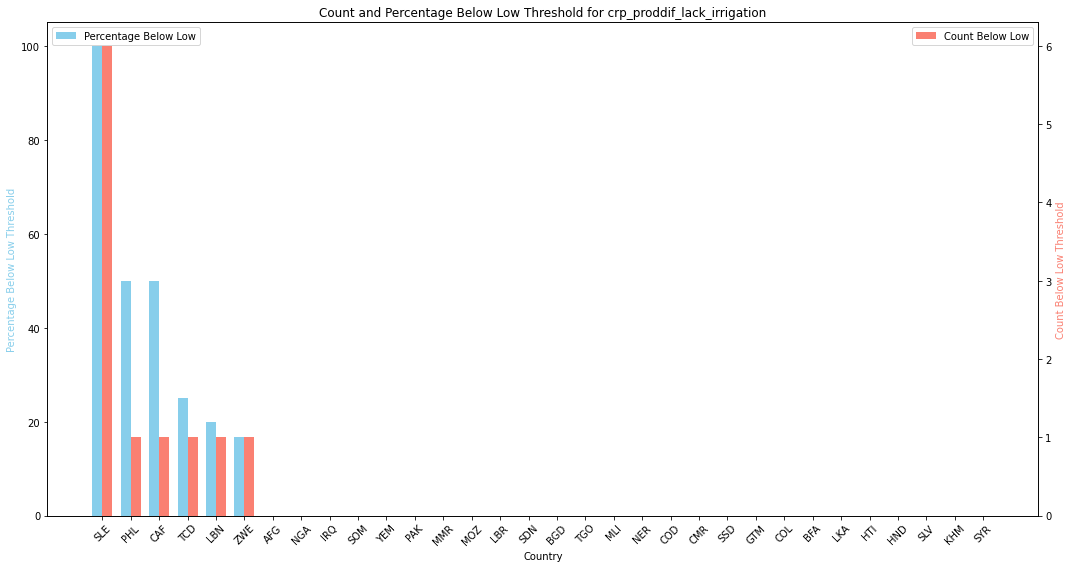

crp_saledif_marketing_cost
Percentage of households that, for question asked: 'Which difficulties has your household faced in the last 3 months selling your [crp_salesmain]?', have answered: 'Market flooded with products'. [crp_salesmain] will be replaced with the main crop sold by the respondent's household


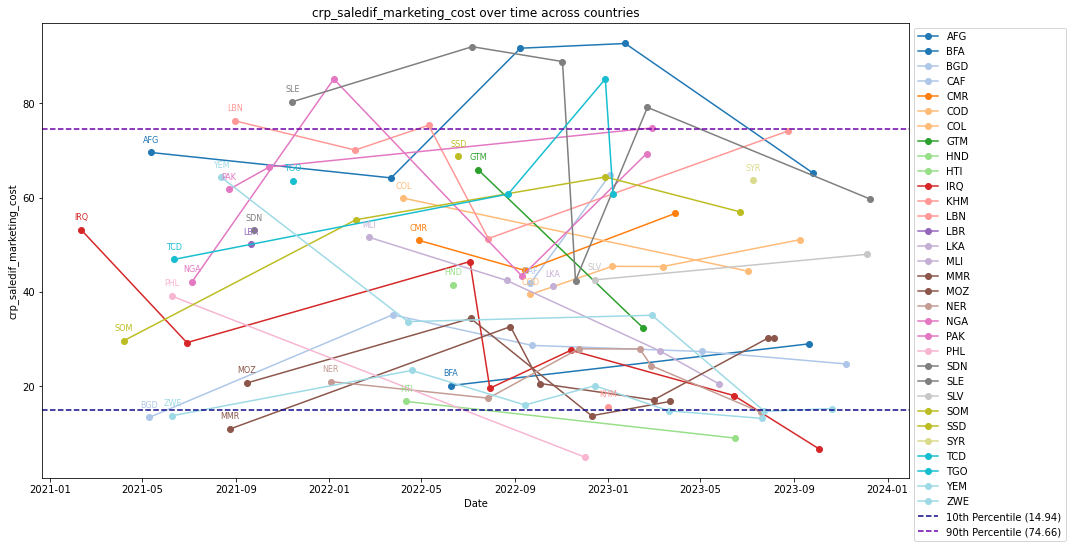

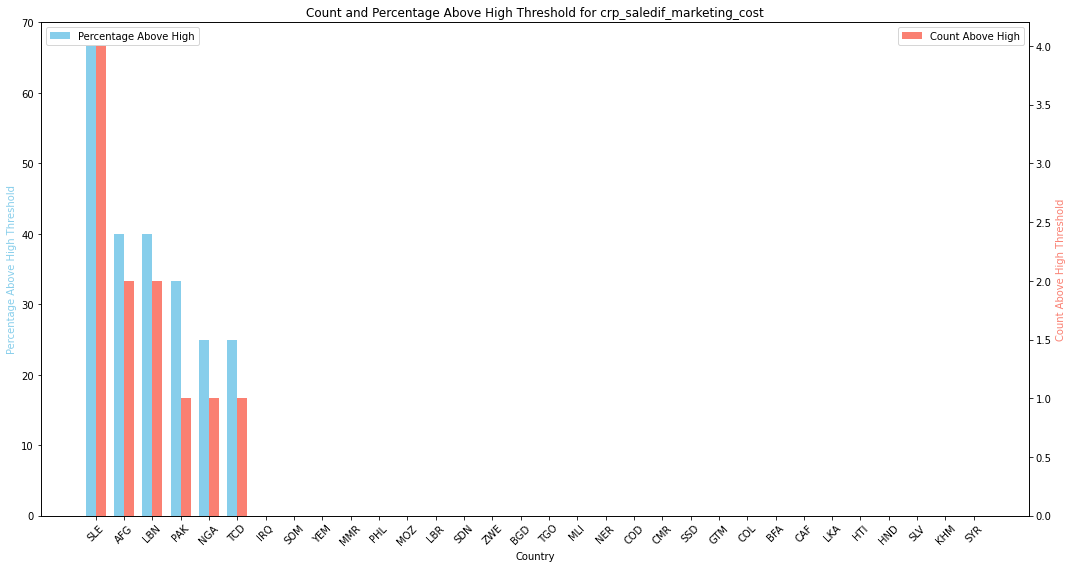

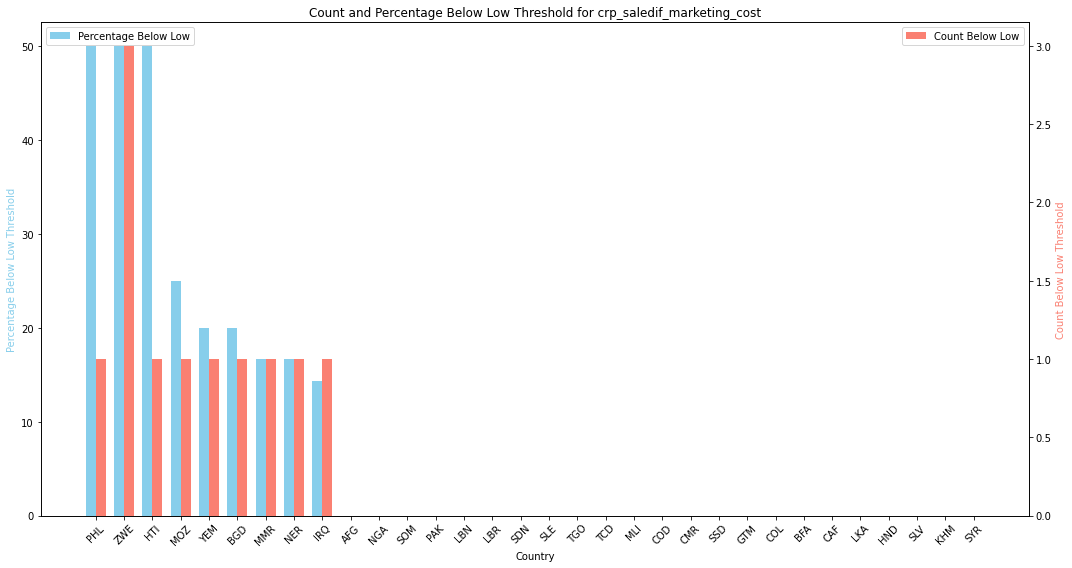

ls_num_decreased
Percentage of households reported decrease in the number of livestock compared to last year at the same time.


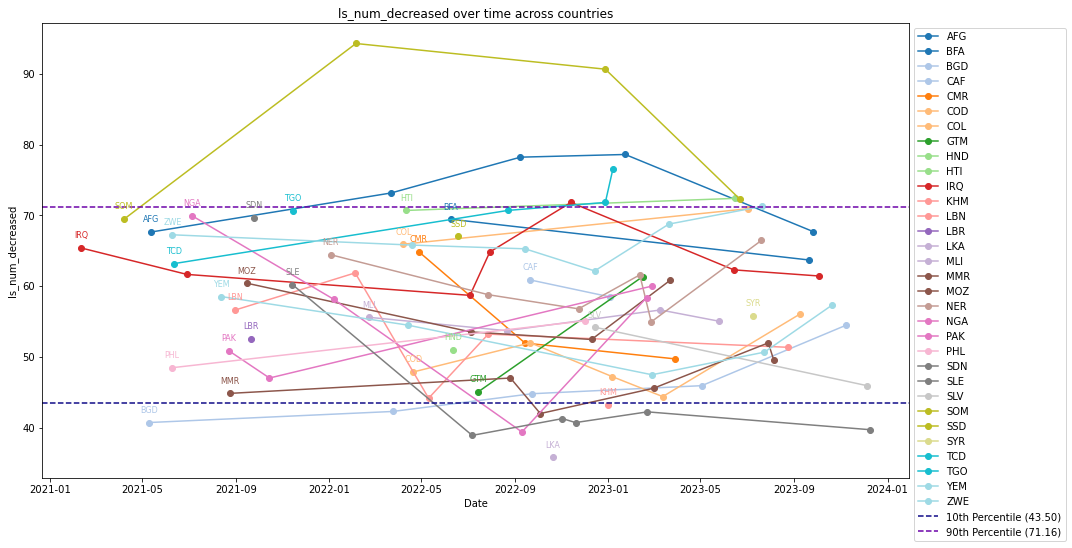

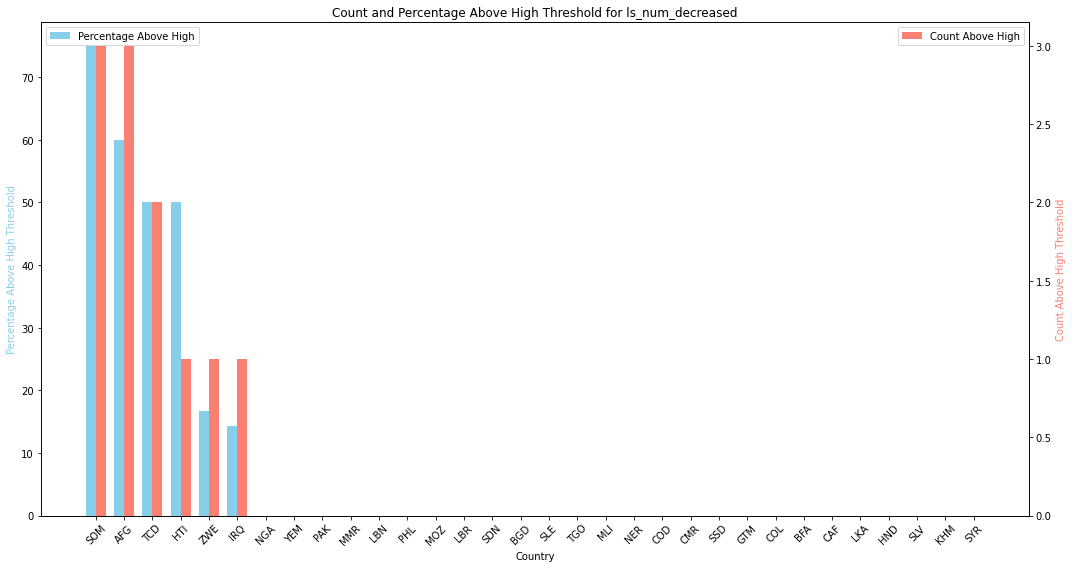

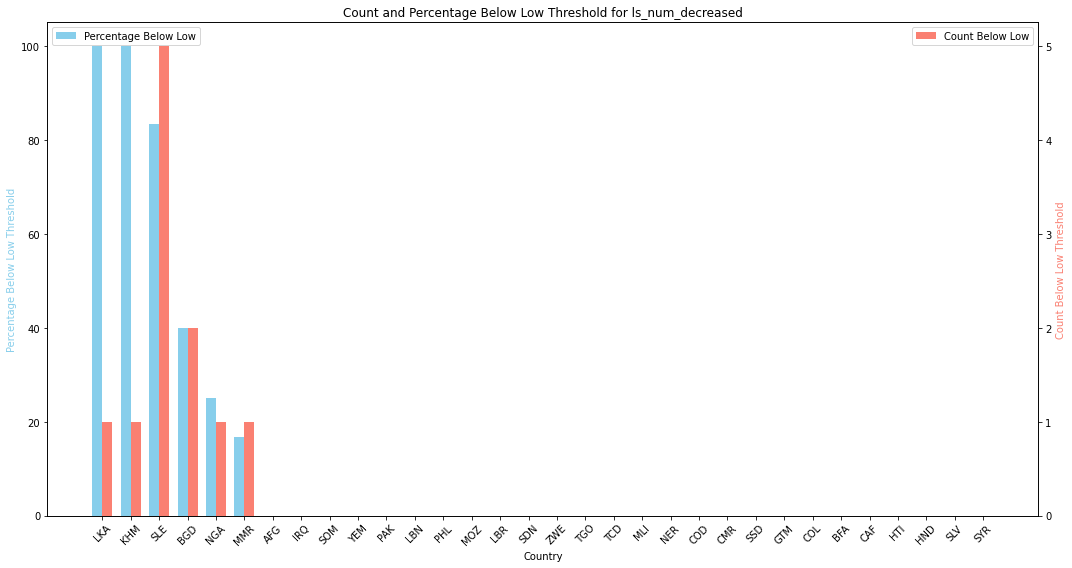

p_mod_wmean
Mean of prevalence of recent moderate or severe household food insecurity (FIES). The values range from 0 to 1


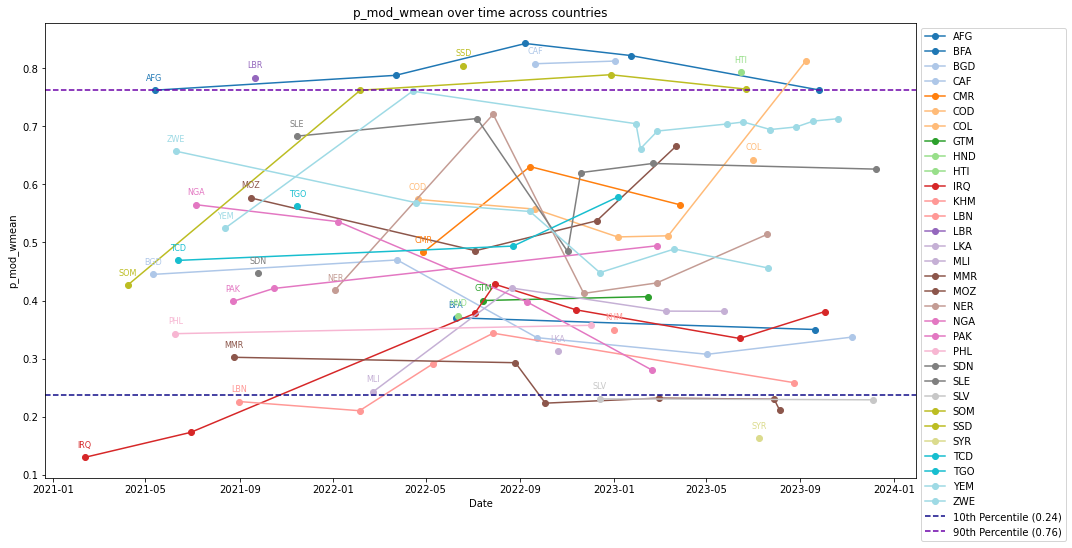

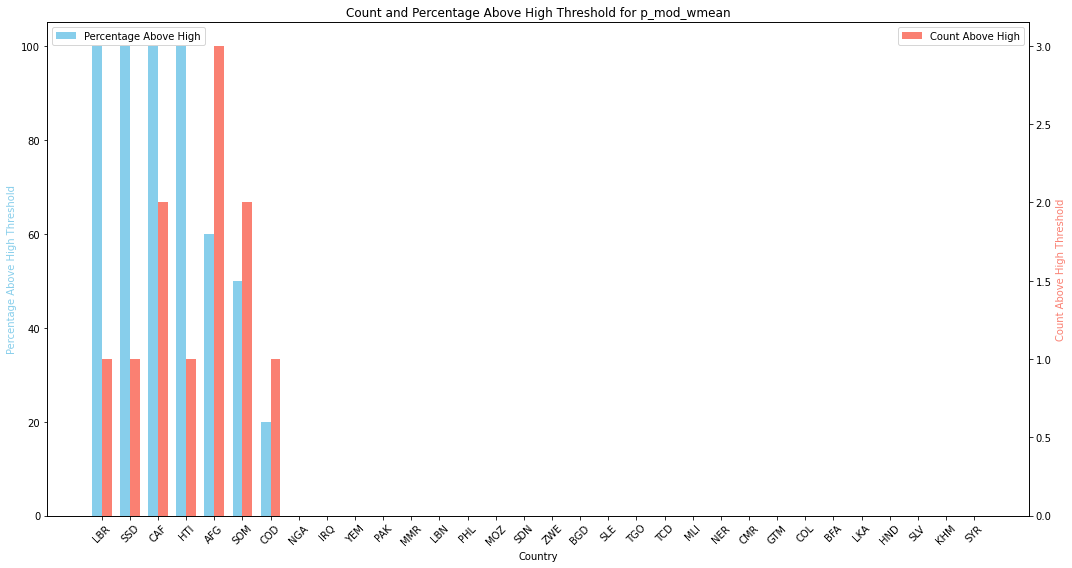

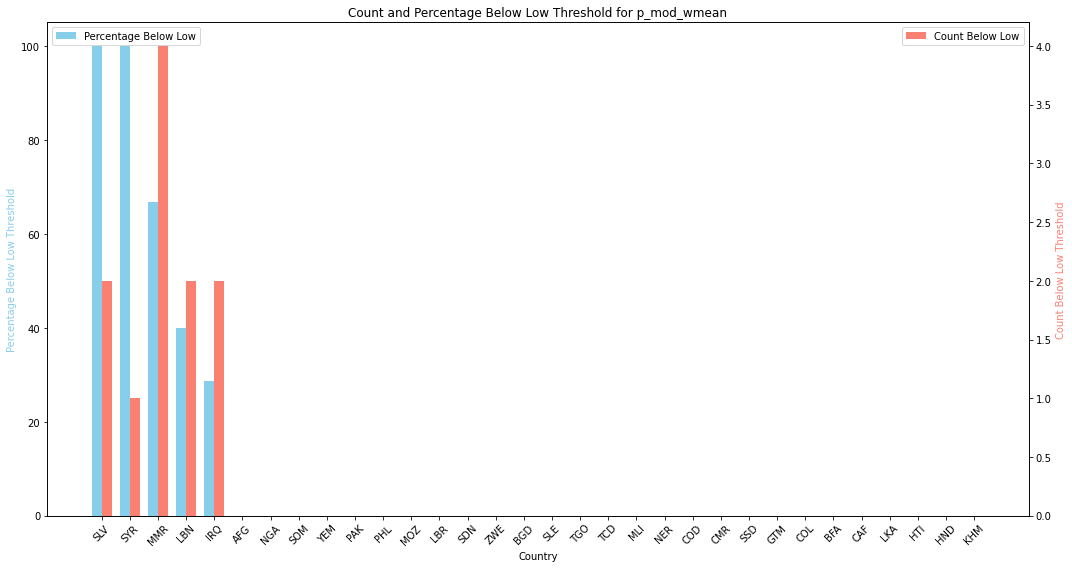

p_sev_wmean
Mean of prevalence of recent severe household food insecurity (FIES). The values range from 0 to 1


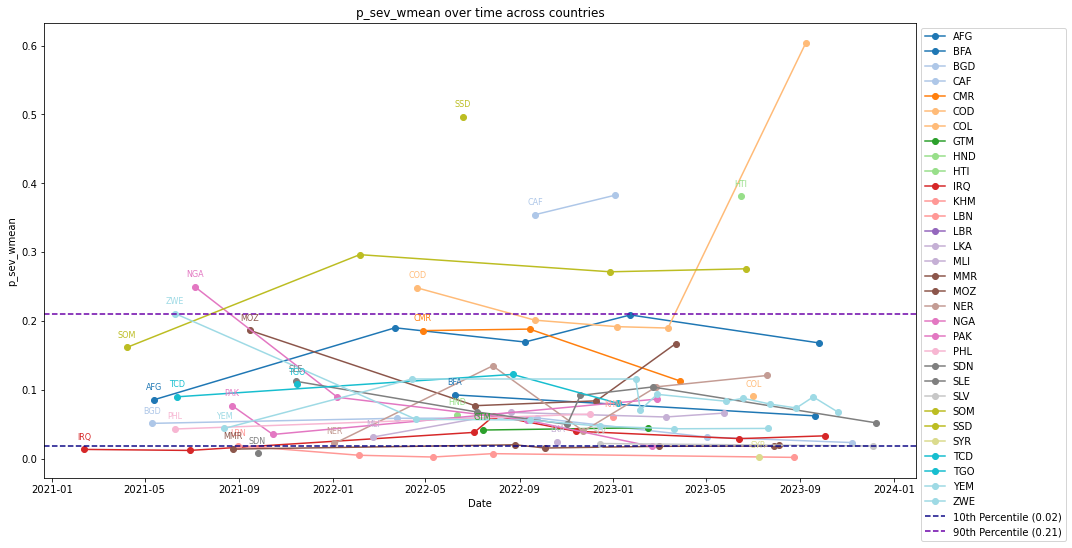

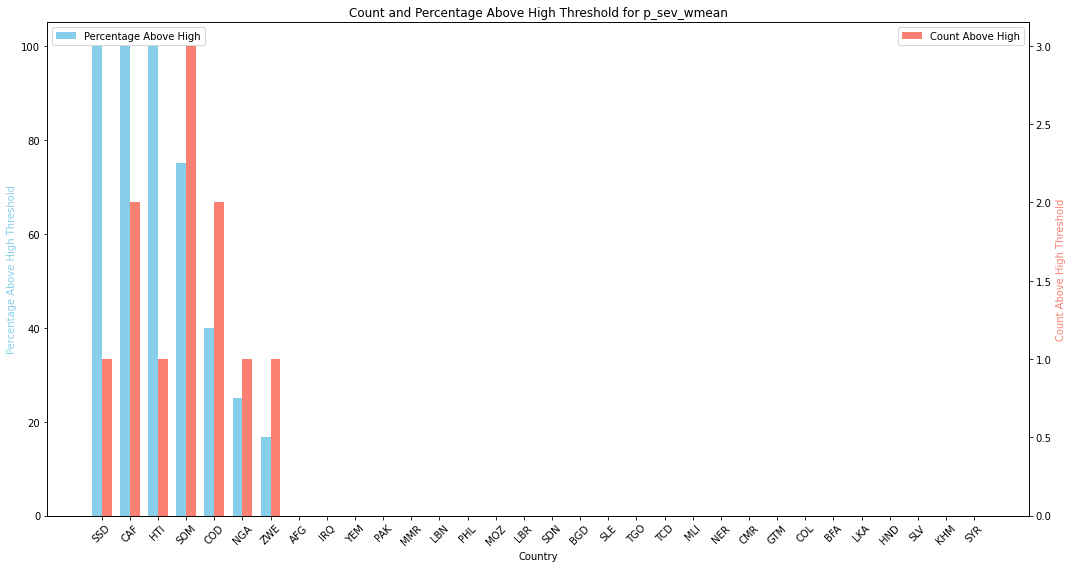

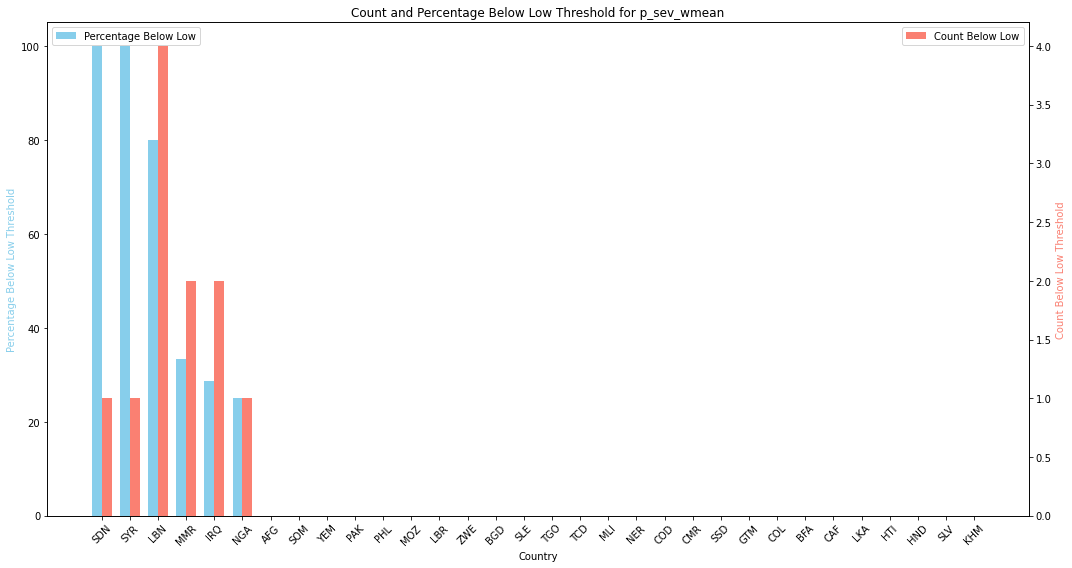

hdds_class_1
Percentage of households that resulted with Household Dietary Diversity Score(HDDS) - Low dietary diversity


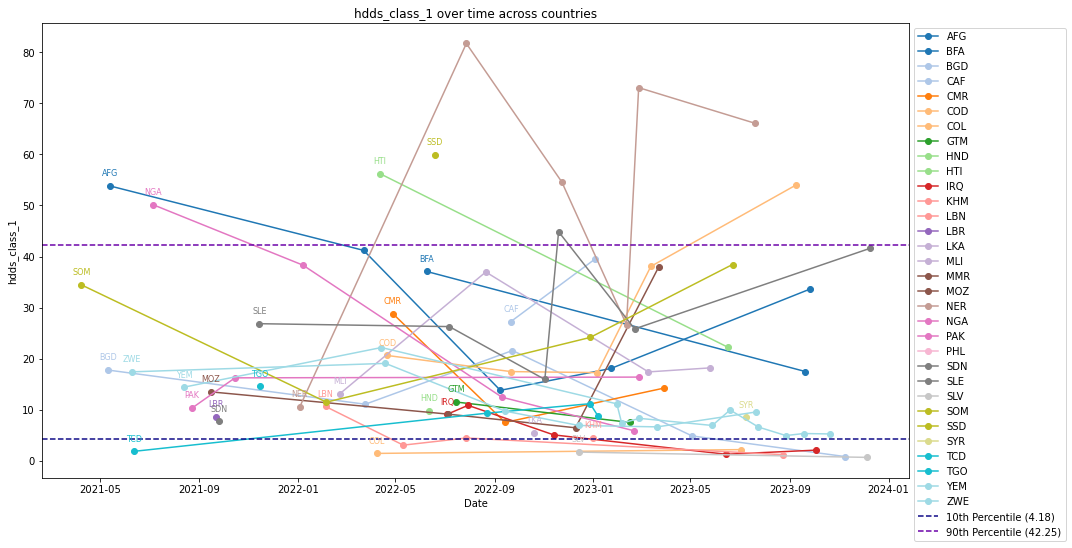

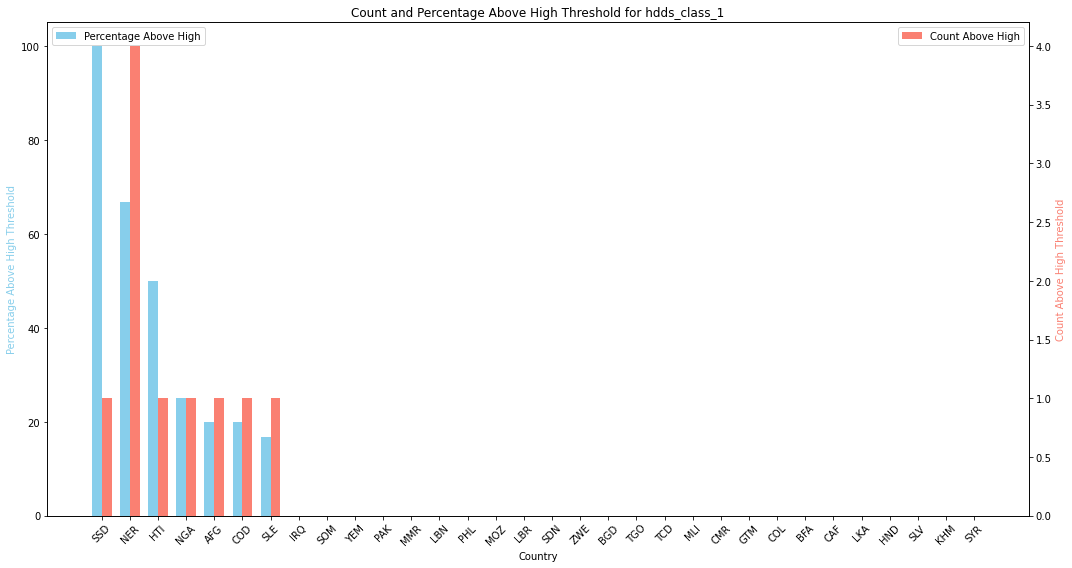

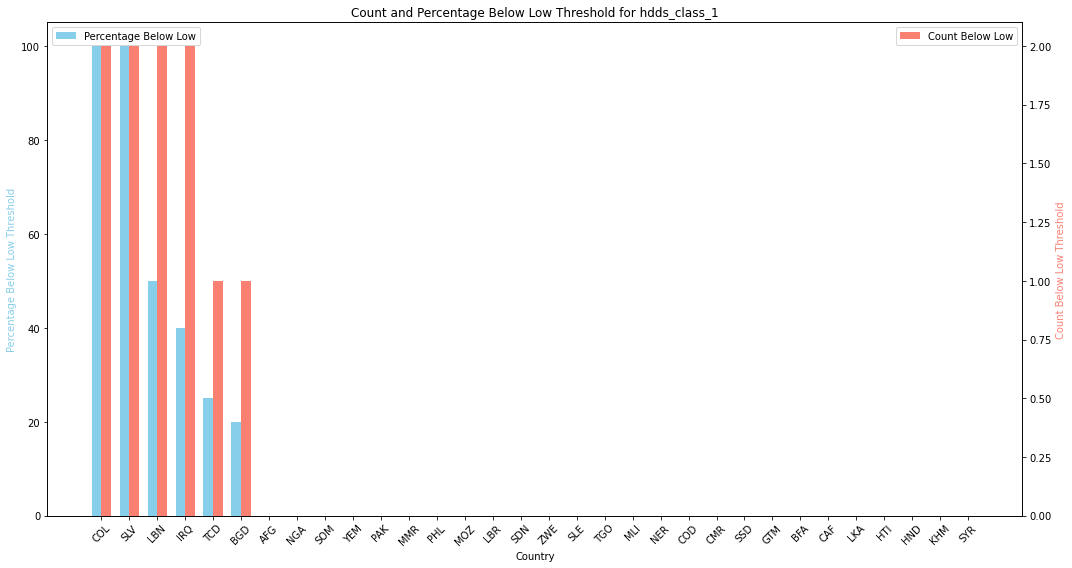

hdds_class_2
Percentage of households that resulted with Household Dietary Diversity Score(HDDS) - Medium dietary diversity


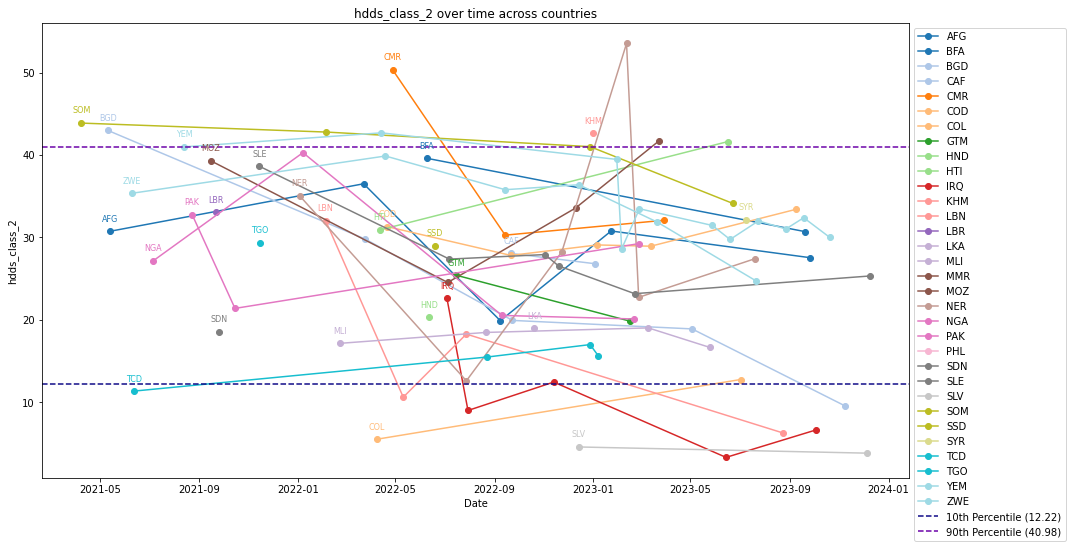

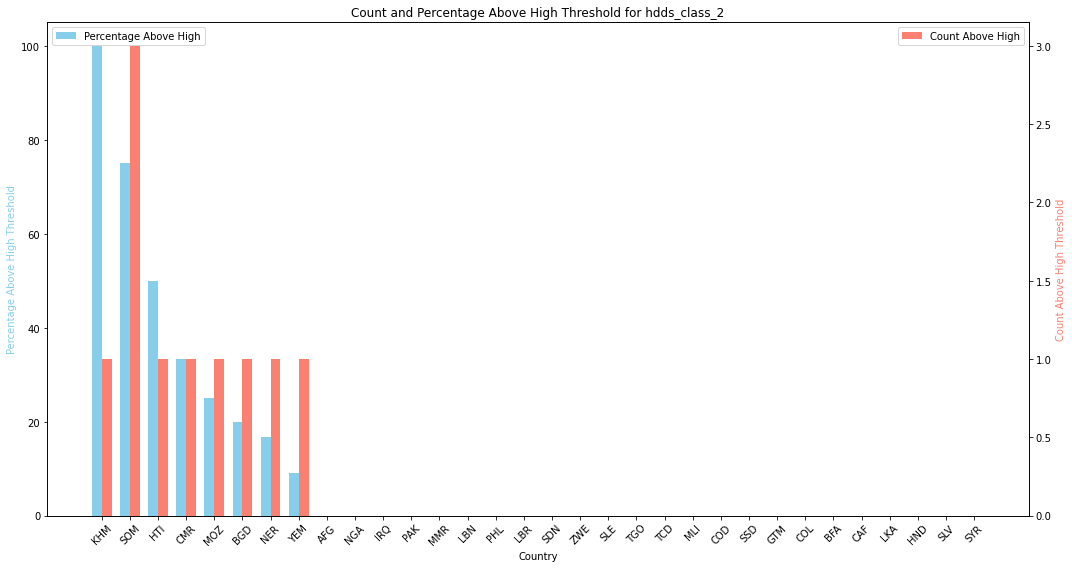

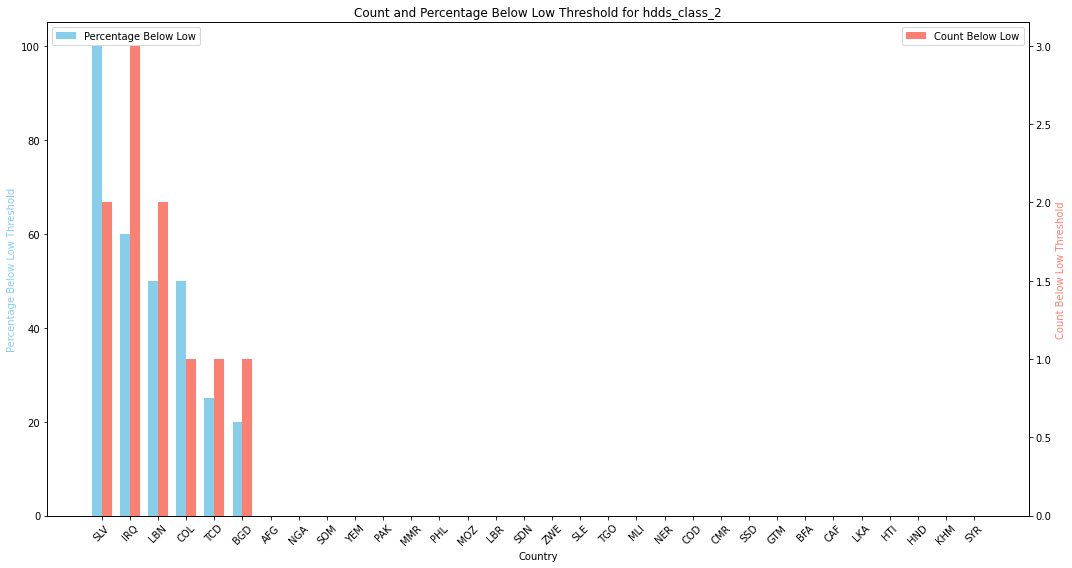

hdds_class_3
Percentage of households that resulted with Household Dietary Diversity Score(HDDS) - High dietary diversity


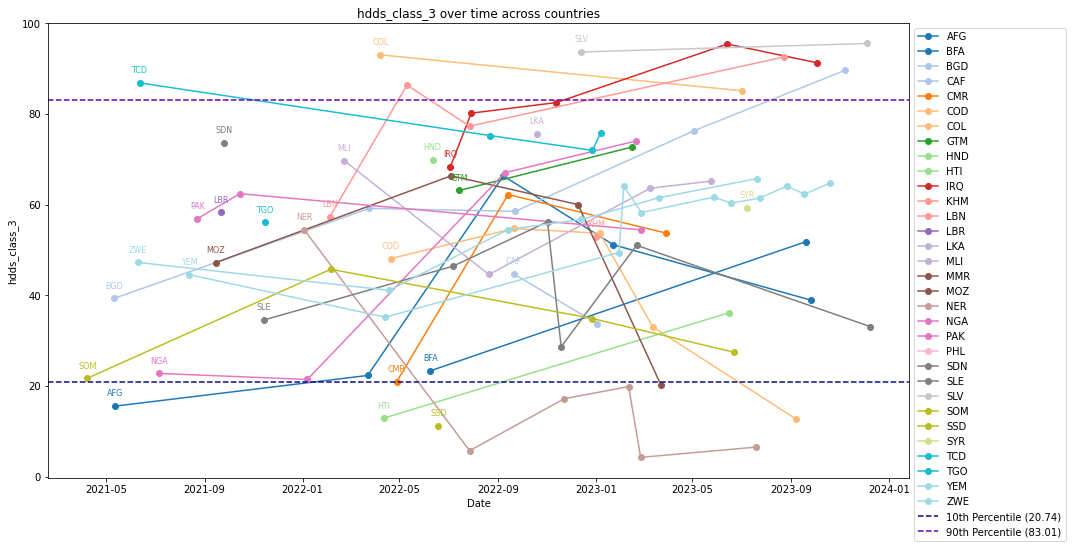

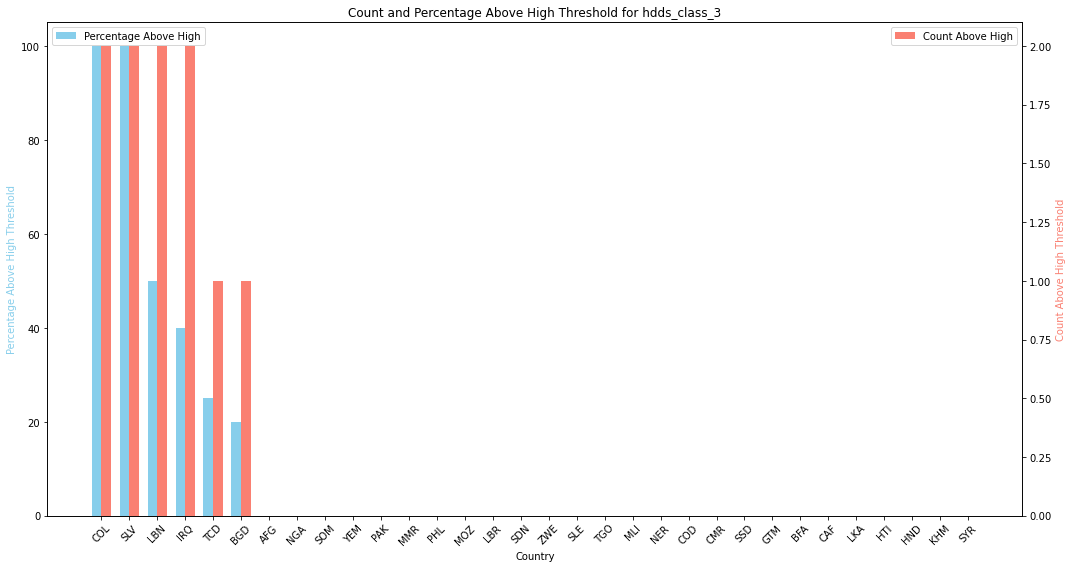

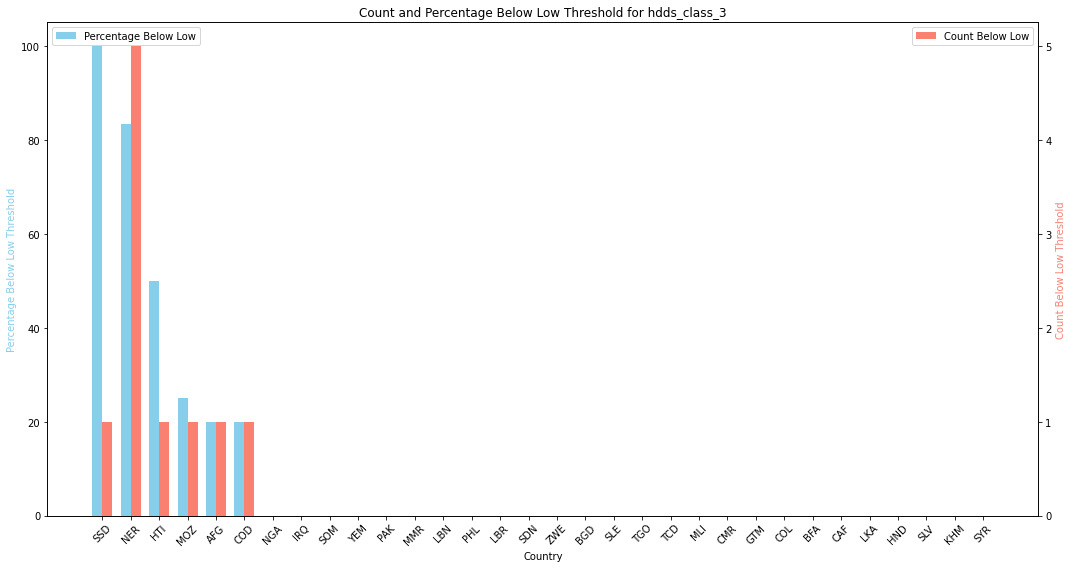

lcsi_0
Percentage of households that resulted with Livelihood Coping Strategy Index(LCSI) - No coping strategies


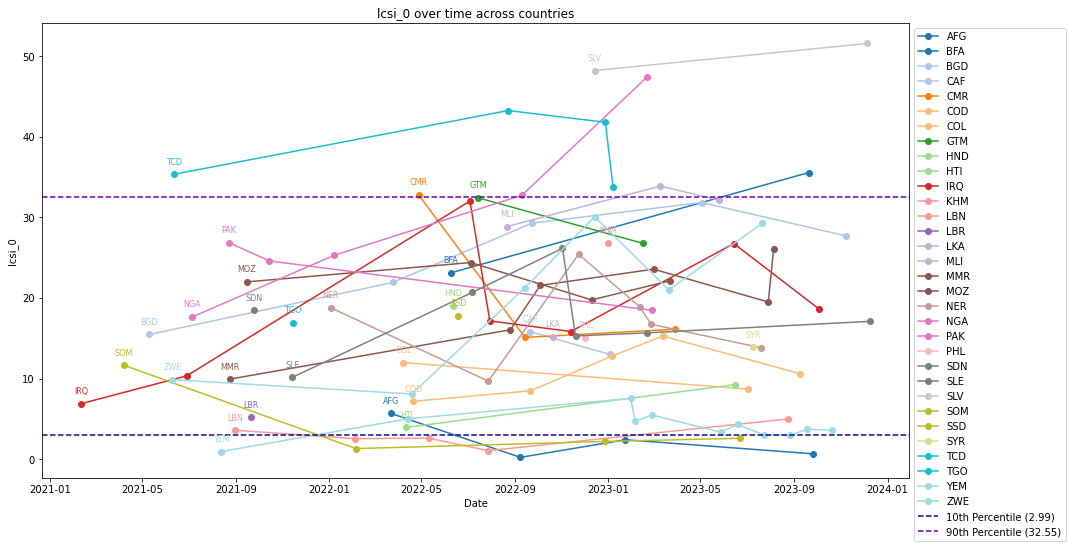

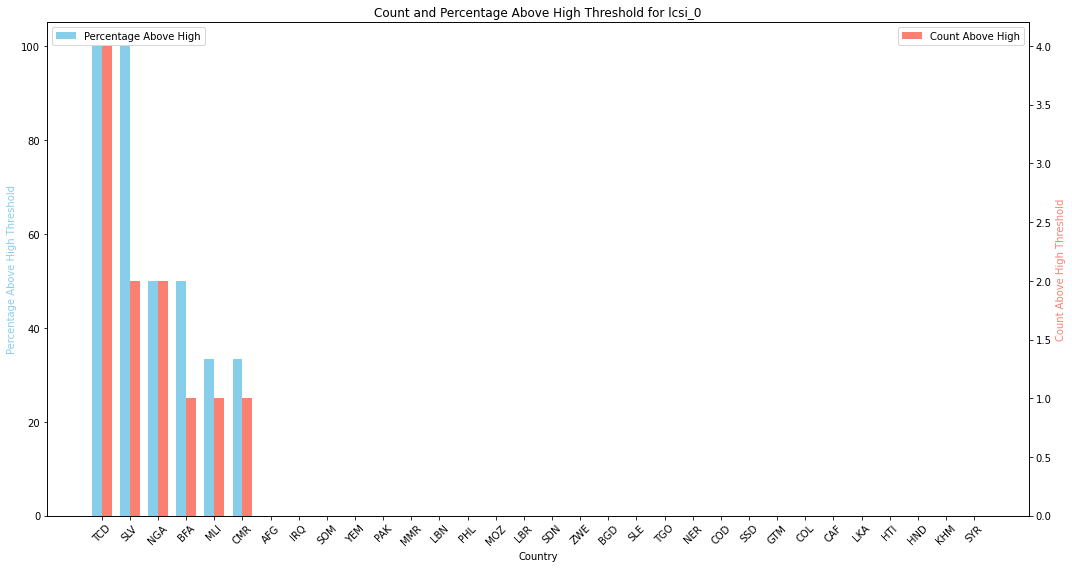

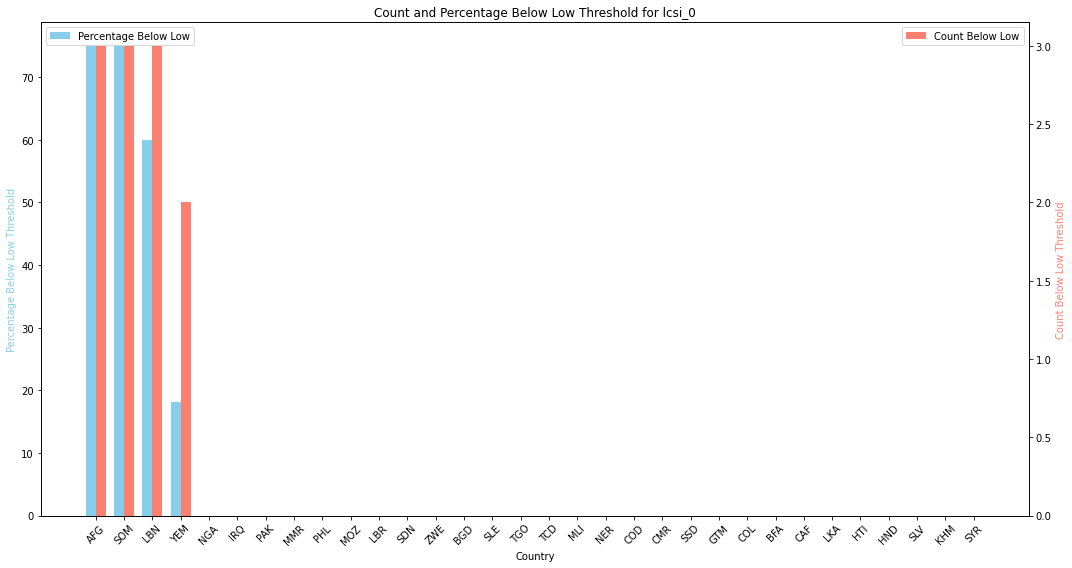

lcsi_1
Percentage of households that resulted with Livelihood Coping Strategy Index(LCSI) - Stress


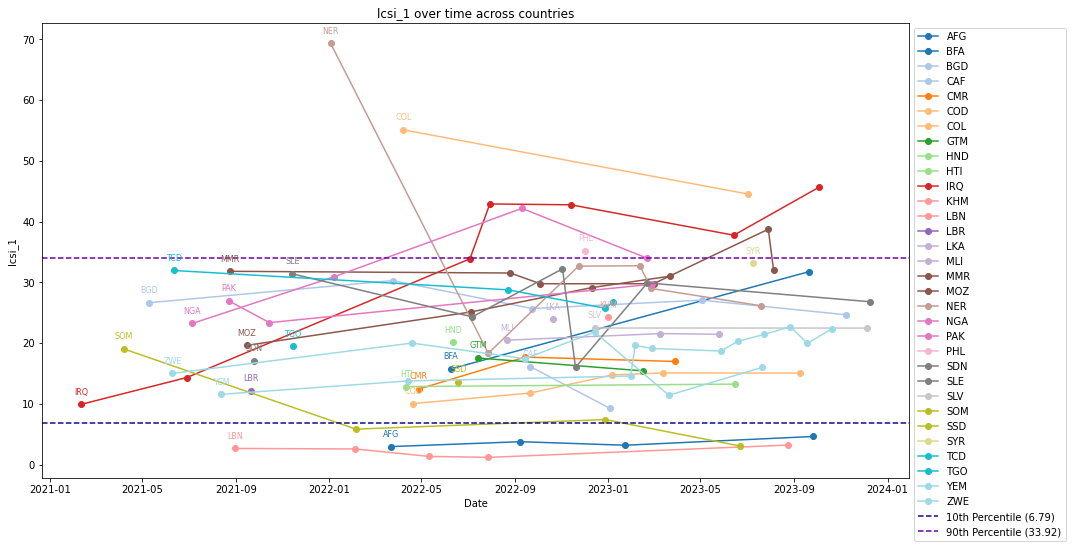

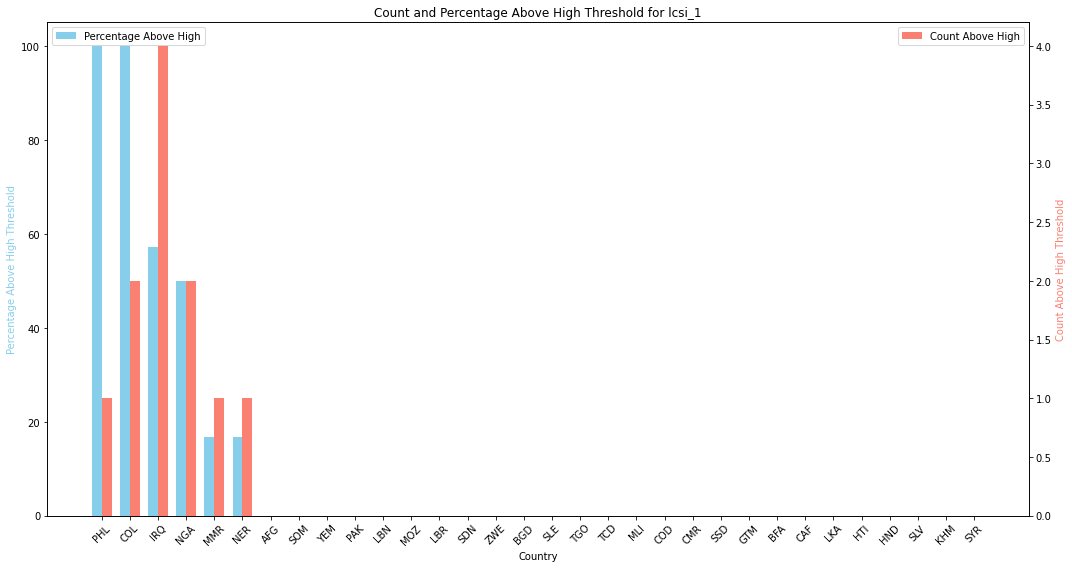

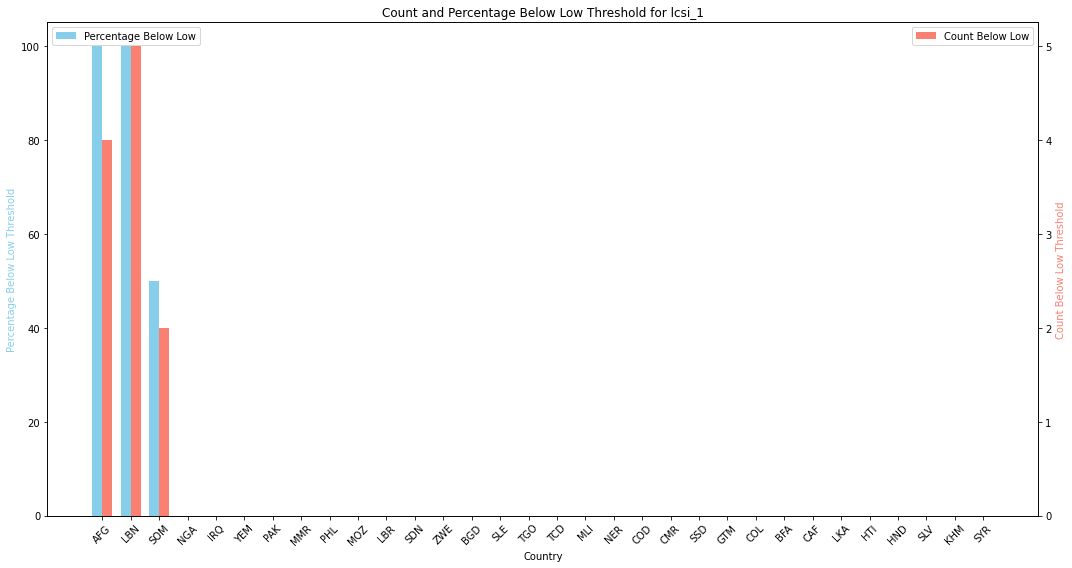

lcsi_2
Percentage of households that resulted with Livelihood Coping Strategy Index(LCSI) - Crisis


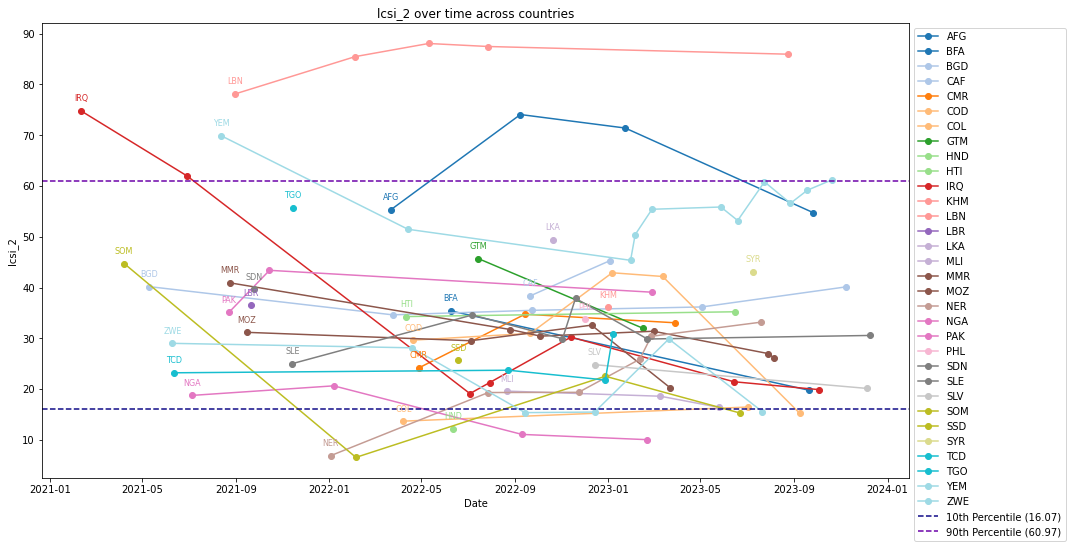

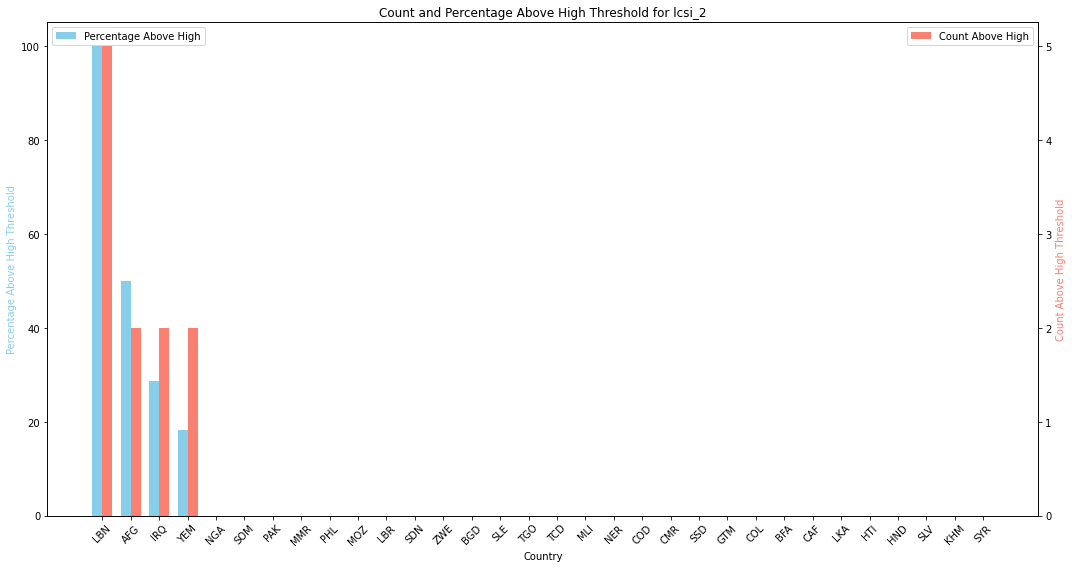

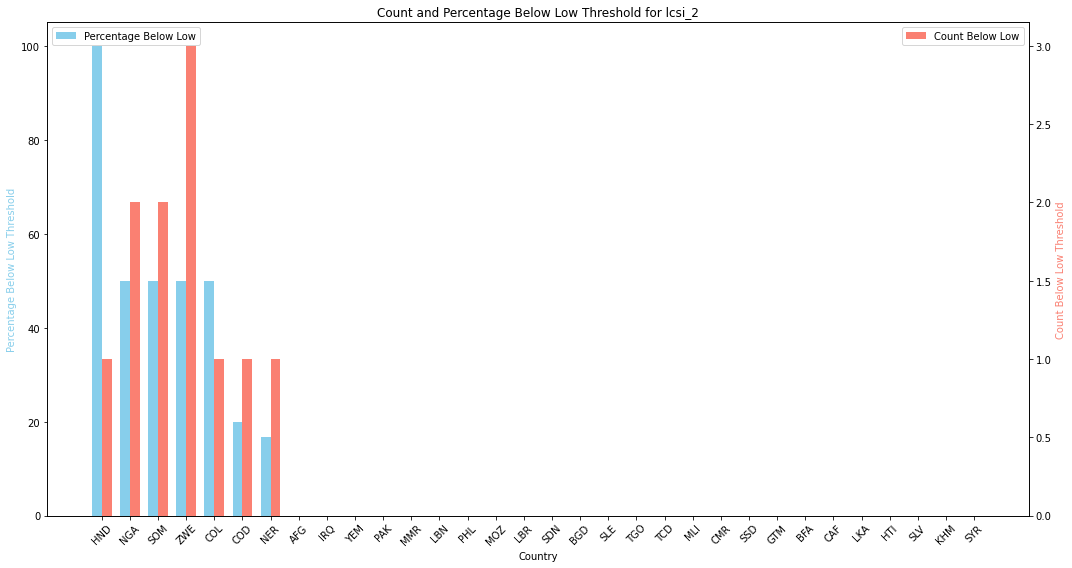

lcsi_3
Percentage of households that resulted with Livelihood Coping Strategy Index(LCSI) - Emergency


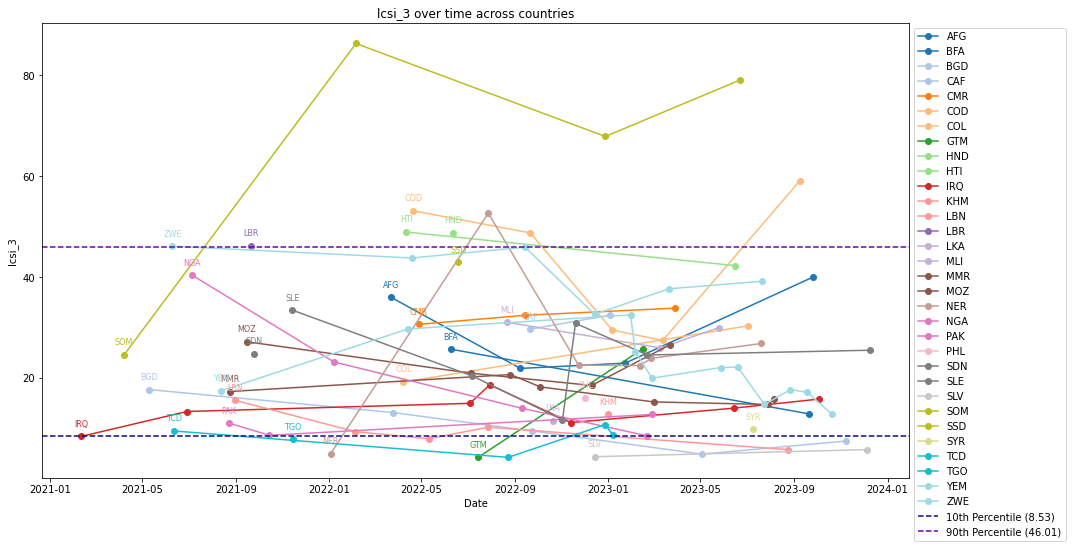

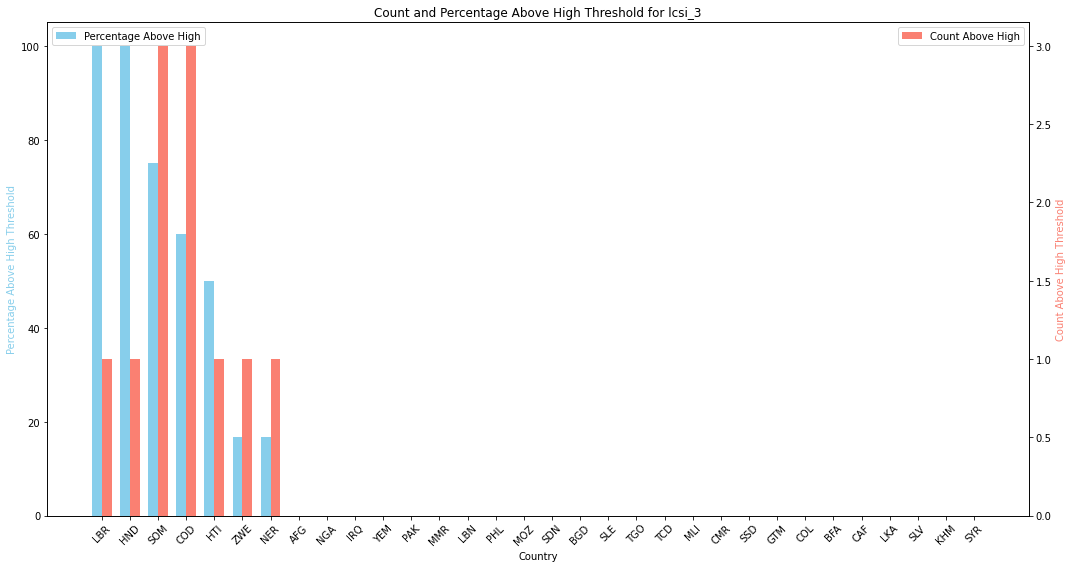

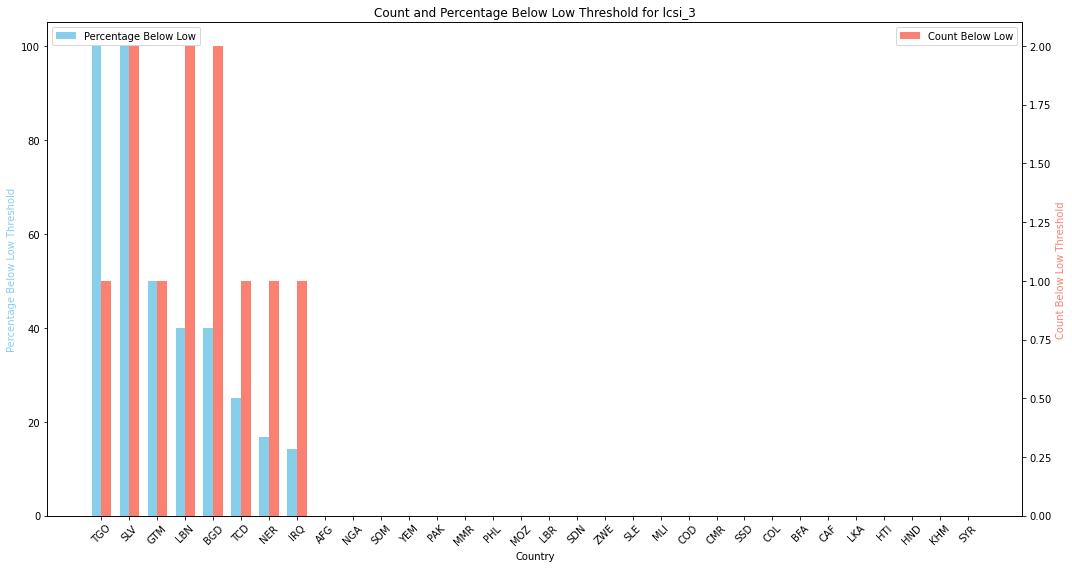

need_cash
Percentage of households that, for question asked: 'What are your household's greatest needs for assistance for agricultural activities [including crop, livestock or fisheries/aquaculture activities] over the next 3 to 6 months?', have answered: 'Cash'. 


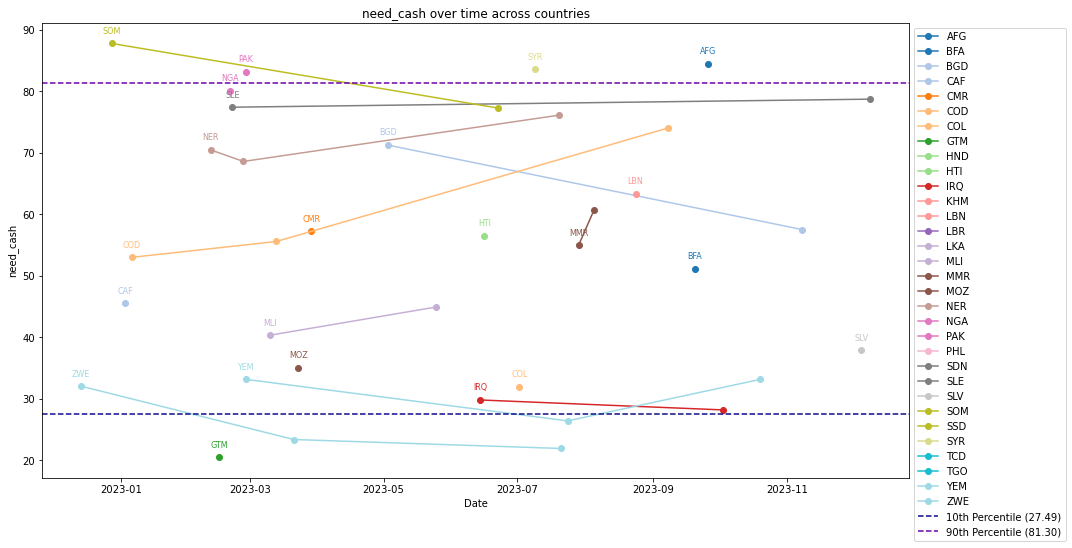

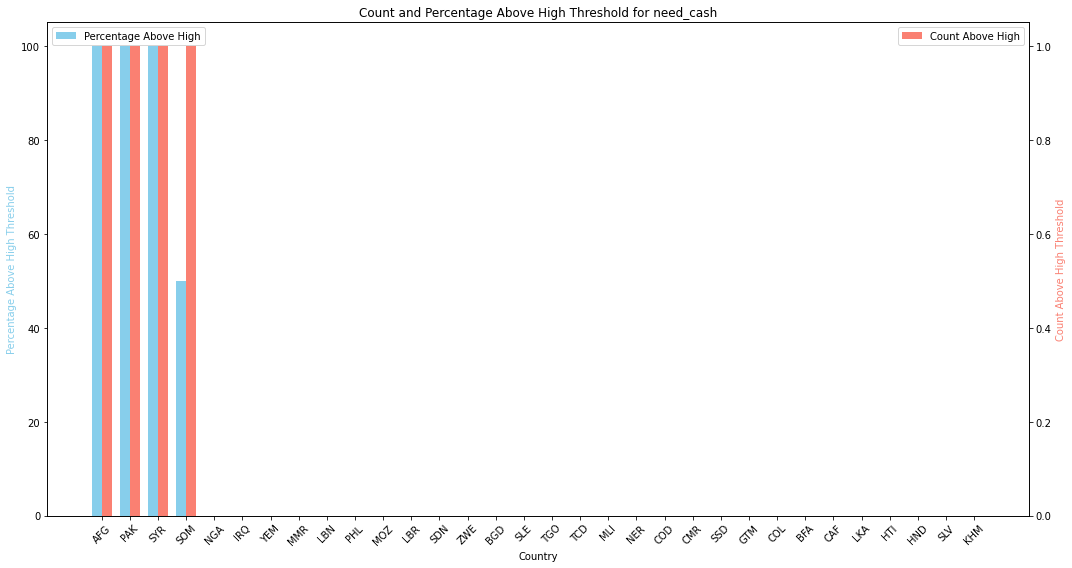

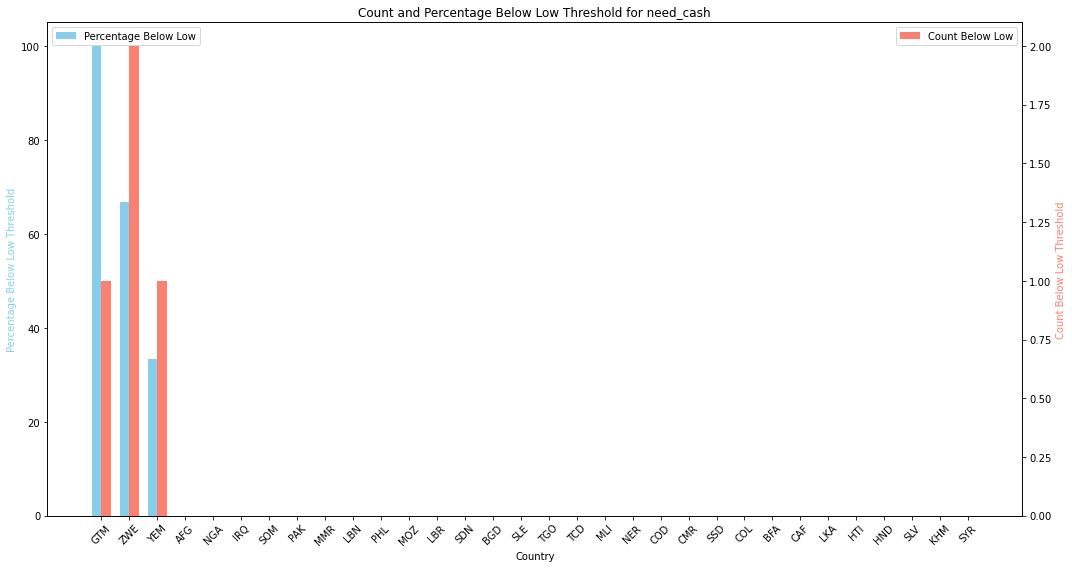

need_received_none
Percentage of households that, for question asked: 'Has your household received any assistance in the last 3 months, and if so, which kind?', have answered: 'No assistance received'. 


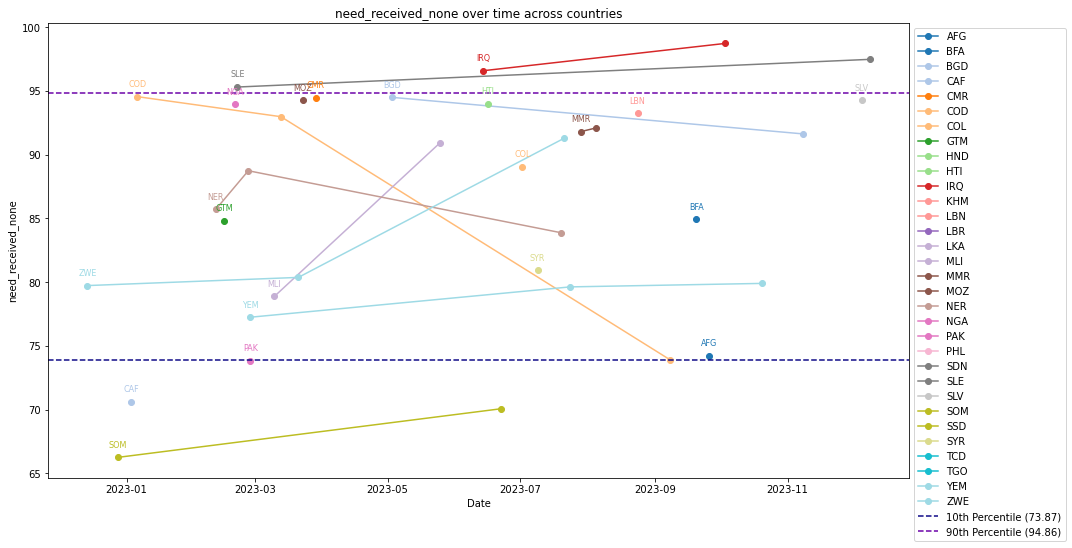

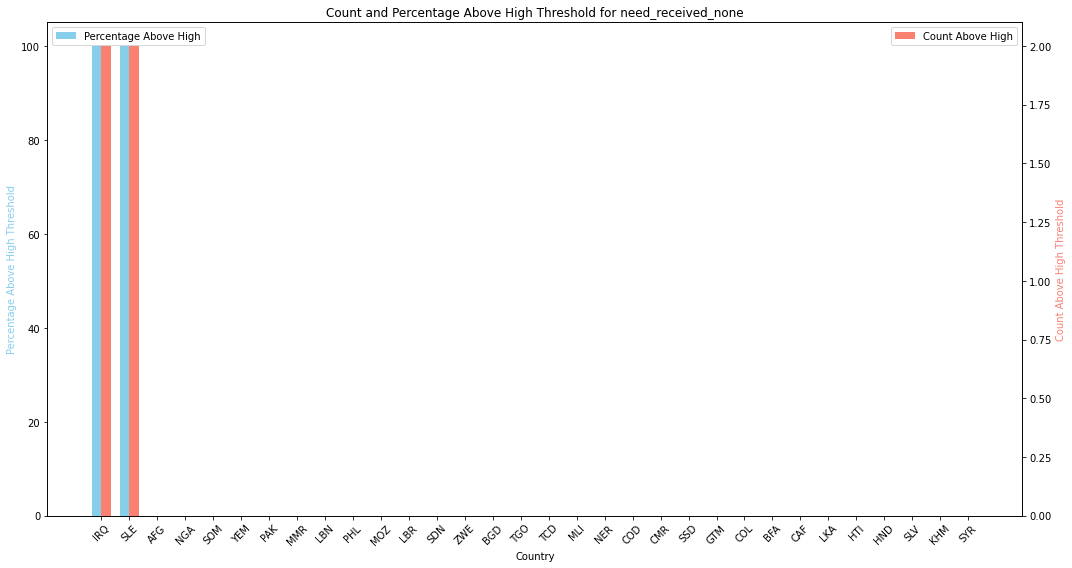

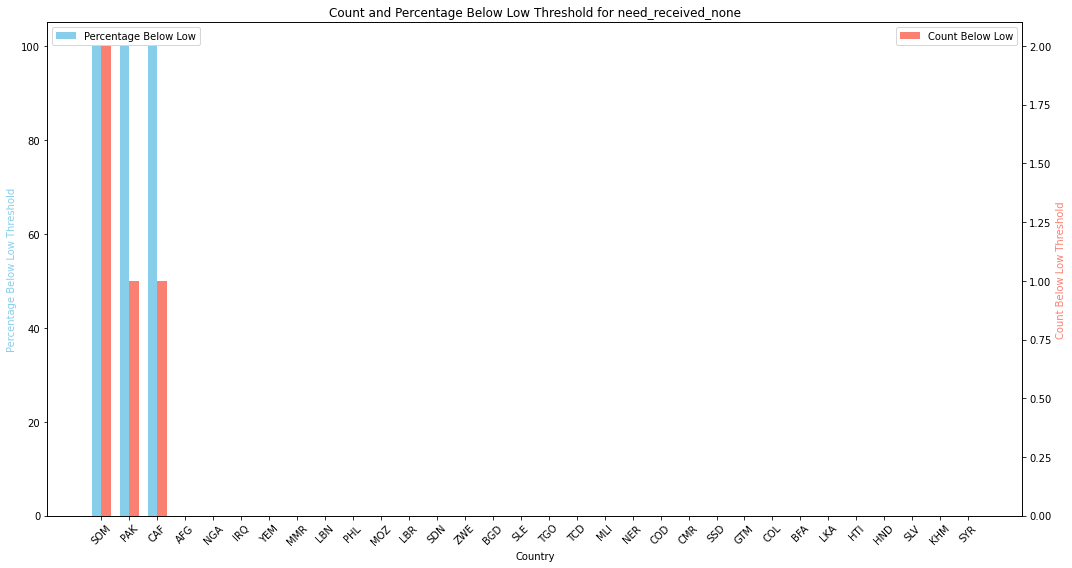

assistance_quality_1
Percentage of households that, for question asked: 'Were you satisfied with the quality of the assistance provided?', have answered: 'Yes'. 


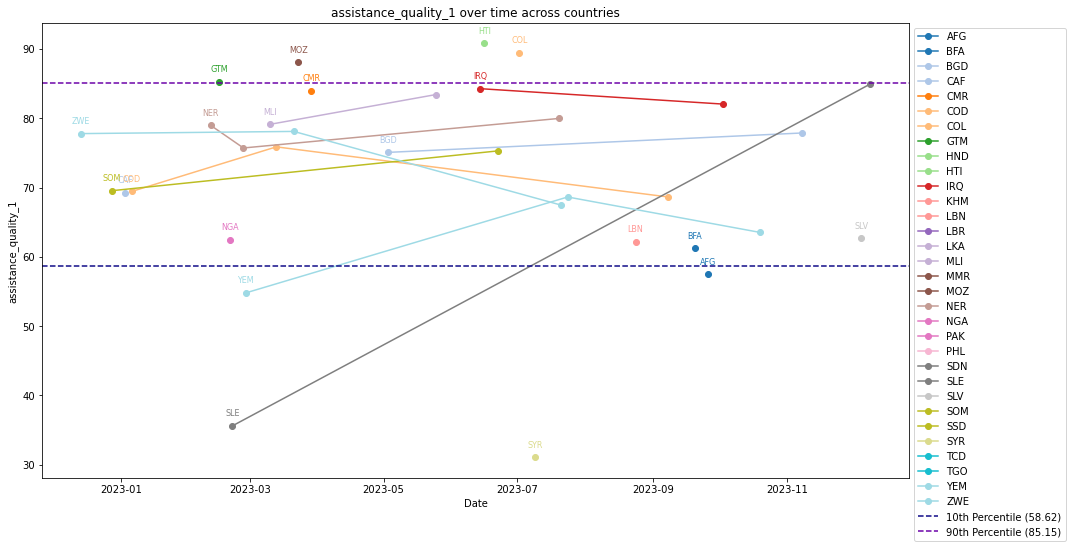

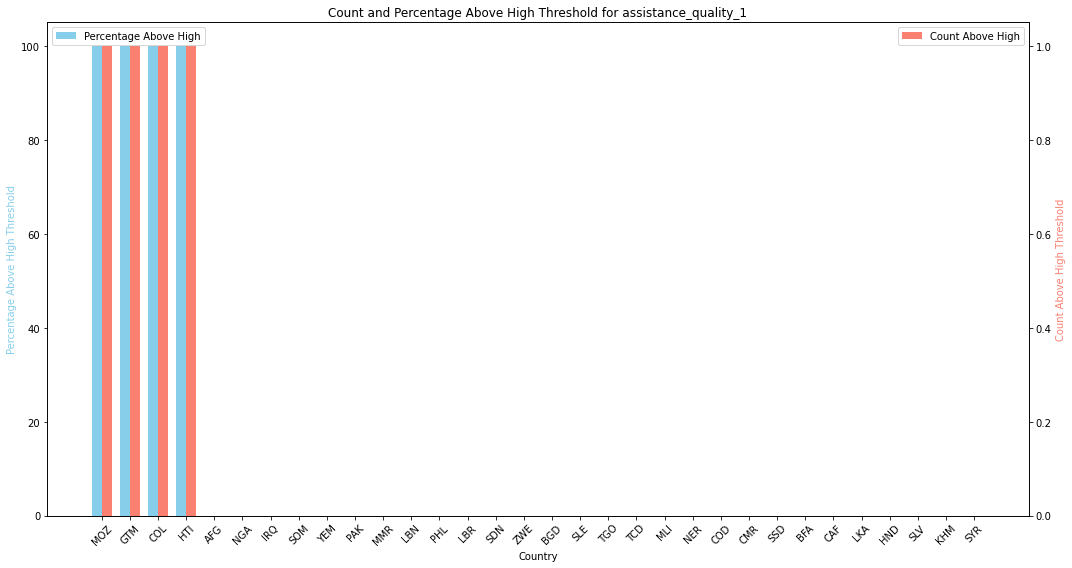

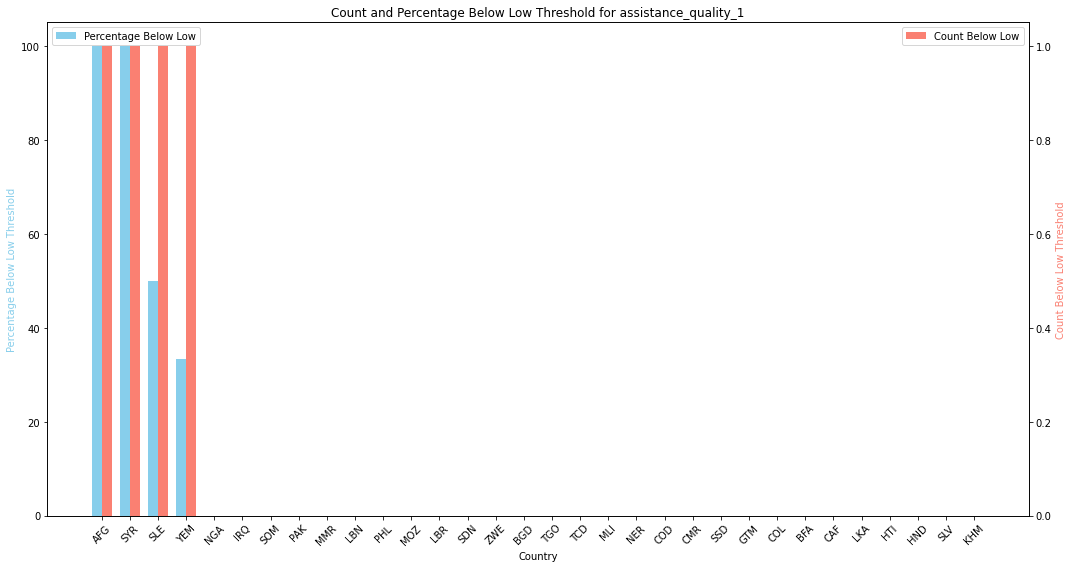

assistance_quality_2
Percentage of households that, for question asked: 'Were you satisfied with the quality of the assistance provided?', have answered: 'No - not received on time'. 


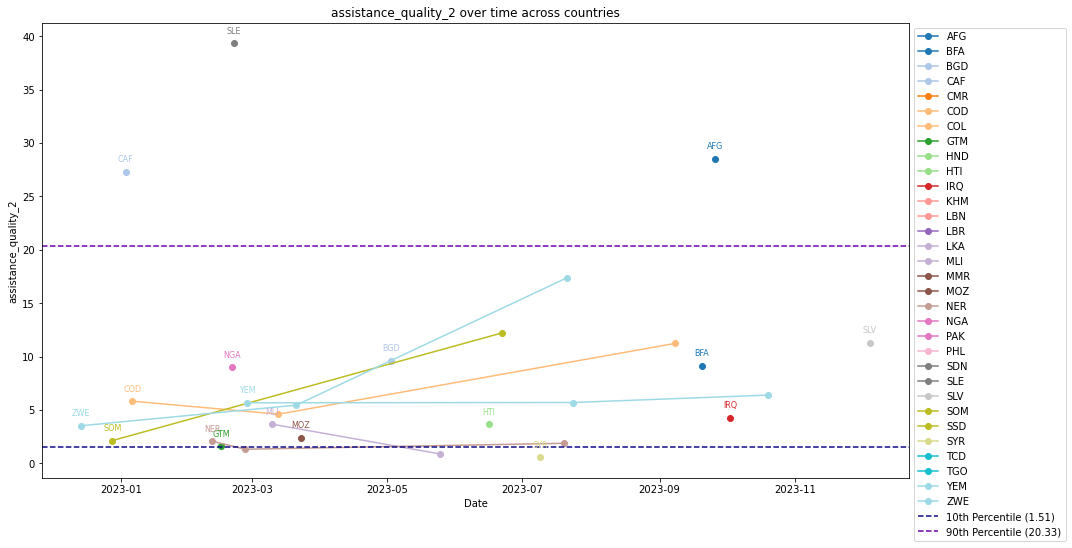

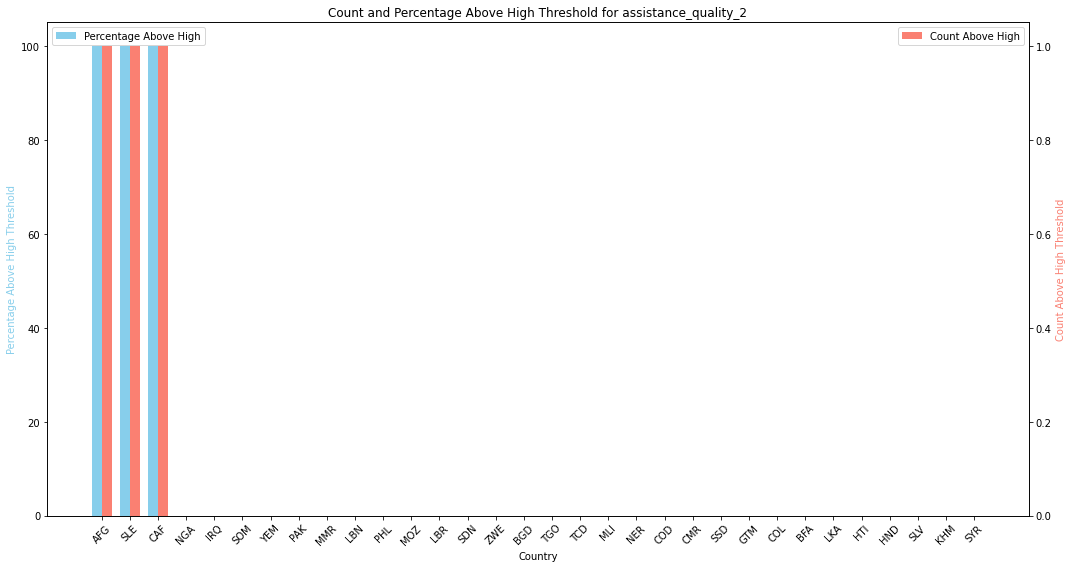

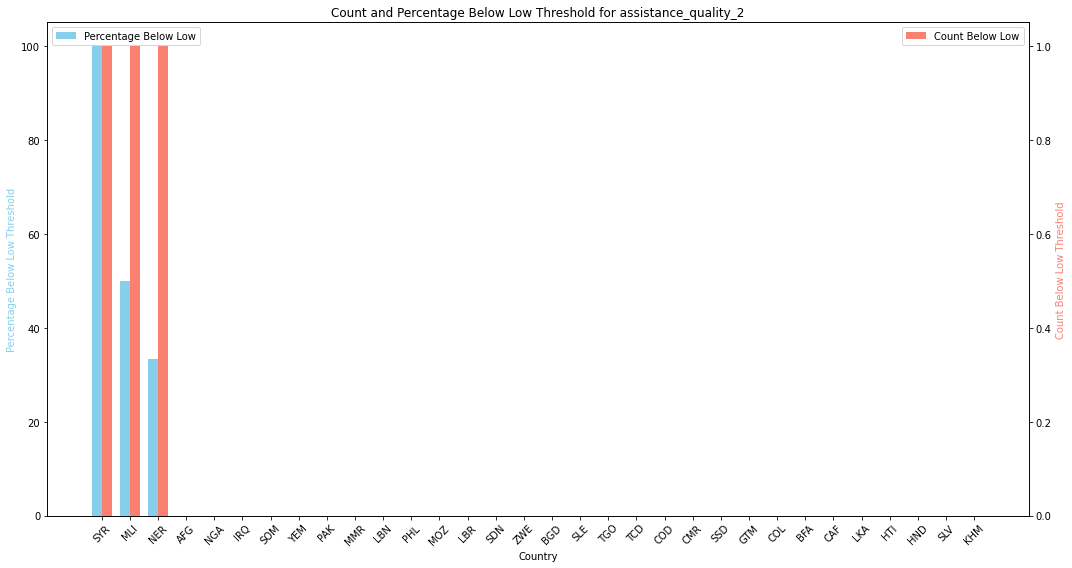

assistance_quality_3
Percentage of households that, for question asked: 'Were you satisfied with the quality of the assistance provided?', have answered: 'No - did not meet my needs'. 


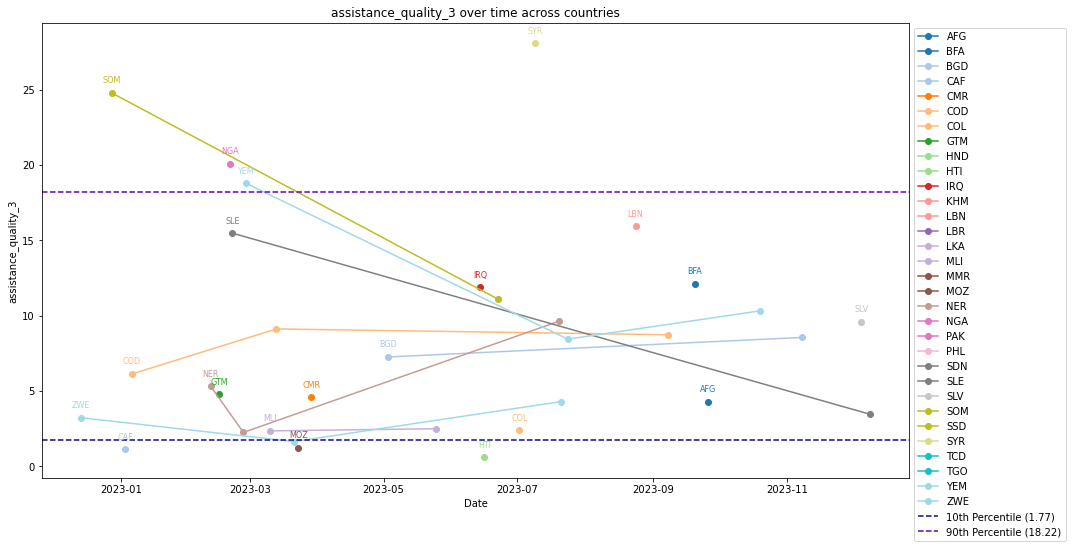

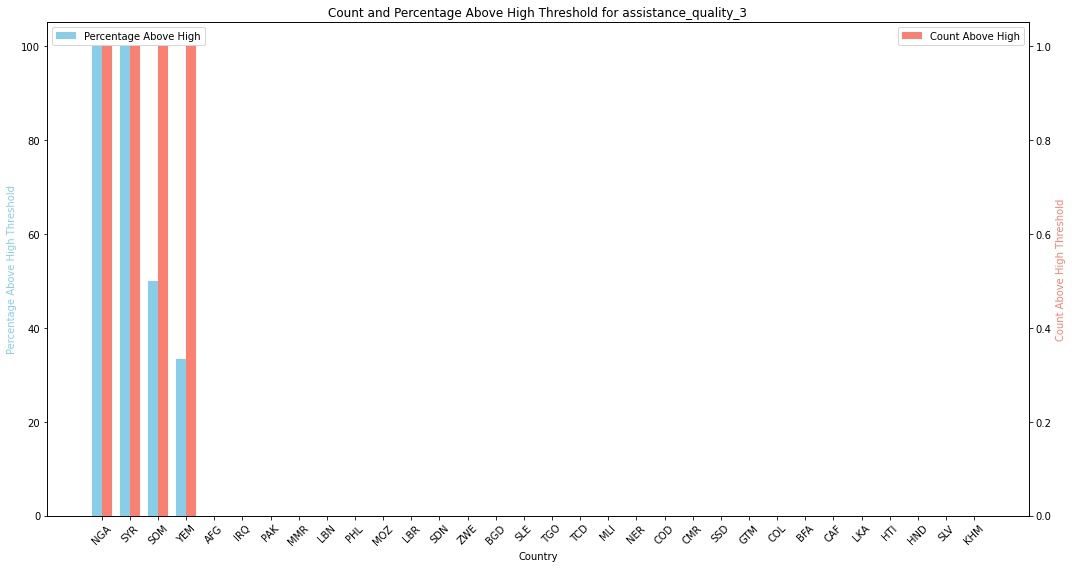

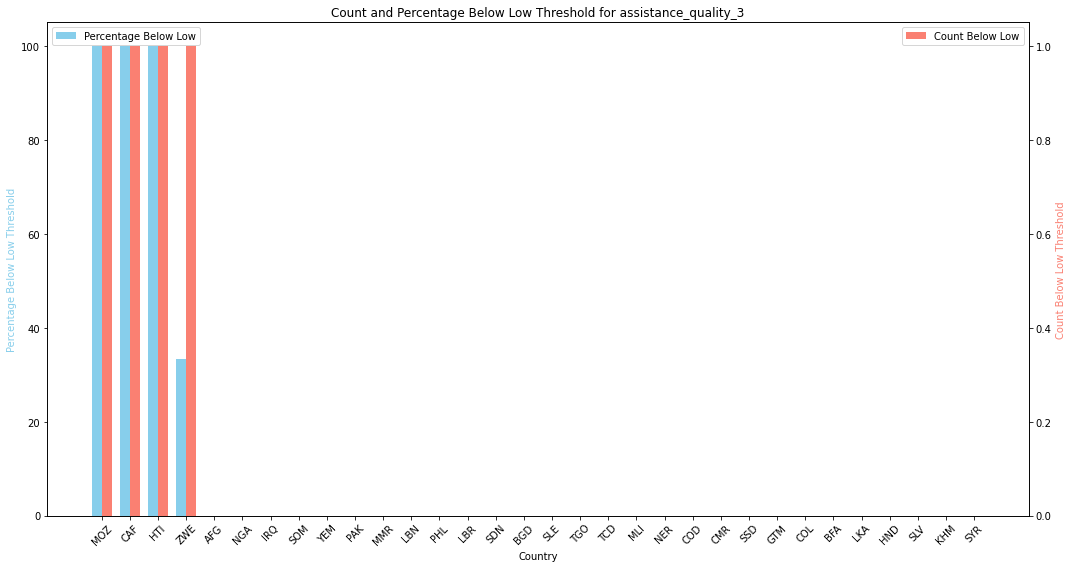

assistance_quality_4
Percentage of households that, for question asked: 'Were you satisfied with the quality of the assistance provided?', have answered: 'No - quantity was not sufficient'. 


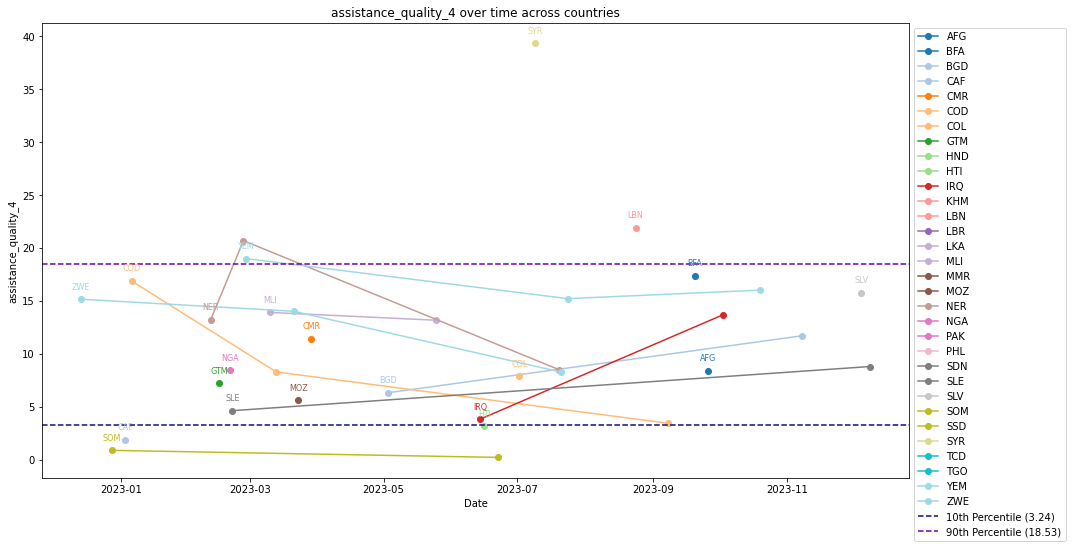

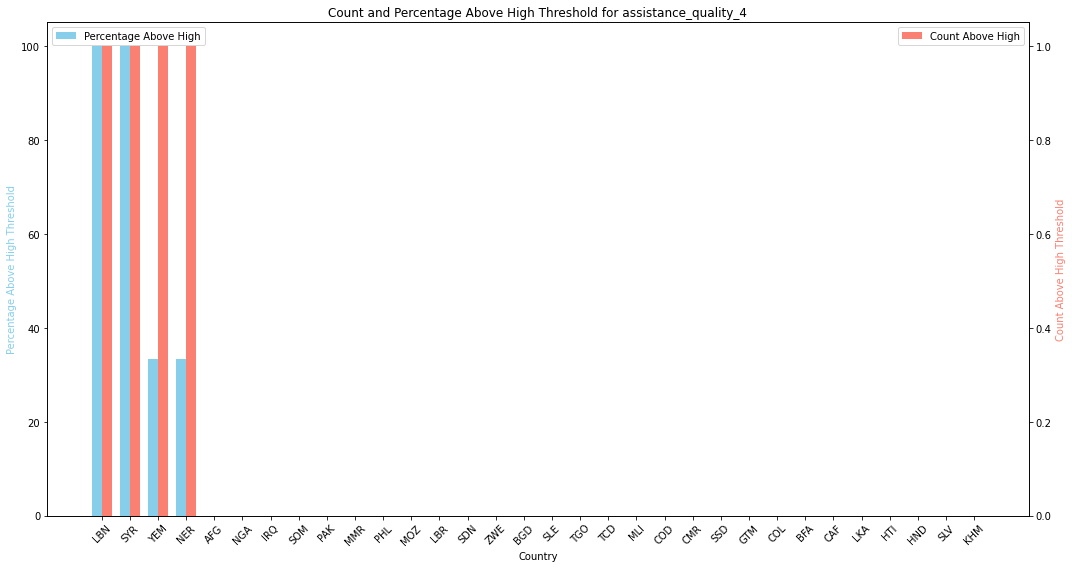

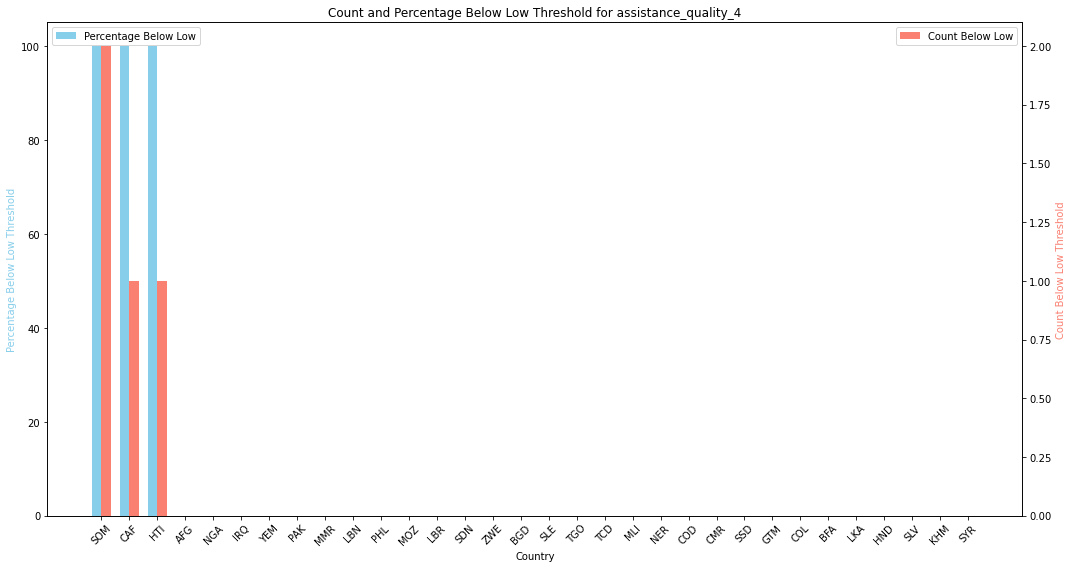

assistance_quality_5
Percentage of households that, for question asked: 'Were you satisfied with the quality of the assistance provided?', have answered: 'No - there was a problem with the provider'. 


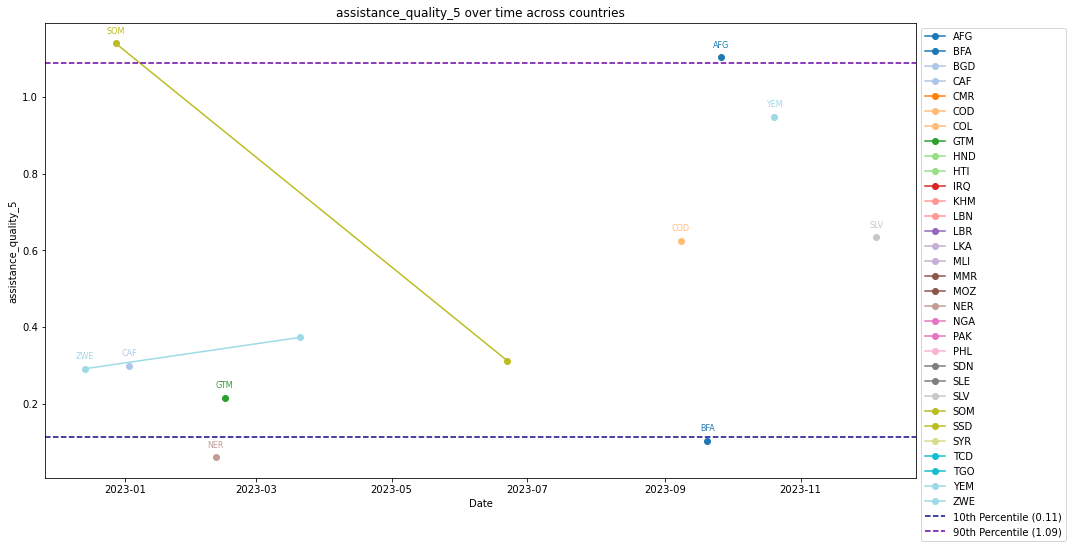

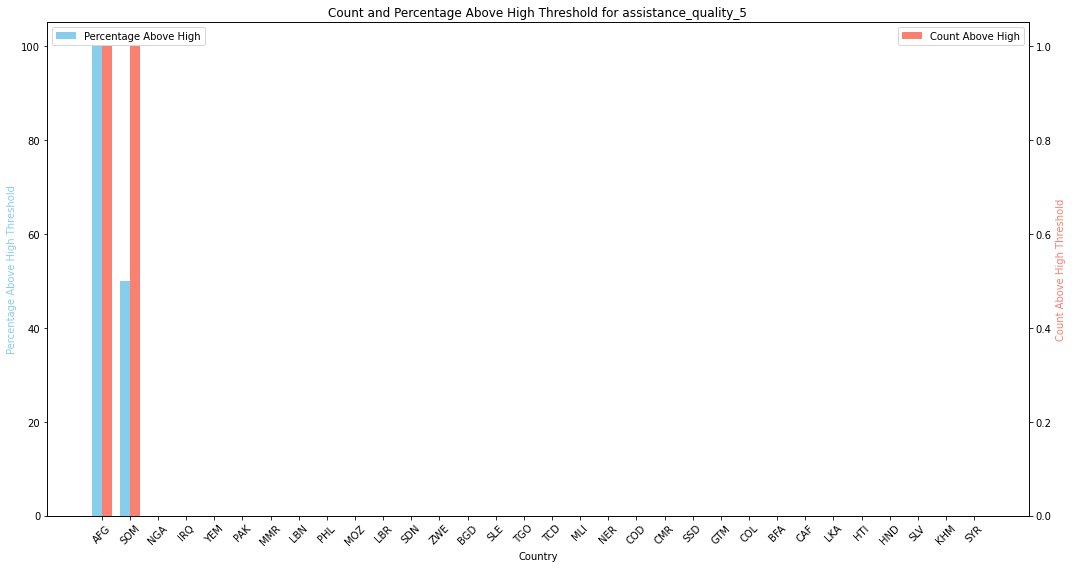

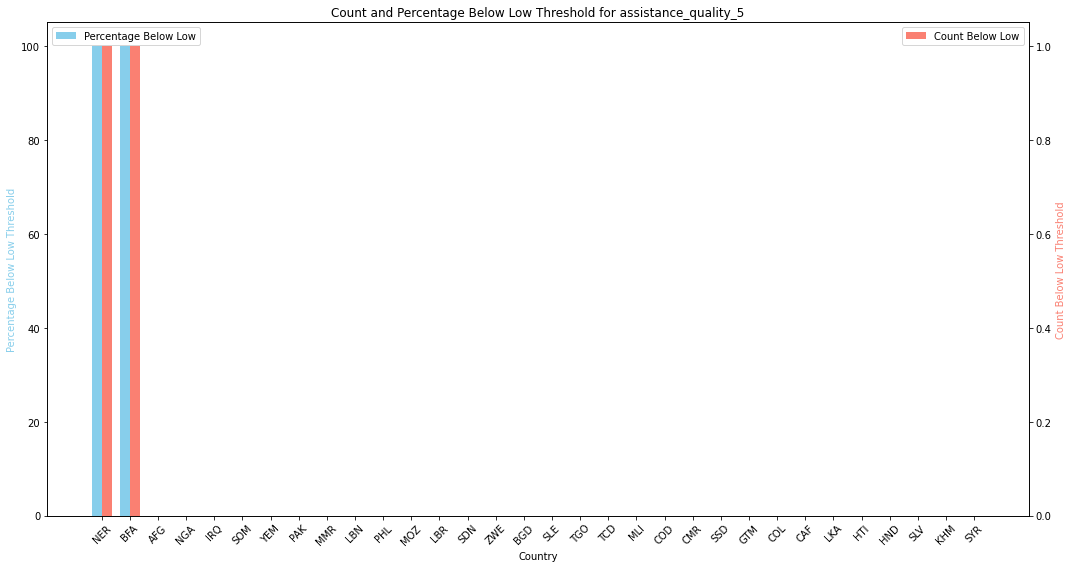

assistance_quality_6
Percentage of households that, for question asked: 'Were you satisfied with the quality of the assistance provided?', have answered: 'No - there was a malfunction of the in-kind assistance provided (e.g. poor quality tools)'. 


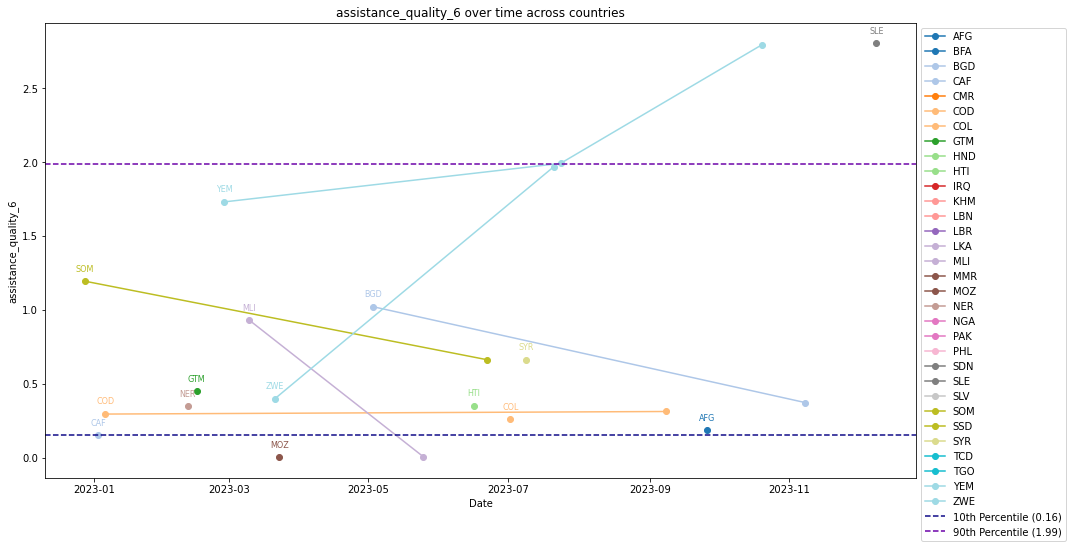

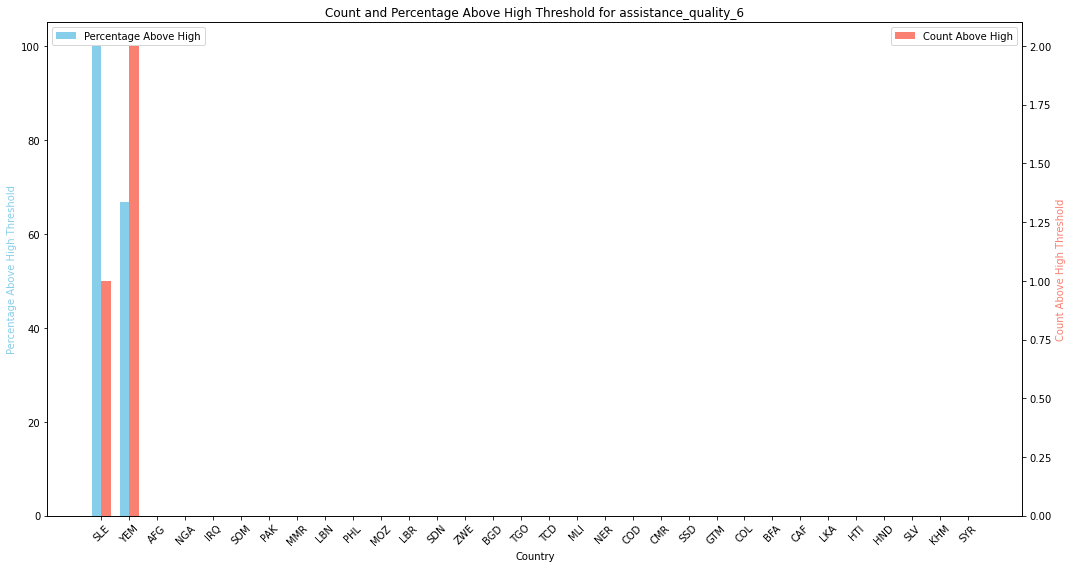

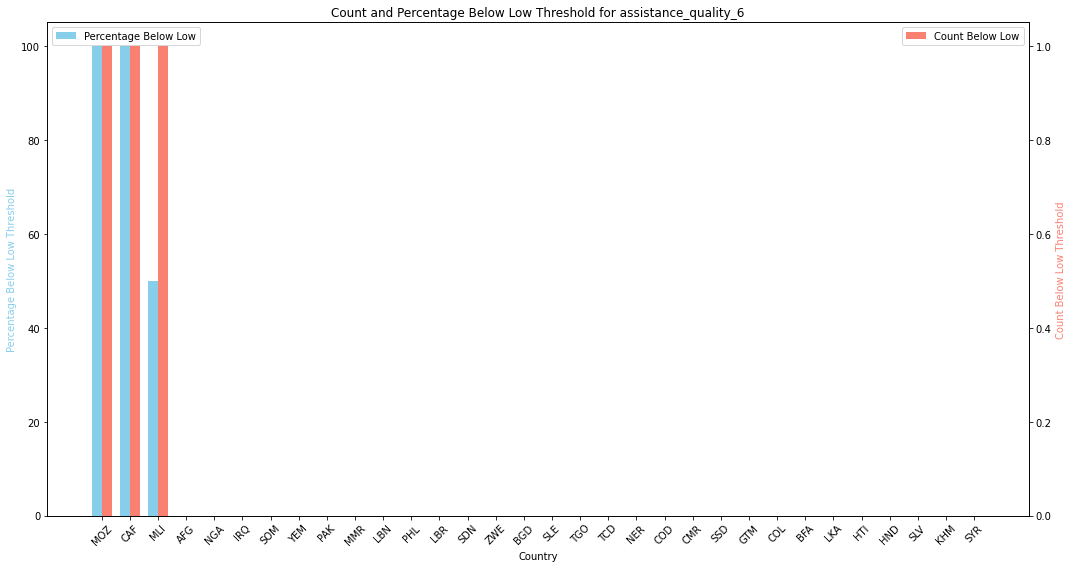

shock_anyshock


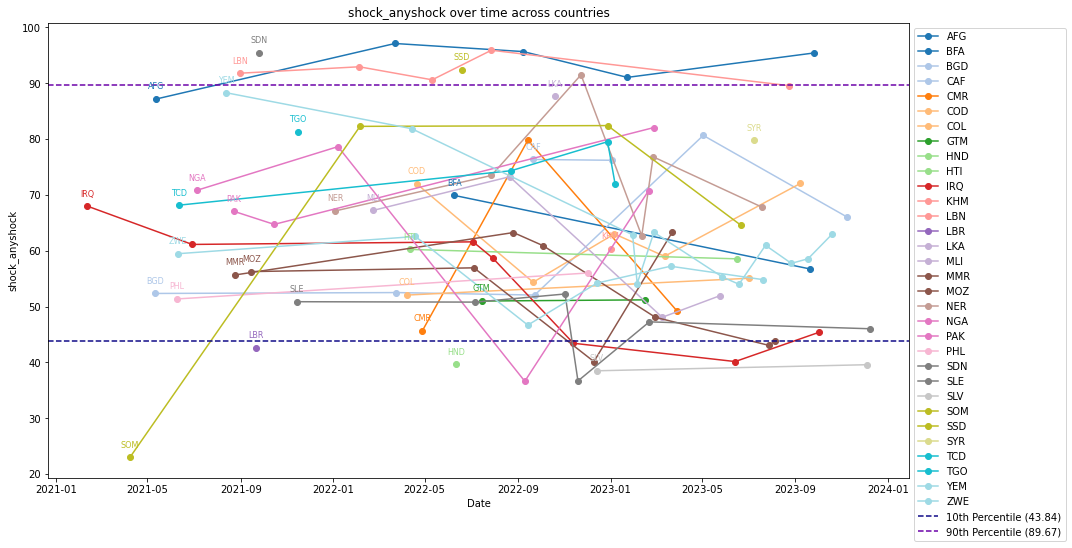

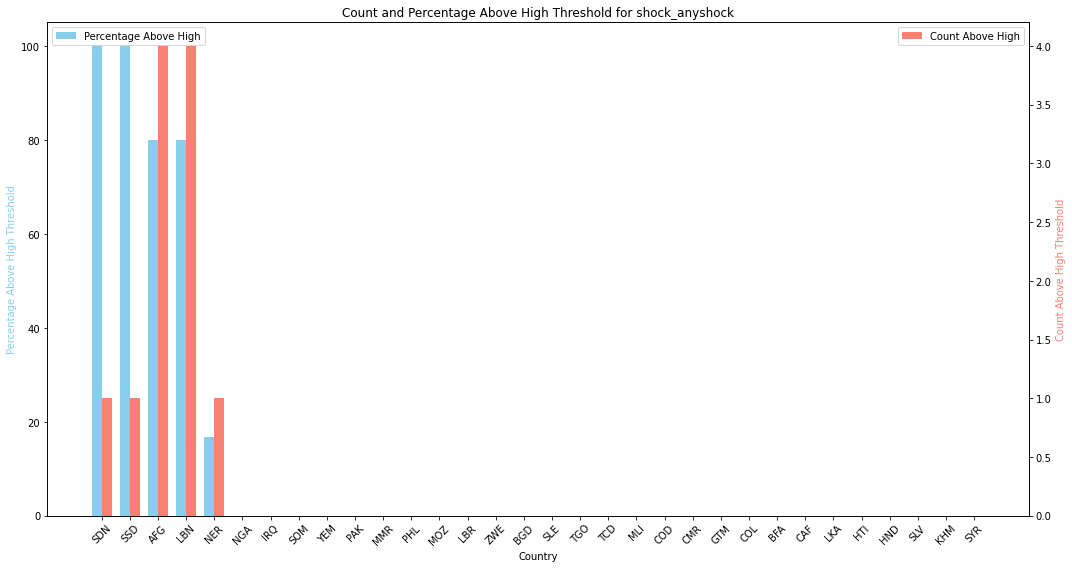

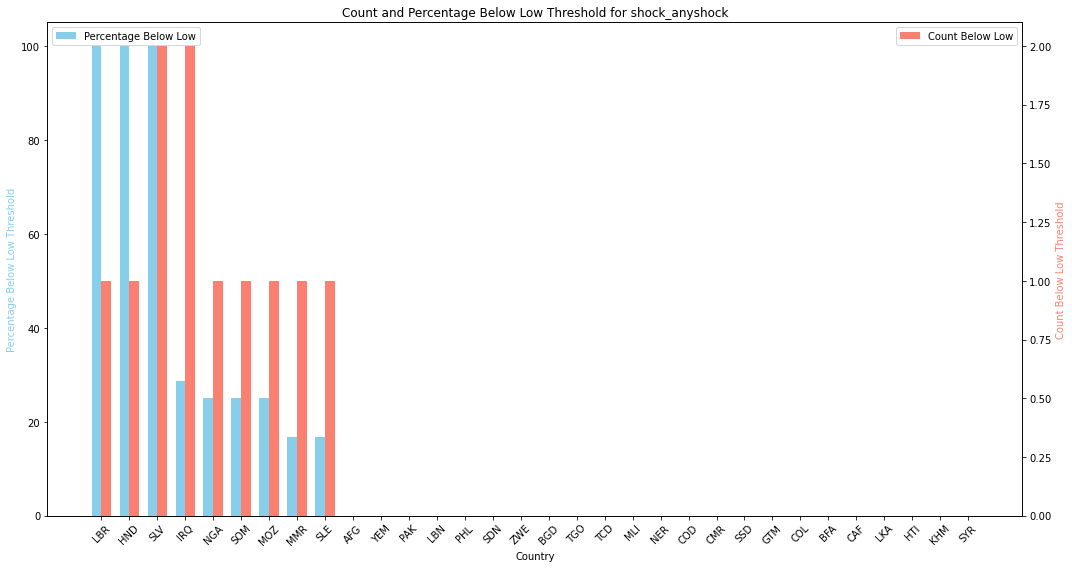

shock_higherfoodprices
Percentage of households that, for question asked: 'Has your household or community faced any particular disaster or crisis affecting your household's ability to raise an income and/or to produce food for self consumption in the last 3 months, and if so, which one(s)? ', have answered: 'Unusually high food prices'. 


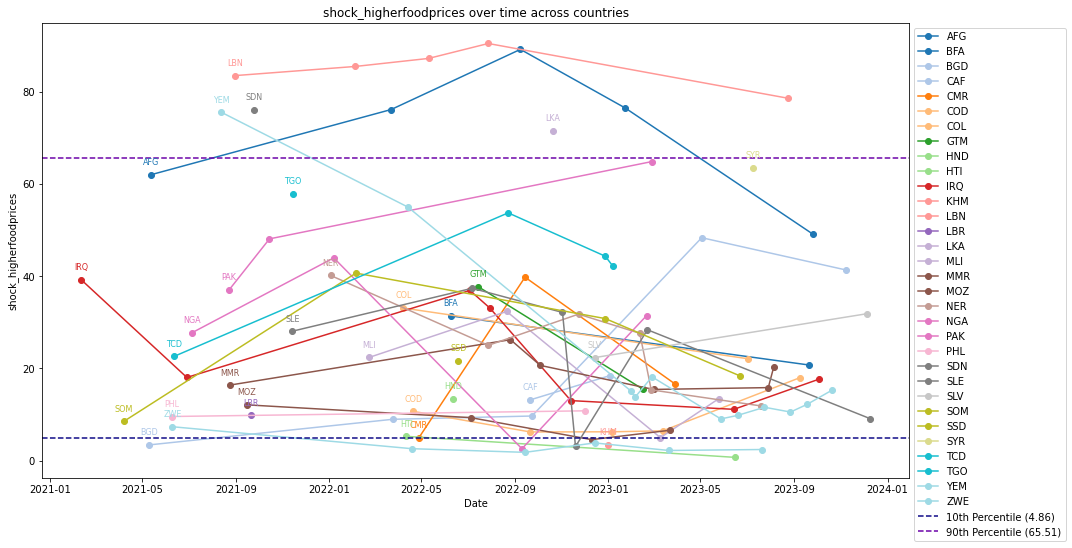

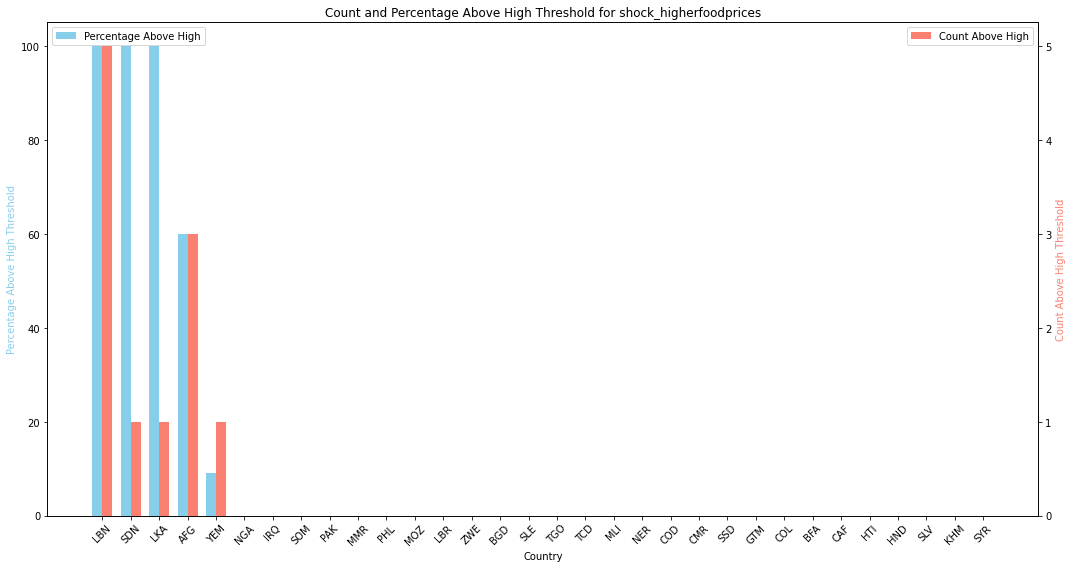

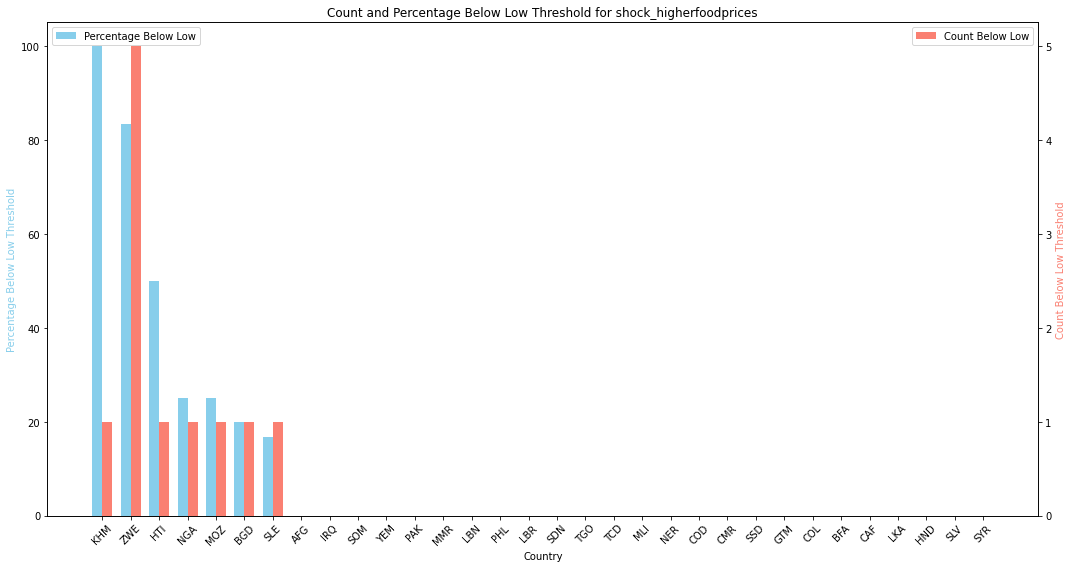

shock_higherfuelprices
Percentage of households that, for question asked: 'Has your household or community faced any particular disaster or crisis affecting your household's ability to raise an income and/or to produce food for self consumption in the last 3 months, and if so, which one(s)? ', have answered: 'Unusually high fuel prices or transport prices'. 


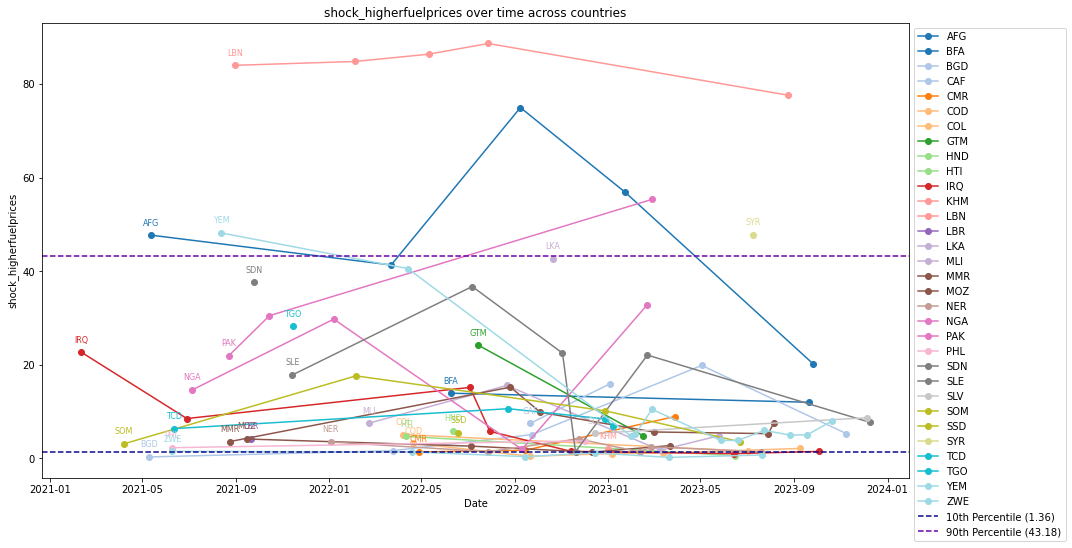

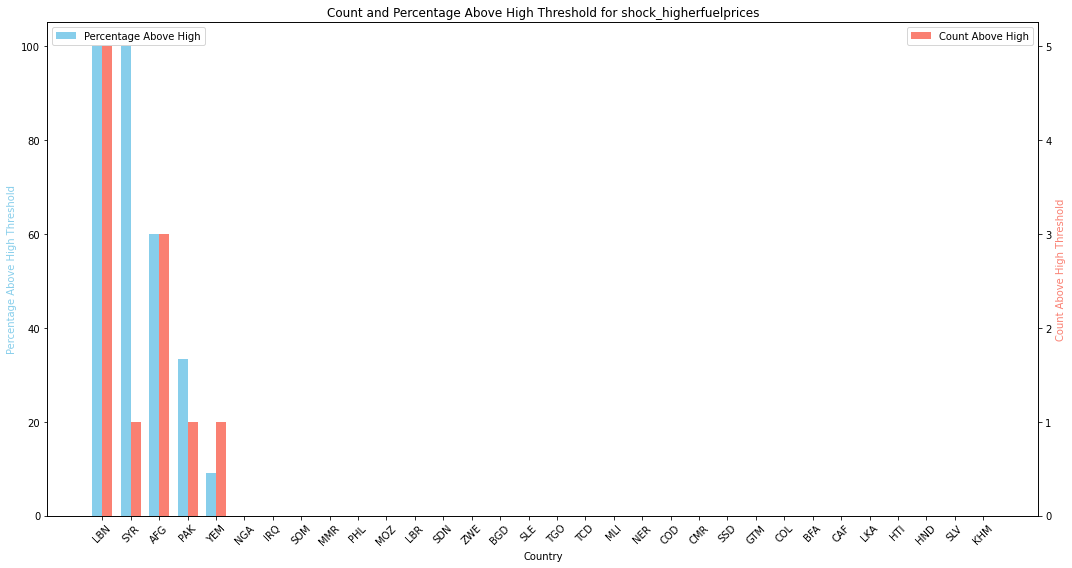

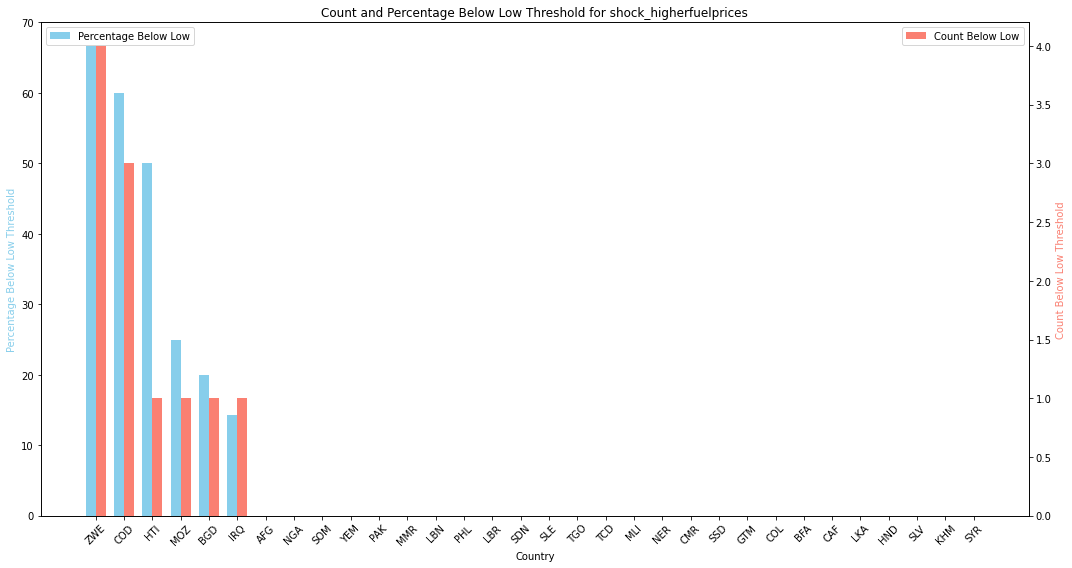

shock_plantdisease
Percentage of households that, for question asked: 'Has your household or community faced any particular disaster or crisis affecting your household's ability to raise an income and/or to produce food for self consumption in the last 3 months, and if so, which one(s)? ', have answered: 'Plant disease'. 


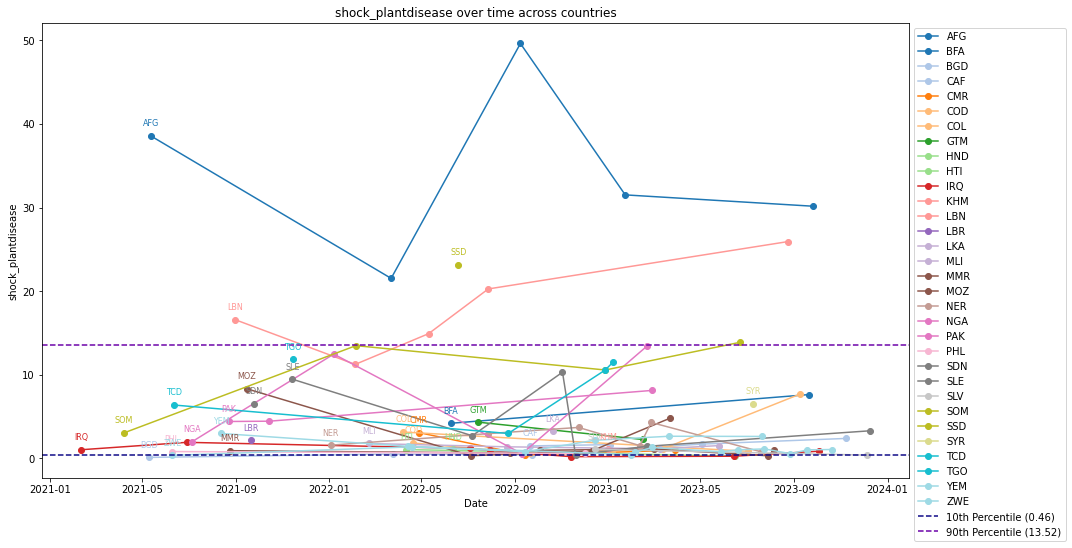

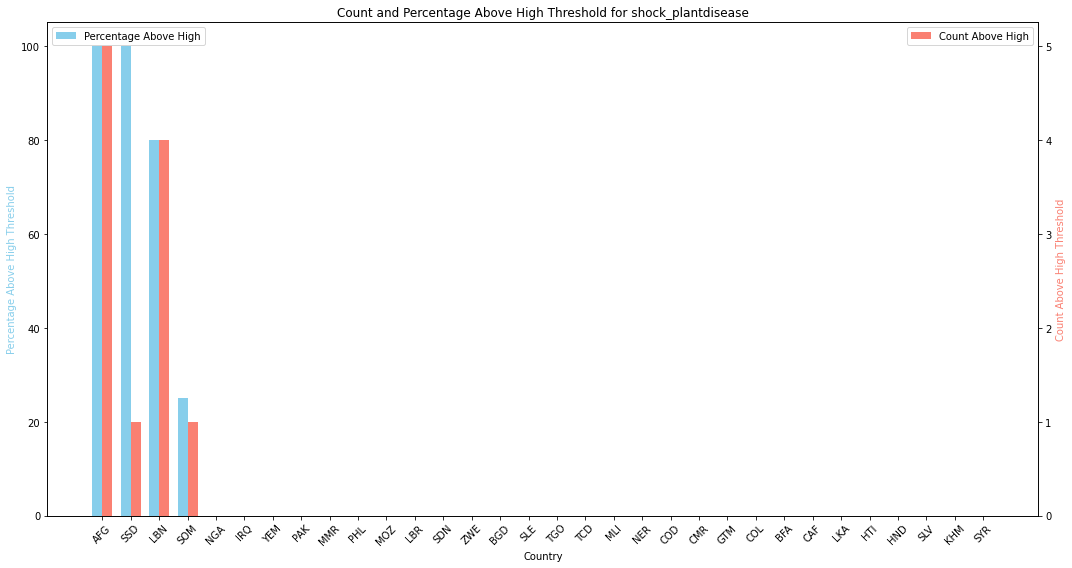

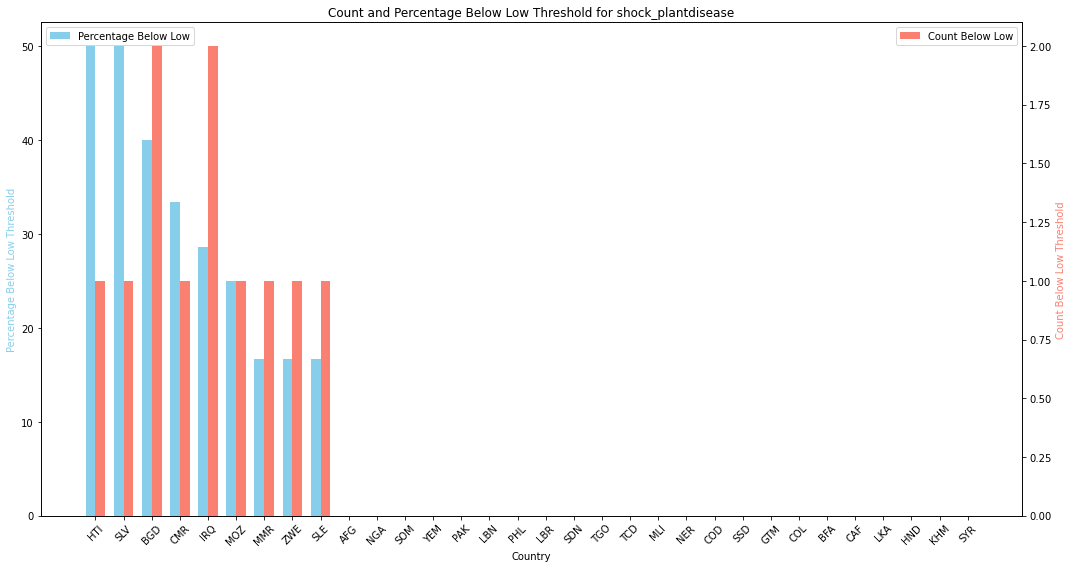

shock_animaldisease
Percentage of households that, for question asked: 'Has your household or community faced any particular disaster or crisis affecting your household's ability to raise an income and/or to produce food for self consumption in the last 3 months, and if so, which one(s)? ', have answered: 'Animal disease (affecting many animals) or death'. 


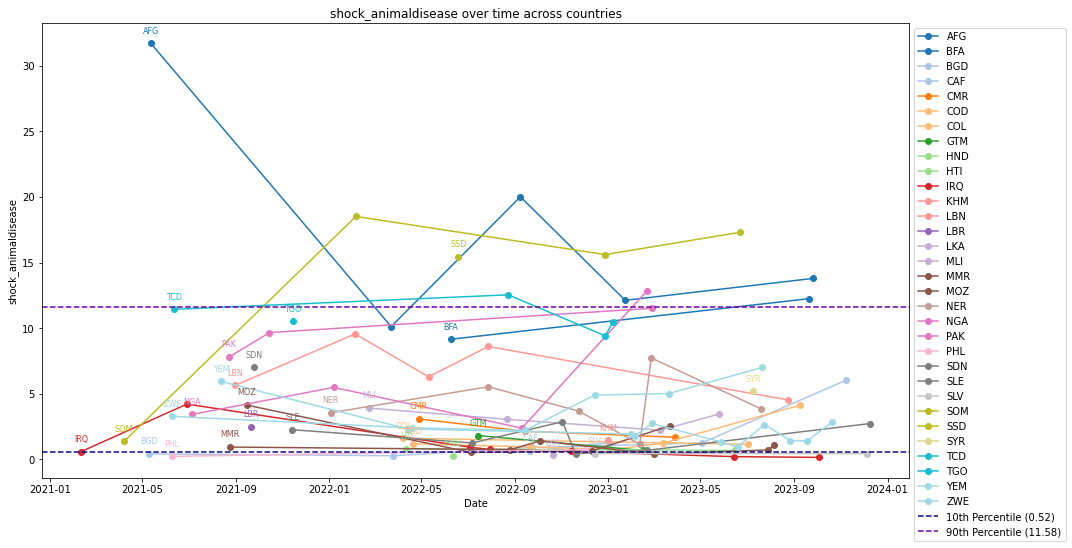

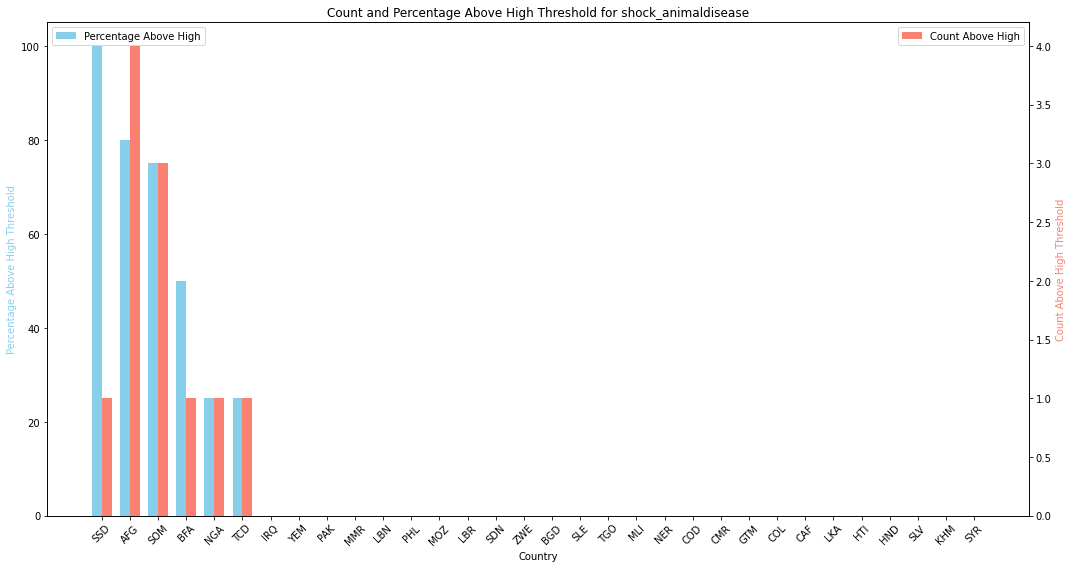

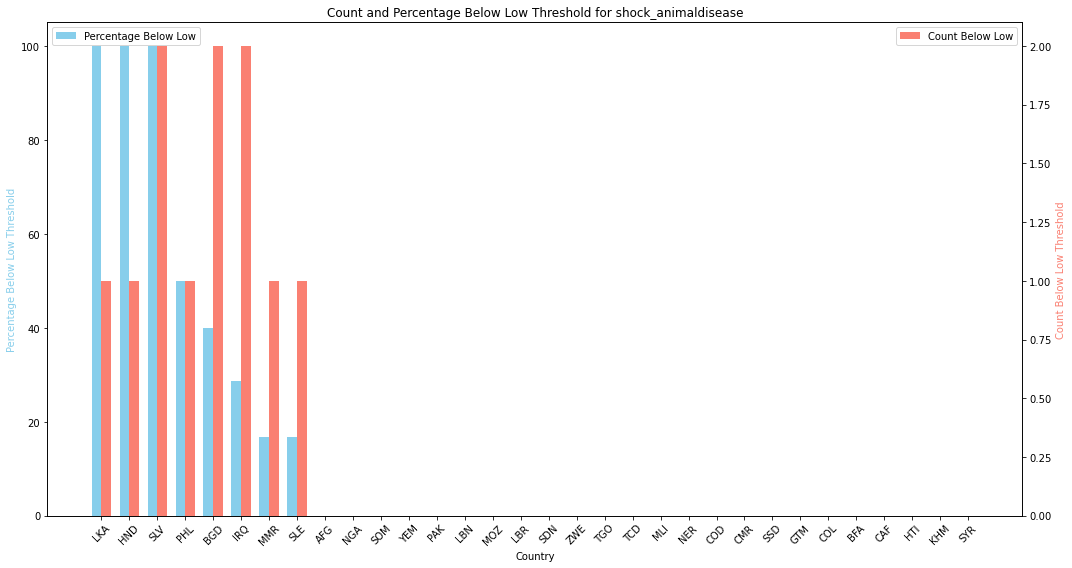

shock_violenceinsecconf
Percentage of households that, for question asked: 'Has your household or community faced any particular disaster or crisis affecting your household's ability to raise an income and/or to produce food for self consumption in the last 3 months, and if so, which one(s)? ', have answered: 'Violence and insecurity / conflict'. 


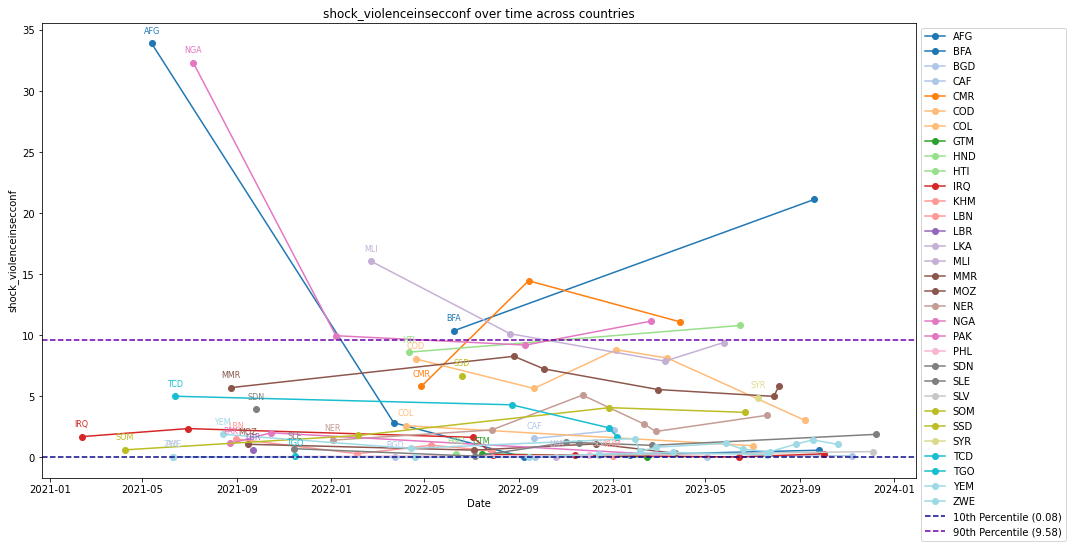

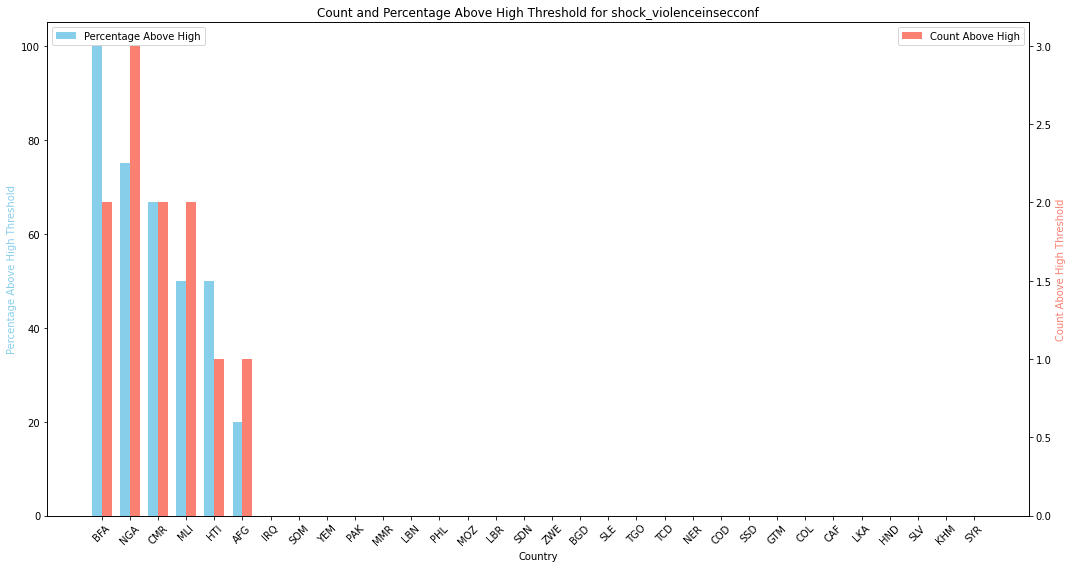

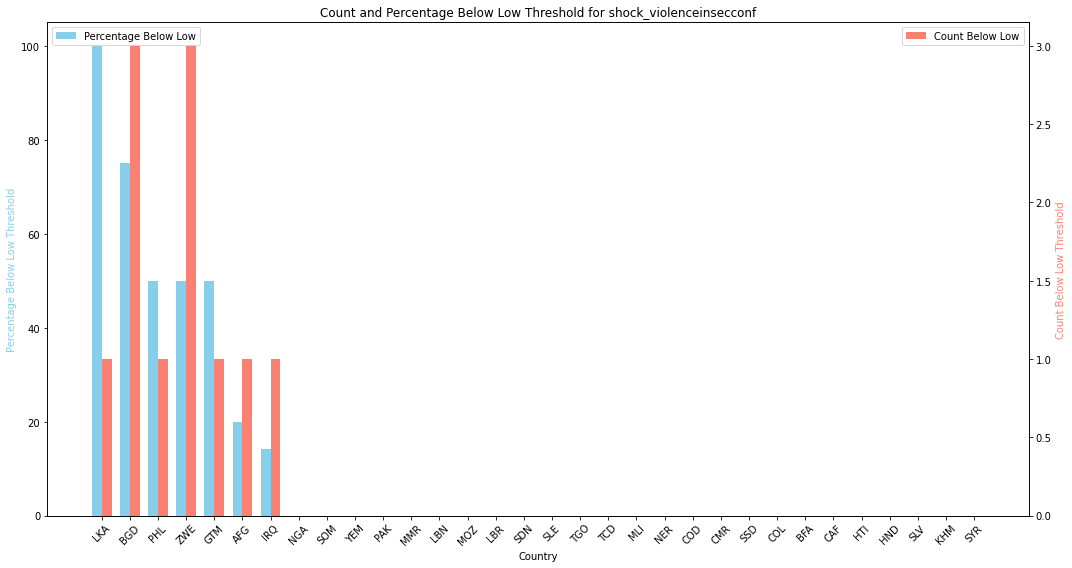

need_food
Percentage of households that, for question asked: 'What are your household's greatest needs for assistance for agricultural activities [including crop, livestock or fisheries/aquaculture activities] over the next 3 to 6 months?', have answered: 'Food'. 


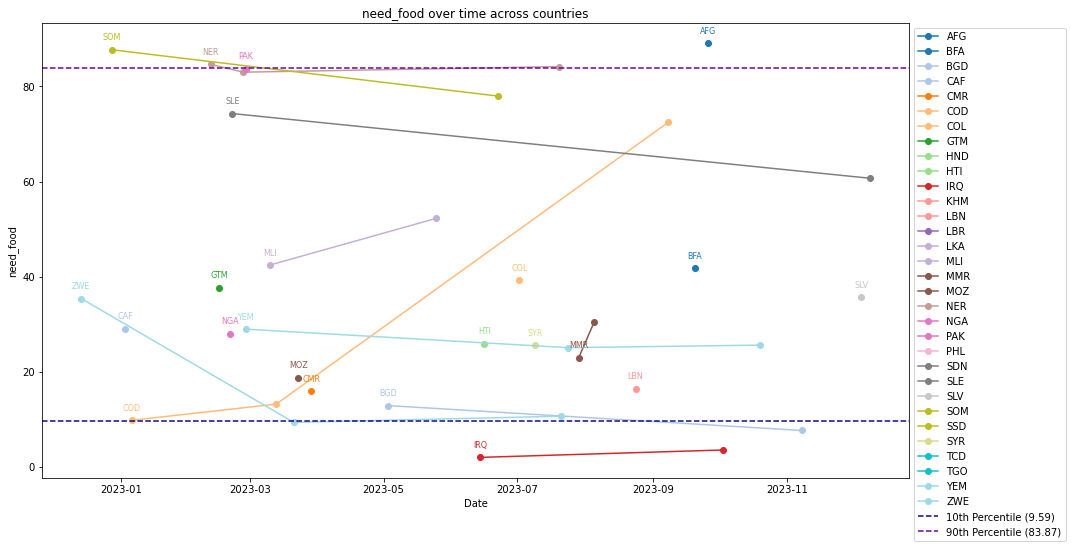

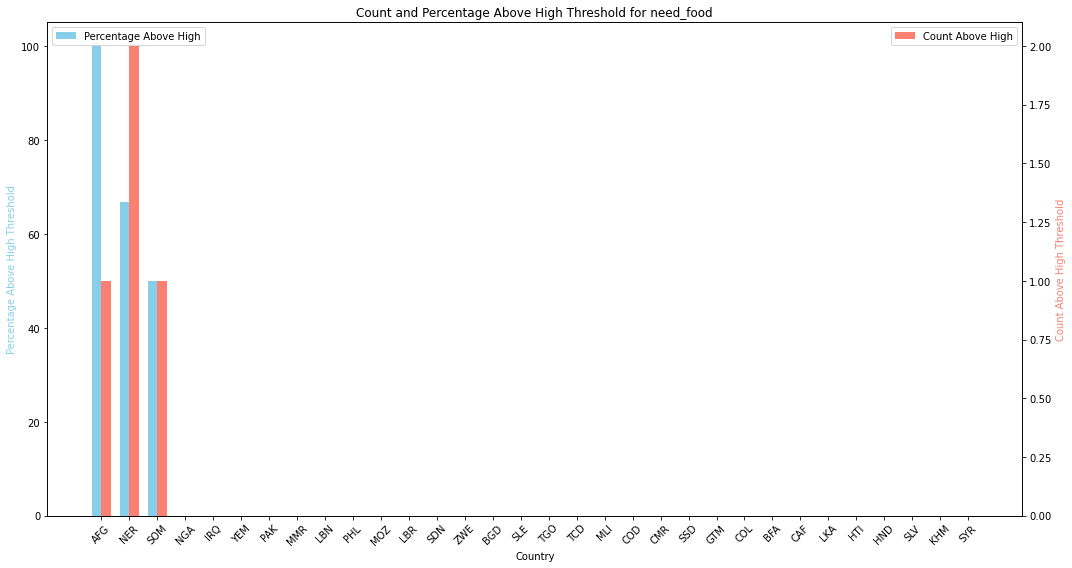

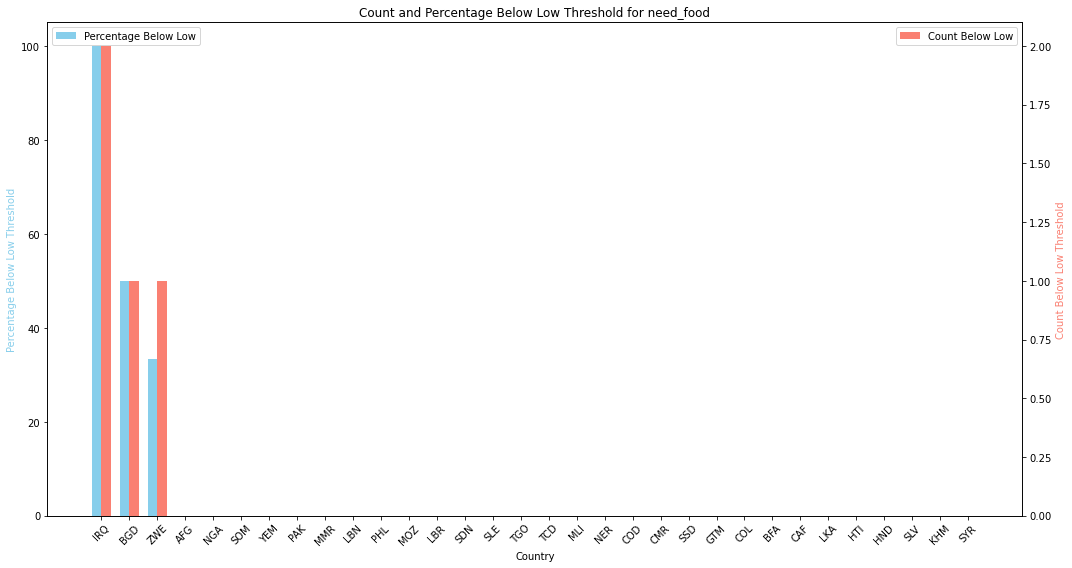

need_crop_inputs
Percentage of households that, for question asked: 'What are your household's greatest needs for assistance for agricultural activities [including crop, livestock or fisheries/aquaculture activities] over the next 3 to 6 months?', have answered: 'Inputs for crop and/or vegetable production (e.g. seeds, fertilizer, tools)'. 


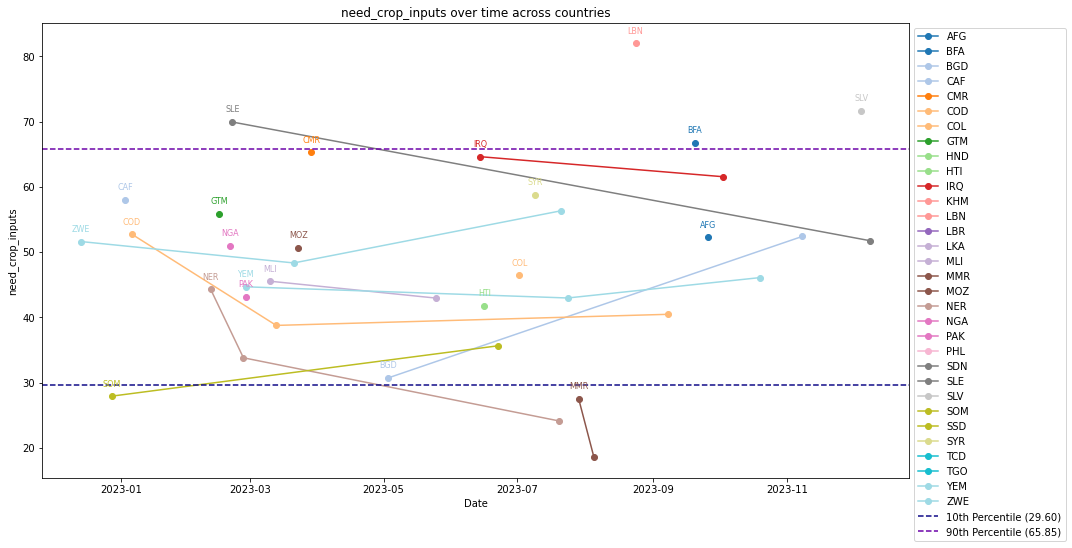

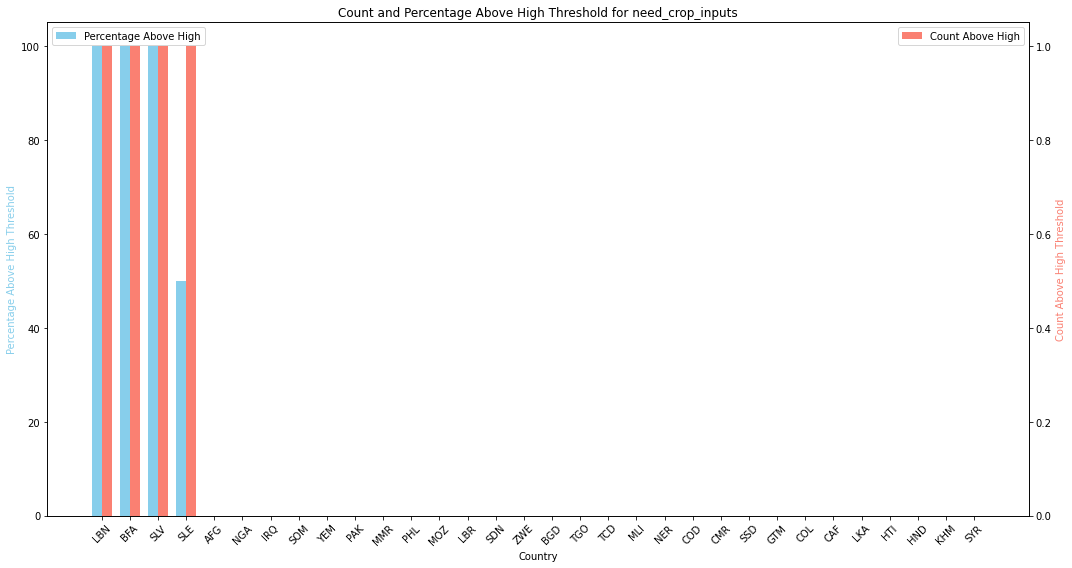

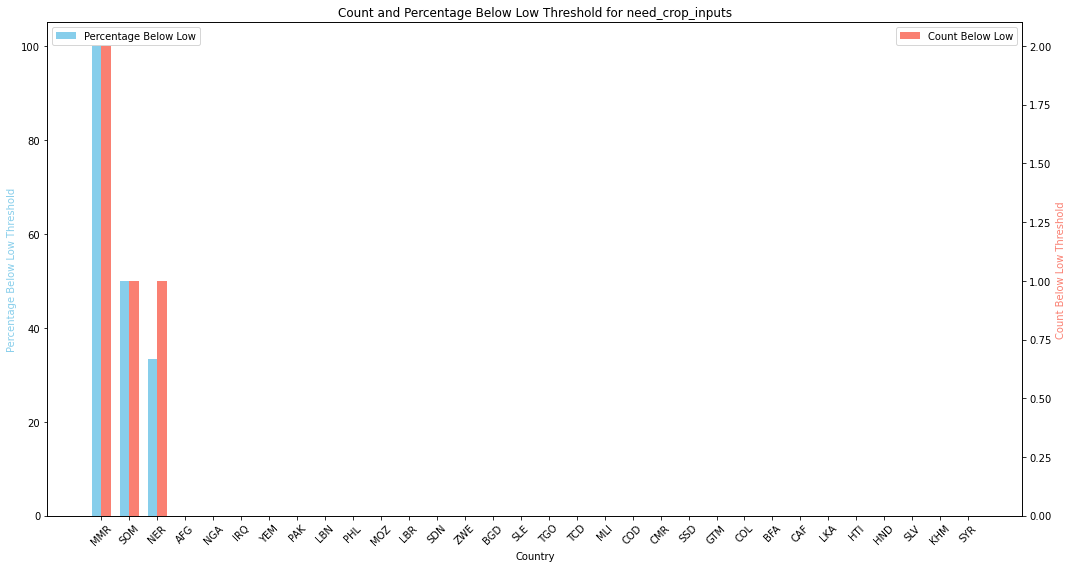

ls_proddif_diseases
Percentage of households that, for question asked: 'Which difficulties has your household faced with livestock production in the last 3 months?', have answered: 'Livestock diseases or injury'. 


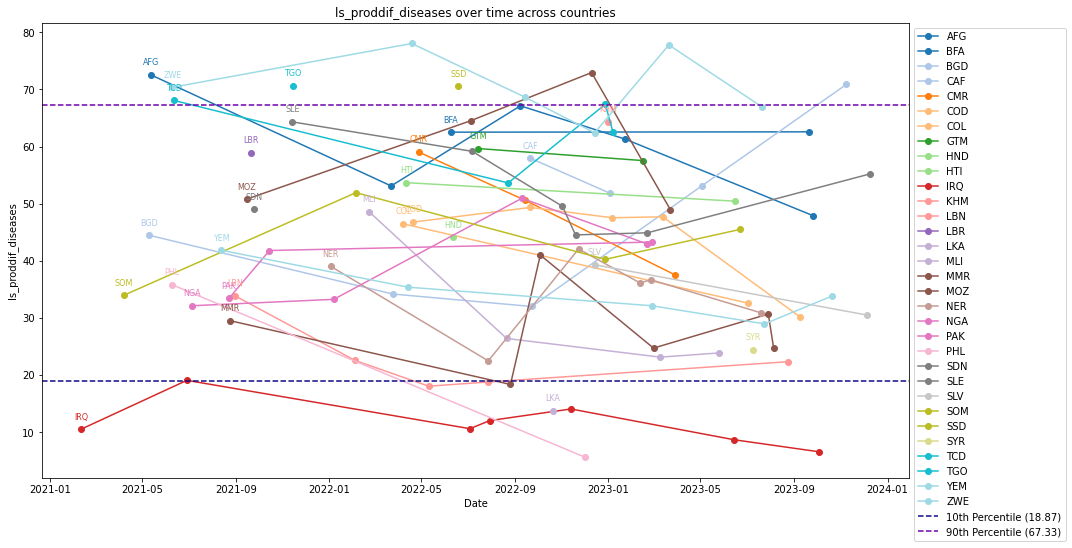

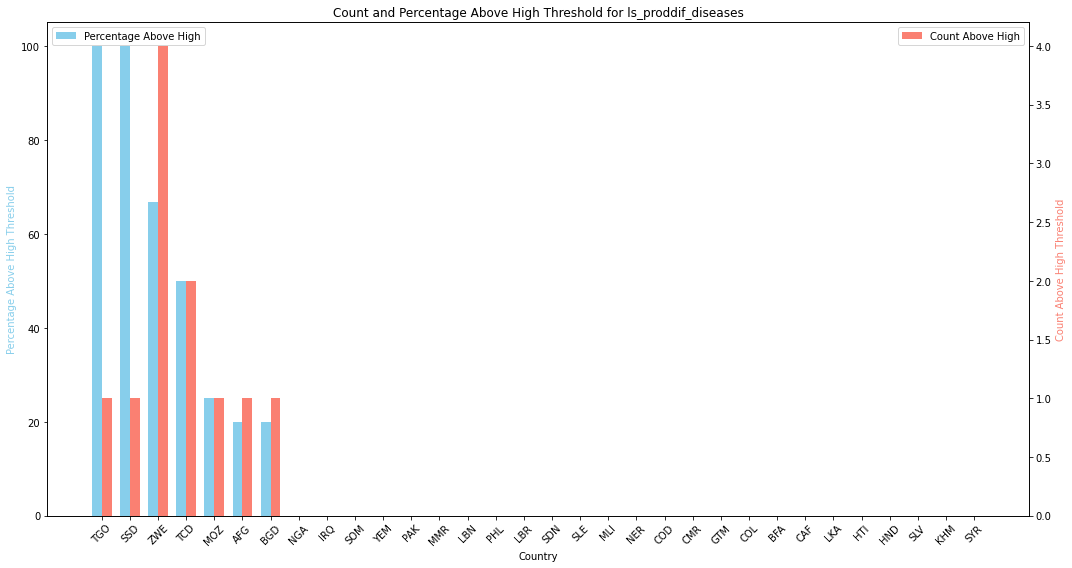

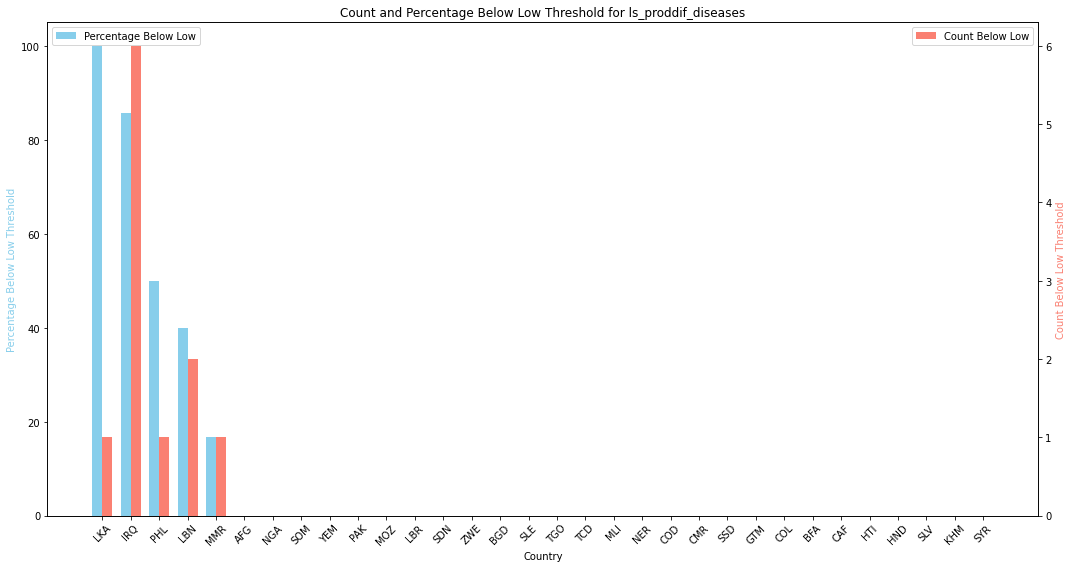

In [5]:

# User options
percentile = 90  # For the 'percentiles' method
num_std_dev = 2  # For the 'std_dev' method
num_classes = 6  # For the 'equal_interval' method
method = 'percentiles'  # Method for classifying ('percentiles', 'std_dev', 'equal_interval')


field_descriptions = pd.Series(fields_descr_df['Field description'].values, index=fields_descr_df['Field name']).to_dict()

# Initialize dictionaries for total counts and percentages
total_data_points = {country: 0 for country in countries}
percentage_high_extremes = {country: 0 for country in countries}
percentage_low_extremes = {country: 0 for country in countries}
# Initialize dictionaries for cumulative counts and total data points
cumulative_high_counts = {country: 0 for country in countries}
cumulative_low_counts = {country: 0 for country in countries}


# Cell 4: Modified Plotting Loop with Threshold Lines, Graded Colors, and Labels
for variable in variables:
    print(variable)
    # First, try to get the description using 'variable' as the key.
    # If not found, try appending '_1' to the variable and look again.
    description = field_descriptions.get(variable) or field_descriptions.get(variable + "_1", variable)
    
    if description != variable:
        print (description)

    # Calculate thresholds
    if method == 'percentiles':
        thresholds = calculate_thresholds(df[df[variable] != 0][variable], percentile=percentile, method=method)
    elif method == 'std_dev':
        thresholds = calculate_thresholds(df[df[variable] != 0][variable], num_std_dev=num_std_dev, method=method)
    else:
        thresholds = calculate_thresholds(df[df[variable] != 0][variable], method=method)
    
    highest_threshold = max(thresholds)
    
    # Calculate mean and standard deviation if method is std_dev
    if method == 'std_dev':
        mean_value = df[df[variable] != 0][variable].mean()
        std_dev = df[df[variable] != 0][variable].std()
    else:
        mean_value, std_dev = None, None

    # Calculate the mean if method is std_dev
    mean_value = df[df[variable] != 0][variable].mean() if method == 'std_dev' else None
    
    # Determine y-axis range for the current variable with a margin
    y_min = df[df[variable] != 0][variable].min()
    y_max = df[df[variable] != 0][variable].max()
    y_range = y_max - y_min
    margin = 0.05 * y_range  # 5% margin

    # Create a figure for the current indicator
    plt.figure(figsize=(15, 8))

    # Generate a larger set of distinct colors for countries
    country_colors = cm.get_cmap('tab20', len(countries))(range(len(countries)))

    # Generate colors for thresholds
    threshold_colors = cm.get_cmap('plasma', num_classes)(range(num_classes))
    legend_handles = []
    sorted_countries = sorted(countries)
    for i, country in enumerate(sorted_countries):
        # Filter data for the current country
        country_data = df[(df['adm0_iso3'] == country) & (df[variable].notnull()) & (df[variable] != 0)].copy()

        # Check the number of unique rounds for the current country
        unique_rounds = country_data['round'].nunique()
#         if unique_rounds <= 1:
#             continue  # Skip plotting for countries with only one round

        # Convert coll_mid_date to datetime and sort by date
        country_data['coll_mid_date'] = pd.to_datetime(country_data['coll_mid_date'])
        country_data = country_data.sort_values(by='coll_mid_date')

        # Plotting for each country on the same chart
        line, = plt.plot(country_data['coll_mid_date'], country_data[variable], marker='o', color=country_colors[i], label=country)

        # Add label at the beginning of the line
        if len(country_data) > 0:
            first_point = country_data.iloc[0]
            text = plt.annotate(country, (first_point['coll_mid_date'], first_point[variable]),
                                textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color=line.get_color())
            #text.set_path_effects([path_effects.withStroke(linewidth=3, foreground='black')])

    # Enhanced labels for thresholds
    for i, threshold in enumerate(thresholds):
        # Check if threshold is within the y-axis range
        if y_min <= threshold <= y_max:
            if method == 'percentiles':
                if i == 0:
                    label = f'{100 - percentile}th Percentile ({threshold:.2f})'
                else:
                    label = f'{percentile}th Percentile ({threshold:.2f})'
            elif method == 'std_dev':
                std_devs_from_mean = (threshold - mean_value) / std_dev
                label = 'Mean' if std_devs_from_mean == 0 else f'{std_devs_from_mean:.1f} Std Dev ({threshold:.2f})'
                plt.axhline(y=mean_value, color='grey', linestyle='--', label='Mean')
            elif method == 'equal_interval':
                interval_range = (thresholds[-1] - thresholds[0]) / (num_classes - 1)
                interval_start = thresholds[0] + i * interval_range
                label = f'Interval {i+1}: [{interval_start:.2f}, {threshold:.2f})'

            plt.axhline(y=threshold, color=threshold_colors[i], linestyle='--', label=label)

    # Annotating the plot with labels, title, and legends
    plt.title(f'{variable} over time across countries')
    plt.xlabel('Date')
    plt.ylabel(variable)
    # Extend y-axis limits
    plt.ylim(y_min - margin, y_max + margin)  # Add margin to y-axis limits

    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside of the plot
    plt.tight_layout()
    plt.show()  # Display the plot
    
    # Histogram calculation for counts and percentages at high and low extremes
    country_high_counts, country_low_counts = {}, {}
    country_high_percentages, country_low_percentages = {}, {}
    low_threshold, high_threshold = min(thresholds), max(thresholds)

    for country in countries:
        country_data = df[(df['adm0_iso3'] == country) & (df[variable].notnull()) & (df[variable] != 0)]
        high_count = sum(country_data[variable] > high_threshold)
        low_count = sum(country_data[variable] < low_threshold)
        data_count = len(country_data)

        cumulative_high_counts[country] += high_count
        cumulative_low_counts[country] += low_count
        total_data_points[country] += data_count
       
        country_high_counts[country] = high_count
        country_low_counts[country] = low_count
        country_high_percentages[country] = (high_count / data_count) * 100 if data_count > 0 else 0
        country_low_percentages[country] = (low_count / data_count) * 100 if data_count > 0 else 0
        
    # Calculate percentages
    for country in countries:
        if total_data_points[country] > 0:
            percentage_high_extremes[country] = (cumulative_high_counts[country] / total_data_points[country]) * 100
            percentage_low_extremes[country] = (cumulative_low_counts[country] / total_data_points[country]) * 100


    # Sorting data by high and low percentages
    sorted_countries_high = sorted(country_high_percentages, key=country_high_percentages.get, reverse=True)
    sorted_high_counts = [country_high_counts[country] for country in sorted_countries_high]
    sorted_high_percentages = [country_high_percentages[country] for country in sorted_countries_high]

    sorted_countries_low = sorted(country_low_percentages, key=country_low_percentages.get, reverse=True)
    sorted_low_counts = [country_low_counts[country] for country in sorted_countries_low]
    sorted_low_percentages = [country_low_percentages[country] for country in sorted_countries_low]

    # Plotting Histogram for High Thresholds
    fig, ax1_high = plt.subplots(figsize=(15, 8))
    ax2_high = ax1_high.twinx()
    x_high = np.arange(len(sorted_countries_high))  # label locations
    width = 0.35  # width of the bars

    ax1_high.bar(x_high - width/2, sorted_high_percentages, width, label='Percentage Above High', color='skyblue')
    ax2_high.bar(x_high + width/2, sorted_high_counts, width, label='Count Above High', color='salmon')

    ax1_high.set_xlabel('Country')
    ax1_high.set_ylabel('Percentage Above High Threshold', color='skyblue')
    ax2_high.set_ylabel('Count Above High Threshold', color='salmon')
    ax1_high.set_title(f'Count and Percentage Above High Threshold for {variable}')
    ax1_high.set_xticks(x_high)
    ax1_high.set_xticklabels(sorted_countries_high, rotation=45)
    ax1_high.legend(loc='upper left')
    ax2_high.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Plotting Histogram for Low Thresholds
    fig, ax1_low = plt.subplots(figsize=(15, 8))
    ax2_low = ax1_low.twinx()
    x_low = np.arange(len(sorted_countries_low))  # label locations

    ax1_low.bar(x_low - width/2, sorted_low_percentages, width, label='Percentage Below Low', color='skyblue')
    ax2_low.bar(x_low + width/2, sorted_low_counts, width, label='Count Below Low', color='salmon')

    ax1_low.set_xlabel('Country')
    ax1_low.set_ylabel('Percentage Below Low Threshold', color='skyblue')
    ax2_low.set_ylabel('Count Below Low Threshold', color='salmon')
    ax1_low.set_title(f'Count and Percentage Below Low Threshold for {variable}')
    ax1_low.set_xticks(x_low)
    ax1_low.set_xticklabels(sorted_countries_low, rotation=45)
    ax1_low.legend(loc='upper left')
    ax2_low.legend(loc='upper right')

    plt.tight_layout()
    plt.show()
    


## Cumulative Chart Analysis

After analyzing individual variables, the script aggregates the results to create a comprehensive cumulative chart. This chart visualizes both the counts and the percentages of data points falling into high and low extreme ranges across all indicators for each country. The methodology for this part of the script includes:

1. **Sorting Countries**: Based on cumulative high percentages of extremes. Countries are sorted in descending order to highlight those with the highest frequency of extreme values.

2. **Preparing Data for Plotting**: The script gathers cumulative counts and percentages for high and low extremes for each country.

3. **Creating the Cumulative Chart**:
   - Initializes a figure with two axes (one for counts and the other for percentages).
   - Plots bars for high and low extremes on the respective axes.
   - Adds labels on each bar to display the exact count or percentage value.
   
4. **Enhancing the Chart**:
   - Sets labels for axes, titles for the chart, and rotates country labels for better readability.
   - Positions the legend below the chart to avoid cluttering.
   - Adjusts the layout to fit all elements neatly.

This cumulative chart offers a holistic view of each country's performance across all surveyed indicators, highlighting those frequently experiencing extreme conditions.



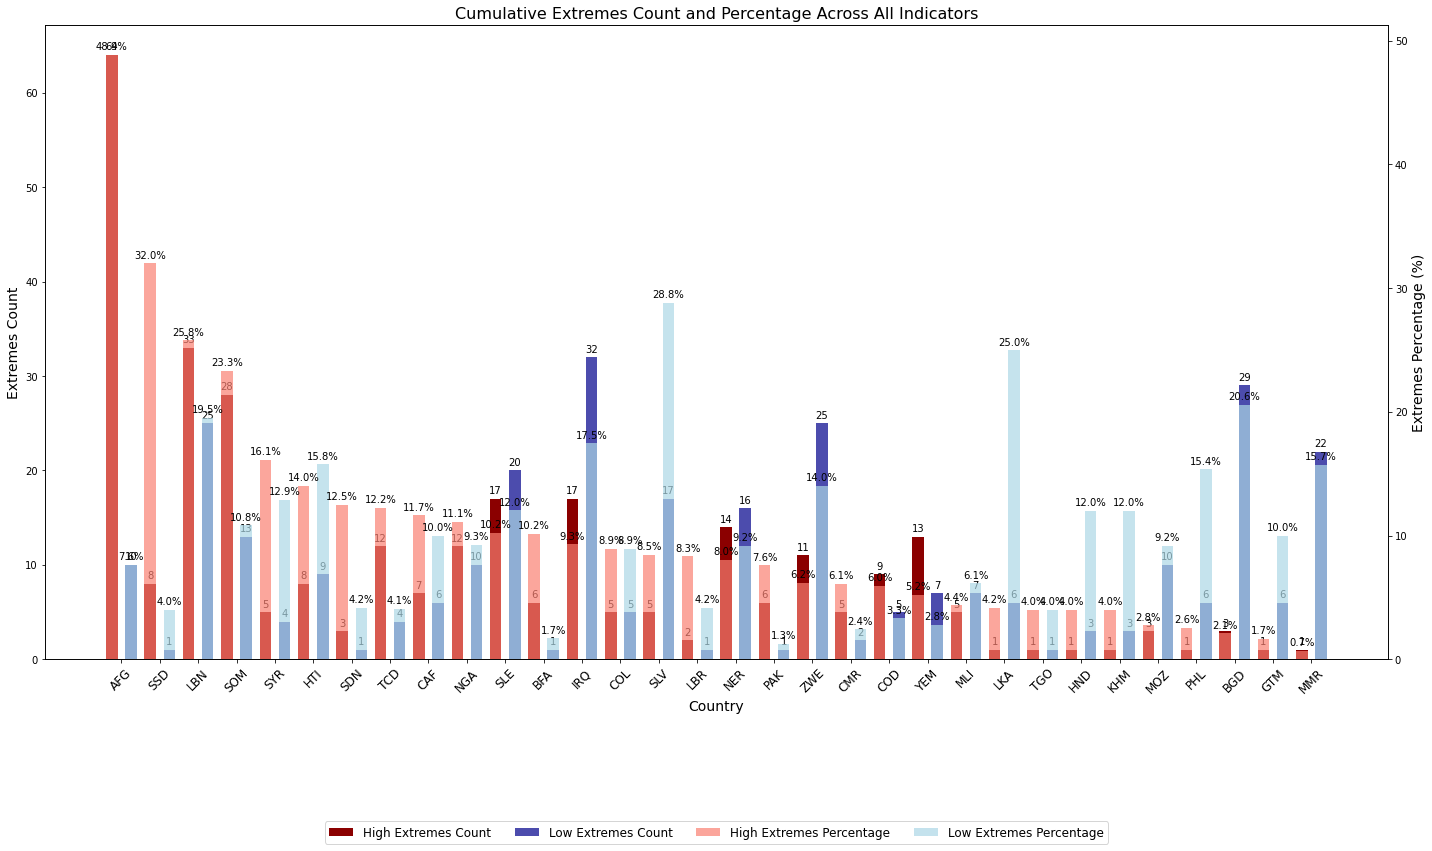

In [6]:
# Sorting countries based on cumulative high percentages
sorted_countries = sorted(percentage_high_extremes, key=percentage_high_extremes.get, reverse=True)
sorted_cumulative_highs = [cumulative_high_counts[country] for country in sorted_countries]
sorted_percent_highs = [percentage_high_extremes[country] for country in sorted_countries]
sorted_cumulative_lows = [cumulative_low_counts[country] for country in sorted_countries]
sorted_percent_lows = [percentage_low_extremes[country] for country in sorted_countries]


# Plotting the final cumulative chart with counts and percentages
fig, ax1 = plt.subplots(figsize=(20, 12))
ax2 = ax1.twinx()  # Secondary axis for percentages

# Bar positions and width
x = np.arange(len(sorted_countries))
bar_width = 0.3
spacing = 0.1  # Additional spacing between groups

# Plotting bars for high extremes
high_bars_count = ax1.bar(x - bar_width / 2 - spacing, sorted_cumulative_highs, bar_width, label='High Extremes Count', color='darkred')
high_bars_percent = ax2.bar(x - bar_width / 2 - spacing, sorted_percent_highs, bar_width, label='High Extremes Percentage', color='salmon', alpha=0.7)

# Plotting bars for low extremes
low_bars_count = ax1.bar(x + bar_width / 2 + spacing, sorted_cumulative_lows, bar_width, label='Low Extremes Count', color='darkblue', alpha=0.7)
low_bars_percent = ax2.bar(x + bar_width / 2 + spacing, sorted_percent_lows, bar_width, label='Low Extremes Percentage', color='lightblue', alpha=0.7)

# Adding labels on bars
def add_labels(bars, axis, is_percentage=False):
    for bar in bars:
        height = bar.get_height()
        label = '{:.1f}%'.format(height) if is_percentage else '{}'.format(int(height))
        axis.annotate(label,
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

add_labels(high_bars_count, ax1)
add_labels(high_bars_percent, ax2, is_percentage=True)
add_labels(low_bars_count, ax1)
add_labels(low_bars_percent, ax2, is_percentage=True)

# Adding labels, title, and legends
ax1.set_xlabel('Country', fontsize=14)
ax1.set_ylabel('Extremes Count', fontsize=14, color='black')
ax2.set_ylabel('Extremes Percentage (%)', fontsize=14, color='black')
ax1.set_title('Cumulative Extremes Count and Percentage Across All Indicators', fontsize=16)
ax1.set_xticks(x)
ax1.set_xticklabels(sorted_countries, rotation=45, fontsize=12)

# Moving the legend below the chart
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
plt.legend(handles1 + handles2, labels1 + labels2, loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=4, fontsize=12)

# Adjusting layout for better fit
plt.tight_layout()
plt.show()


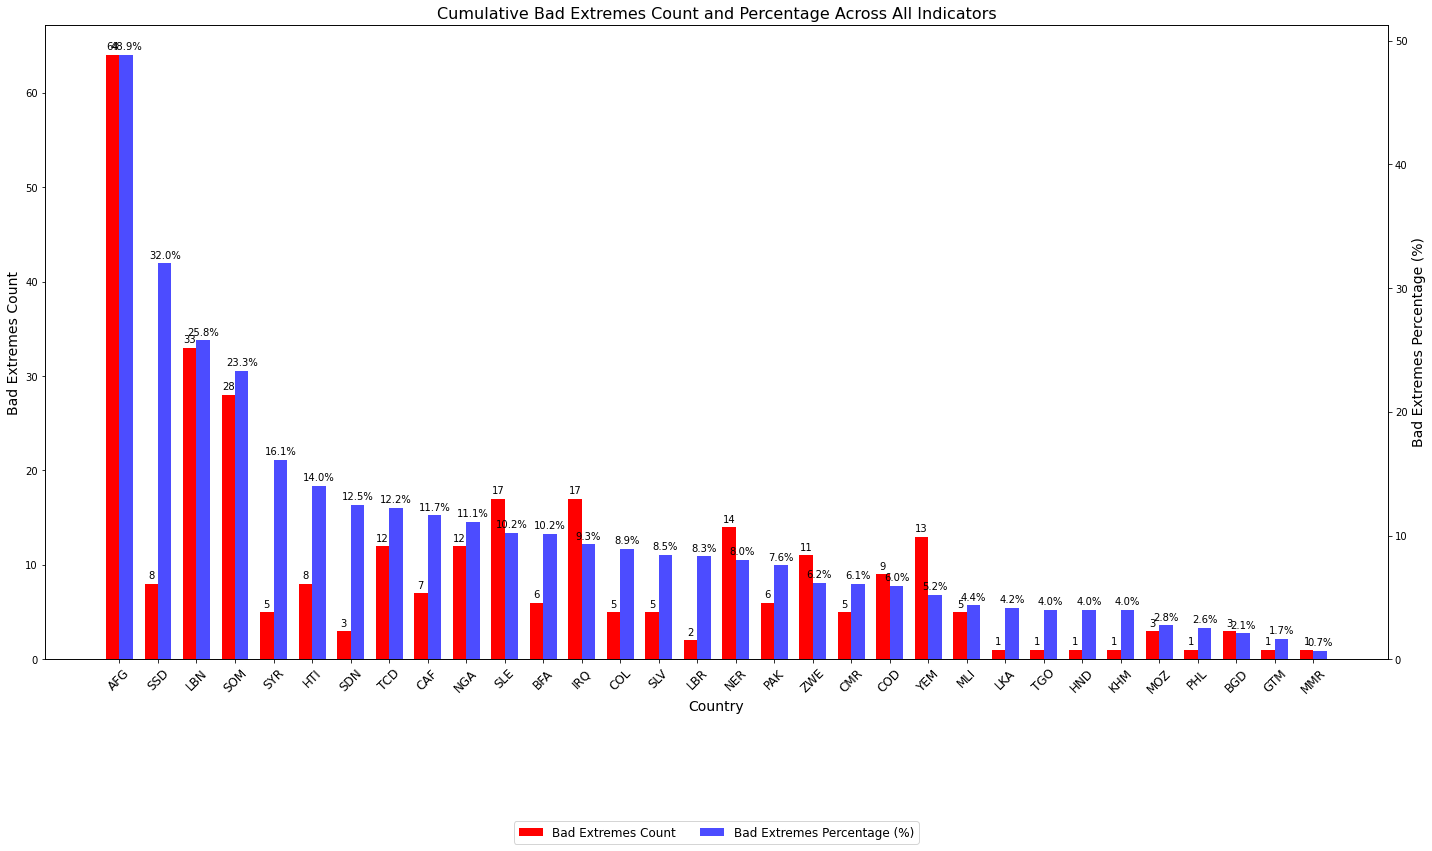

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# User options
percentile = 90 # For the 'percentiles' method
num_std_dev = 2 # For the 'std_dev' method
num_classes = 6 # For the 'equal_interval' method
method = 'percentiles' # Method for classifying ('percentiles', 'std_dev', 'equal_interval')
positive_high_value_vars = []# ['lcsi_0', 'hdds_class_3', 'assistance_quality_1']  # List of variables where high values are positive


# Load data
file_path = r'C:\temp\diem_monitoring_adm0.csv'
df = pd.read_csv(file_path)
countries = df['adm0_iso3'].unique()
variables = df.columns.drop(['adm0_iso3', 'adm0_name', 'coll_mid_date', 'round'])

# Initialize dictionaries
cumulative_bad_counts = {country: 0 for country in countries}
total_data_points = {country: 0 for country in countries}

# Analysis loop
for variable in variables:
    # Calculate thresholds
    if method == 'percentiles':
        thresholds = calculate_thresholds(df[df[variable] != 0][variable], percentile=percentile, method=method)
    elif method == 'std_dev':
        thresholds = calculate_thresholds(df[df[variable] != 0][variable], num_std_dev=num_std_dev, method=method)
    else:
        thresholds = calculate_thresholds(df[df[variable] != 0][variable], method=method)
    
    high_threshold = max(thresholds)
    low_threshold = min(thresholds)

    for country in countries:
        country_data = df[(df['adm0_iso3'] == country) & (df[variable].notnull()) & (df[variable] != 0)]
        if variable in positive_high_value_vars:
            bad_count = sum(country_data[variable] < low_threshold)
        else:
            bad_count = sum(country_data[variable] > high_threshold)
        
        cumulative_bad_counts[country] += bad_count
        total_data_points[country] += len(country_data)

# Calculate percentages
percentage_bad_extremes = {country: (cumulative_bad_counts[country] / total_data_points[country]) * 100 if total_data_points[country] > 0 else 0 for country in countries}

# Sorting countries based on cumulative bad percentages
sorted_countries_by_percentage = sorted(percentage_bad_extremes, key=percentage_bad_extremes.get, reverse=True)
sorted_bad_counts_by_percentage = [cumulative_bad_counts[country] for country in sorted_countries_by_percentage]
sorted_bad_percentages_by_percentage = [percentage_bad_extremes[country] for country in sorted_countries_by_percentage]

# Plotting the final chart
fig, ax1 = plt.subplots(figsize=(20, 12))
ax2 = ax1.twinx()

x = np.arange(len(sorted_countries_by_percentage))
bar_width = 0.35

# Plotting bars for counts and percentages
count_bars = ax1.bar(x - bar_width/2, sorted_bad_counts_by_percentage, bar_width, color='red', label='Negative Extremes Count')
percent_bars = ax2.bar(x + bar_width/2, sorted_bad_percentages_by_percentage, bar_width, color='blue', alpha=0.7, label='Negative Extremes Percentage (%)')

# Function to add labels to the bars
def add_bar_labels(bars, axis, is_percent=False):
    for bar in bars:
        height = bar.get_height()
        label = f'{height:.1f}%' if is_percent else f'{int(height)}'
        axis.annotate(label,
                      xy=(bar.get_x() + bar.get_width() / 2, height),
                      xytext=(0, 3),  # 3 points vertical offset
                      textcoords="offset points",
                      ha='center', va='bottom')

# Adding labels on the bars
add_bar_labels(count_bars, ax1)
add_bar_labels(percent_bars, ax2, is_percent=True)

# Setting labels, title, and legend
ax1.set_xlabel('Country', fontsize=14)
ax1.set_ylabel('Negative Extremes Count', fontsize=14, color='black')
ax2.set_ylabel('Negative Extremes Percentage (%)', fontsize=14, color='black')
ax1.set_title('Cumulative Negative Extremes Count and Percentage Across All Indicators', fontsize=16)
ax1.set_xticks(x)
ax1.set_xticklabels(sorted_countries_by_percentage, rotation=45, fontsize=12)

# Moving the legend below the chart
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
plt.legend(handles1 + handles2, labels1 + labels2, loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=4, fontsize=12)

plt.tight_layout()
plt.show()